# Toxic Comments Classification by Using TF-IDF

In [37]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [118]:
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CAU\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\CAU\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\CAU\AppData\Roaming\nltk_data...


In [131]:
# 축약어 모음
APPOS = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "i would",
"i'd" : "i had",
"i'll" : "i will",
"i'm" : "i am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "i have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not"
}
# 불용어 모음
STOPWORDS = set(stopwords.words("english"))

lemmatizer = WordNetLemmatizer()
tokenizer = TweetTokenizer()
sentAnalyzer = SentimentIntensityAnalyzer()

## 1. 데이터 로드

In [41]:
df = pd.read_csv('./data/train.csv')
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\r\n\r\nCongratulations from me as well, use ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [43]:
df.shape

(159571, 8)

In [44]:
def remain_label_txt(df):
    df['sum_of_toxic'] = df['toxic'] + df['severe_toxic'] + df['obscene'] + df['threat'] + df['insult'] + df['identity_hate']
    df['is_toxic'] = df['sum_of_toxic'].apply(lambda x: 0 if x < 1 else 1)
    df.drop(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'sum_of_toxic', 'id'], axis=1, inplace=True)

    return df

In [45]:
remain_label_txt(df)
df.head(10)

,comment_text,is_toxic
0,Explanation\r\nWhy the edits made under my use...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\r\nMore\r\nI can't make any real suggestions...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\r\n\r\nCongratulations from me as well, use ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


## 2. EDA

## 2.1. 라벨 분포도

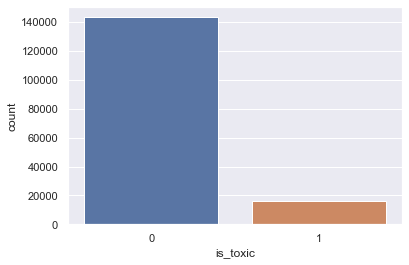

In [46]:
sns.countplot(x="is_toxic", data=df)
plt.show()

## 2.2. 텍스트 길이와 라벨의 관계

In [47]:
df['length'] = df['comment_text'].apply(len)
df.head(10)

,comment_text,is_toxic,length
0,Explanation\r\nWhy the edits made under my use...,0,265
1,D'aww! He matches this background colour I'm s...,0,112
2,"Hey man, I'm really not trying to edit war. It...",0,233
3,"""\r\nMore\r\nI can't make any real suggestions...",0,626
4,"You, sir, are my hero. Any chance you remember...",0,67
5,"""\r\n\r\nCongratulations from me as well, use ...",0,67
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,44
7,Your vandalism to the Matt Shirvington article...,0,115
8,Sorry if the word 'nonsense' was offensive to ...,0,472
9,alignment on this subject and which are contra...,0,70


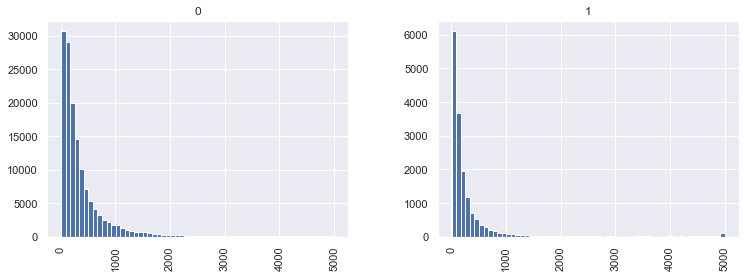

In [48]:
df.hist(column='length',by='is_toxic',bins=60,figsize=(12,4));

## 3. 데이터 전처리

In [49]:
# 쓸모없는 정보(개행, IP주소, USERNAME)을 제거하는 함수
def clean_useless(comment):
    comment = comment.lower()
    
    # 개행 제거
    comment = re.sub('\\n', " ", comment)
    # IP주소 제거
    comment = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    # USERNAME 제거
    comment = re.sub("\[\[.*\]","",comment)
    
    # 토큰화
    words = tokenizer.tokenize(comment)
    
    # 줄임말 풀이
    words = [APPOS[word] if word in APPOS else word for word in words]
    # 줄임말 다시 분리
    sent = " ".join(words)
    words = tokenizer.tokenize(sent)
    # stemming
    words = [lemmatizer.lemmatize(word, "v") for word in words]
    # Puctuation 제거
    words = [w for w in words if not w in string.punctuation]
    # 불용어 제거
    words = [w for w in words if not w in STOPWORDS]
    
    
    clean_sent = " ".join(words)
    
    return clean_sent

In [50]:
# 위의 함수를 적용하여 comment를 clean하게 만드는 함수
def get_clean_comment(df):
    df['comment_text'] = df['comment_text'].apply(lambda x: clean_useless(x))
    
    return df

In [51]:
df = get_clean_comment(df)
df.head(10)

,comment_text,is_toxic,length
0,explanation edit make username hardcore metall...,0,265
1,d'aww match background colour seemingly stick ...,0,112
2,hey man really try edit war guy constantly rem...,0,233
3,cannot make real suggestions improvement wonde...,0,626
4,sir hero chance remember page,0,67
5,congratulations well use tool well · talk,0,67
6,cocksucker piss around work,1,44
7,vandalism matt shirvington article revert plea...,0,115
8,sorry word nonsense offensive anyway intend wr...,0,472
9,alignment subject contrary dulithgow,0,70


In [52]:
df = df.drop(['length'], axis=1)
df.head(10)

,comment_text,is_toxic
0,explanation edit make username hardcore metall...,0
1,d'aww match background colour seemingly stick ...,0
2,hey man really try edit war guy constantly rem...,0
3,cannot make real suggestions improvement wonde...,0
4,sir hero chance remember page,0
5,congratulations well use tool well · talk,0
6,cocksucker piss around work,1
7,vandalism matt shirvington article revert plea...,0
8,sorry word nonsense offensive anyway intend wr...,0
9,alignment subject contrary dulithgow,0


## 4. 정도 지표 구하기

In [134]:
def bad_amount(comment):
    bad_words = pd.read_csv("./bad_words.csv").en_bad_words.tolist()
    
    # bad word counting
    count_of_word = len(comment.split())+1
    count_of_bad = sum((1 for word in bad_words if comment.count(word)>0))
    percent_of_bad = count_of_bad / count_of_word
    
    # sentimental analysis
    sent_score = sentAnalyzer.polarity_scores(comment)['compound']

    final_score = -sent_score + percent_of_bad
    
    return final_score

In [135]:
df['bad_amount'] = df['comment_text'].apply(lambda x: bad_amount(x))
df.head(10)

,comment_text,is_toxic,bad_amount
0,explanation edit make username hardcore metall...,0,-0.515733
1,d'aww match background colour seemingly stick ...,0,-0.361200
2,hey man really try edit war guy constantly rem...,0,0.241500
3,cannot make real suggestions improvement wonde...,0,-0.250000
4,sir hero chance remember page,0,-0.680800
5,congratulations well use tool well · talk,0,-0.796400
6,cocksucker piss around work,1,1.378300
7,vandalism matt shirvington article revert plea...,0,0.318200
8,sorry word nonsense offensive anyway intend wr...,0,0.571900
9,alignment subject contrary dulithgow,0,0.000000


In [137]:
df['bad_amount'].describe()

count    159571.000000
mean         -0.129186
std           0.580450
min          -1.000000
25%          -0.636900
50%          -0.107800
75%           0.273200
max           2.525767
Name: bad_amount, dtype: float64

In [139]:
df.drop(['bad_amount'], axis=1, inplace=True)
df.head(10)

,comment_text,is_toxic
0,explanation edit make username hardcore metall...,0
1,d'aww match background colour seemingly stick ...,0
2,hey man really try edit war guy constantly rem...,0
3,cannot make real suggestions improvement wonde...,0
4,sir hero chance remember page,0
5,congratulations well use tool well · talk,0
6,cocksucker piss around work,1
7,vandalism matt shirvington article revert plea...,0
8,sorry word nonsense offensive anyway intend wr...,0
9,alignment subject contrary dulithgow,0


## 5. 모델링 및 학습

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

tfidf_vect = TfidfVectorizer("english")
X_features = tfidf_vect.fit_transform(df['comment_text'])
y_labels = df['is_toxic']

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=0)

In [54]:
params = {
    'num_leaves' : [32, 64],
    'max_depth' : [128, 160],
    'min_child_samples' : [60, 100],
    'subsample' : [0.8, 1],
}

lgbm_clf = LGBMClassifier(n_estimators=300)
gridcv = GridSearchCV(lgbm_clf, param_grid=params)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])
print('최적의 하이퍼 파라미터 모델 :', gridcv.best_params_)

[1]	valid_0's auc: 0.839172	valid_0's binary_logloss: 0.28186	valid_1's auc: 0.83399	valid_1's binary_logloss: 0.286123
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.866069	valid_0's binary_logloss: 0.26039	valid_1's auc: 0.858556	valid_1's binary_logloss: 0.264643
[3]	valid_0's auc: 0.870414	valid_0's binary_logloss: 0.245759	valid_1's auc: 0.862478	valid_1's binary_logloss: 0.249905
[4]	valid_0's auc: 0.881012	valid_0's binary_logloss: 0.234712	valid_1's auc: 0.872915	valid_1's binary_logloss: 0.23881
[5]	valid_0's auc: 0.887304	valid_0's binary_logloss: 0.225862	valid_1's auc: 0.878258	valid_1's binary_logloss: 0.230015
[6]	valid_0's auc: 0.90149	valid_0's binary_logloss: 0.21835	valid_1's auc: 0.89138	valid_1's binary_logloss: 0.222626
[7]	valid_0's auc: 0.901908	valid_0's binary_logloss: 0.212268	valid_1's auc: 0.891694	valid_1's binary_logloss: 0.21667
[8]	valid_0's auc: 0.906248	valid_0's binary_logloss: 0.207344	valid_1's auc: 0.895653	valid_

[69]	valid_0's auc: 0.962751	valid_0's binary_logloss: 0.127782	valid_1's auc: 0.94852	valid_1's binary_logloss: 0.140742
[70]	valid_0's auc: 0.962885	valid_0's binary_logloss: 0.127416	valid_1's auc: 0.948718	valid_1's binary_logloss: 0.140478
[71]	valid_0's auc: 0.963155	valid_0's binary_logloss: 0.127051	valid_1's auc: 0.948816	valid_1's binary_logloss: 0.140273
[72]	valid_0's auc: 0.963449	valid_0's binary_logloss: 0.126688	valid_1's auc: 0.949241	valid_1's binary_logloss: 0.139973
[73]	valid_0's auc: 0.963725	valid_0's binary_logloss: 0.126337	valid_1's auc: 0.949547	valid_1's binary_logloss: 0.139656
[74]	valid_0's auc: 0.964011	valid_0's binary_logloss: 0.125998	valid_1's auc: 0.949786	valid_1's binary_logloss: 0.139405
[75]	valid_0's auc: 0.964146	valid_0's binary_logloss: 0.125666	valid_1's auc: 0.949821	valid_1's binary_logloss: 0.139215
[76]	valid_0's auc: 0.96436	valid_0's binary_logloss: 0.1253	valid_1's auc: 0.949772	valid_1's binary_logloss: 0.139035
[77]	valid_0's auc: 

[137]	valid_0's auc: 0.972116	valid_0's binary_logloss: 0.111945	valid_1's auc: 0.954032	valid_1's binary_logloss: 0.131915
[138]	valid_0's auc: 0.972218	valid_0's binary_logloss: 0.111777	valid_1's auc: 0.953993	valid_1's binary_logloss: 0.131901
[139]	valid_0's auc: 0.972308	valid_0's binary_logloss: 0.111623	valid_1's auc: 0.954005	valid_1's binary_logloss: 0.131842
[140]	valid_0's auc: 0.972355	valid_0's binary_logloss: 0.111491	valid_1's auc: 0.953954	valid_1's binary_logloss: 0.131835
[141]	valid_0's auc: 0.972445	valid_0's binary_logloss: 0.111325	valid_1's auc: 0.953936	valid_1's binary_logloss: 0.131768
[142]	valid_0's auc: 0.972498	valid_0's binary_logloss: 0.111189	valid_1's auc: 0.953876	valid_1's binary_logloss: 0.131751
[143]	valid_0's auc: 0.972592	valid_0's binary_logloss: 0.111053	valid_1's auc: 0.953897	valid_1's binary_logloss: 0.131735
[144]	valid_0's auc: 0.972658	valid_0's binary_logloss: 0.110916	valid_1's auc: 0.953885	valid_1's binary_logloss: 0.131711
[145]	va

[203]	valid_0's auc: 0.976274	valid_0's binary_logloss: 0.103865	valid_1's auc: 0.954667	valid_1's binary_logloss: 0.129621
[204]	valid_0's auc: 0.976341	valid_0's binary_logloss: 0.103756	valid_1's auc: 0.954696	valid_1's binary_logloss: 0.129593
[205]	valid_0's auc: 0.976353	valid_0's binary_logloss: 0.103685	valid_1's auc: 0.954737	valid_1's binary_logloss: 0.129564
[206]	valid_0's auc: 0.976403	valid_0's binary_logloss: 0.103583	valid_1's auc: 0.95478	valid_1's binary_logloss: 0.129527
[207]	valid_0's auc: 0.976461	valid_0's binary_logloss: 0.103487	valid_1's auc: 0.954791	valid_1's binary_logloss: 0.129513
[208]	valid_0's auc: 0.976506	valid_0's binary_logloss: 0.103401	valid_1's auc: 0.954813	valid_1's binary_logloss: 0.129517
[209]	valid_0's auc: 0.976537	valid_0's binary_logloss: 0.103324	valid_1's auc: 0.954812	valid_1's binary_logloss: 0.129521
[210]	valid_0's auc: 0.976603	valid_0's binary_logloss: 0.10322	valid_1's auc: 0.954851	valid_1's binary_logloss: 0.129498
[211]	vali

[17]	valid_0's auc: 0.923596	valid_0's binary_logloss: 0.177651	valid_1's auc: 0.911914	valid_1's binary_logloss: 0.183105
[18]	valid_0's auc: 0.925638	valid_0's binary_logloss: 0.175272	valid_1's auc: 0.914008	valid_1's binary_logloss: 0.180848
[19]	valid_0's auc: 0.927287	valid_0's binary_logloss: 0.173034	valid_1's auc: 0.91528	valid_1's binary_logloss: 0.178795
[20]	valid_0's auc: 0.929329	valid_0's binary_logloss: 0.170758	valid_1's auc: 0.916616	valid_1's binary_logloss: 0.176842
[21]	valid_0's auc: 0.930813	valid_0's binary_logloss: 0.168656	valid_1's auc: 0.918258	valid_1's binary_logloss: 0.17477
[22]	valid_0's auc: 0.932704	valid_0's binary_logloss: 0.166858	valid_1's auc: 0.919738	valid_1's binary_logloss: 0.173107
[23]	valid_0's auc: 0.934515	valid_0's binary_logloss: 0.165061	valid_1's auc: 0.92203	valid_1's binary_logloss: 0.171433
[24]	valid_0's auc: 0.936863	valid_0's binary_logloss: 0.163341	valid_1's auc: 0.924219	valid_1's binary_logloss: 0.16996
[25]	valid_0's auc: 

[85]	valid_0's auc: 0.96648	valid_0's binary_logloss: 0.12343	valid_1's auc: 0.950357	valid_1's binary_logloss: 0.137636
[86]	valid_0's auc: 0.966691	valid_0's binary_logloss: 0.123144	valid_1's auc: 0.950501	valid_1's binary_logloss: 0.13749
[87]	valid_0's auc: 0.966912	valid_0's binary_logloss: 0.122846	valid_1's auc: 0.950557	valid_1's binary_logloss: 0.137329
[88]	valid_0's auc: 0.967051	valid_0's binary_logloss: 0.12259	valid_1's auc: 0.950633	valid_1's binary_logloss: 0.137168
[89]	valid_0's auc: 0.967168	valid_0's binary_logloss: 0.122351	valid_1's auc: 0.950627	valid_1's binary_logloss: 0.137105
[90]	valid_0's auc: 0.967326	valid_0's binary_logloss: 0.122088	valid_1's auc: 0.950758	valid_1's binary_logloss: 0.136962
[91]	valid_0's auc: 0.9675	valid_0's binary_logloss: 0.121834	valid_1's auc: 0.950935	valid_1's binary_logloss: 0.136769
[92]	valid_0's auc: 0.967664	valid_0's binary_logloss: 0.121592	valid_1's auc: 0.951044	valid_1's binary_logloss: 0.136634
[93]	valid_0's auc: 0.

[151]	valid_0's auc: 0.974095	valid_0's binary_logloss: 0.110548	valid_1's auc: 0.954854	valid_1's binary_logloss: 0.131104
[152]	valid_0's auc: 0.974153	valid_0's binary_logloss: 0.110425	valid_1's auc: 0.954875	valid_1's binary_logloss: 0.131083
[153]	valid_0's auc: 0.97422	valid_0's binary_logloss: 0.110291	valid_1's auc: 0.954993	valid_1's binary_logloss: 0.130986
[154]	valid_0's auc: 0.974291	valid_0's binary_logloss: 0.110155	valid_1's auc: 0.955069	valid_1's binary_logloss: 0.130909
[155]	valid_0's auc: 0.974372	valid_0's binary_logloss: 0.110025	valid_1's auc: 0.955154	valid_1's binary_logloss: 0.13082
[156]	valid_0's auc: 0.974461	valid_0's binary_logloss: 0.10988	valid_1's auc: 0.955261	valid_1's binary_logloss: 0.130738
[157]	valid_0's auc: 0.974518	valid_0's binary_logloss: 0.10975	valid_1's auc: 0.955331	valid_1's binary_logloss: 0.130689
[158]	valid_0's auc: 0.974598	valid_0's binary_logloss: 0.109616	valid_1's auc: 0.955349	valid_1's binary_logloss: 0.130678
[159]	valid_

[219]	valid_0's auc: 0.97785	valid_0's binary_logloss: 0.10281	valid_1's auc: 0.956293	valid_1's binary_logloss: 0.128619
[220]	valid_0's auc: 0.977886	valid_0's binary_logloss: 0.102725	valid_1's auc: 0.956301	valid_1's binary_logloss: 0.128592
[221]	valid_0's auc: 0.977923	valid_0's binary_logloss: 0.102628	valid_1's auc: 0.956274	valid_1's binary_logloss: 0.128587
[222]	valid_0's auc: 0.977972	valid_0's binary_logloss: 0.102526	valid_1's auc: 0.956221	valid_1's binary_logloss: 0.128597
[223]	valid_0's auc: 0.978024	valid_0's binary_logloss: 0.102427	valid_1's auc: 0.956185	valid_1's binary_logloss: 0.128591
[224]	valid_0's auc: 0.978078	valid_0's binary_logloss: 0.10233	valid_1's auc: 0.956197	valid_1's binary_logloss: 0.128568
[225]	valid_0's auc: 0.978114	valid_0's binary_logloss: 0.102248	valid_1's auc: 0.956203	valid_1's binary_logloss: 0.128545
[226]	valid_0's auc: 0.978148	valid_0's binary_logloss: 0.102157	valid_1's auc: 0.956192	valid_1's binary_logloss: 0.12856
[227]	valid_

[41]	valid_0's auc: 0.952082	valid_0's binary_logloss: 0.143569	valid_1's auc: 0.940903	valid_1's binary_logloss: 0.152213
[42]	valid_0's auc: 0.952892	valid_0's binary_logloss: 0.142825	valid_1's auc: 0.941674	valid_1's binary_logloss: 0.151579
[43]	valid_0's auc: 0.953372	valid_0's binary_logloss: 0.142075	valid_1's auc: 0.942178	valid_1's binary_logloss: 0.150981
[44]	valid_0's auc: 0.953828	valid_0's binary_logloss: 0.141348	valid_1's auc: 0.942486	valid_1's binary_logloss: 0.15026
[45]	valid_0's auc: 0.95419	valid_0's binary_logloss: 0.140659	valid_1's auc: 0.94279	valid_1's binary_logloss: 0.14977
[46]	valid_0's auc: 0.954741	valid_0's binary_logloss: 0.139988	valid_1's auc: 0.943131	valid_1's binary_logloss: 0.149257
[47]	valid_0's auc: 0.955115	valid_0's binary_logloss: 0.139368	valid_1's auc: 0.943504	valid_1's binary_logloss: 0.148671
[48]	valid_0's auc: 0.955688	valid_0's binary_logloss: 0.138672	valid_1's auc: 0.943897	valid_1's binary_logloss: 0.148122
[49]	valid_0's auc: 

[109]	valid_0's auc: 0.969233	valid_0's binary_logloss: 0.117414	valid_1's auc: 0.953356	valid_1's binary_logloss: 0.133687
[110]	valid_0's auc: 0.969433	valid_0's binary_logloss: 0.117196	valid_1's auc: 0.953472	valid_1's binary_logloss: 0.133589
[111]	valid_0's auc: 0.969555	valid_0's binary_logloss: 0.116984	valid_1's auc: 0.953465	valid_1's binary_logloss: 0.13345
[112]	valid_0's auc: 0.96966	valid_0's binary_logloss: 0.116786	valid_1's auc: 0.953601	valid_1's binary_logloss: 0.133333
[113]	valid_0's auc: 0.969802	valid_0's binary_logloss: 0.116574	valid_1's auc: 0.95372	valid_1's binary_logloss: 0.133199
[114]	valid_0's auc: 0.969928	valid_0's binary_logloss: 0.116379	valid_1's auc: 0.953756	valid_1's binary_logloss: 0.133095
[115]	valid_0's auc: 0.970009	valid_0's binary_logloss: 0.116209	valid_1's auc: 0.953784	valid_1's binary_logloss: 0.13299
[116]	valid_0's auc: 0.970098	valid_0's binary_logloss: 0.116024	valid_1's auc: 0.953848	valid_1's binary_logloss: 0.132898
[117]	valid_

[176]	valid_0's auc: 0.974892	valid_0's binary_logloss: 0.107205	valid_1's auc: 0.955581	valid_1's binary_logloss: 0.129367
[177]	valid_0's auc: 0.974957	valid_0's binary_logloss: 0.107099	valid_1's auc: 0.955592	valid_1's binary_logloss: 0.129323
[178]	valid_0's auc: 0.975002	valid_0's binary_logloss: 0.106978	valid_1's auc: 0.955584	valid_1's binary_logloss: 0.129309
[179]	valid_0's auc: 0.975063	valid_0's binary_logloss: 0.106861	valid_1's auc: 0.955599	valid_1's binary_logloss: 0.129279
[180]	valid_0's auc: 0.975107	valid_0's binary_logloss: 0.106761	valid_1's auc: 0.955659	valid_1's binary_logloss: 0.129248
[181]	valid_0's auc: 0.975147	valid_0's binary_logloss: 0.106643	valid_1's auc: 0.955648	valid_1's binary_logloss: 0.129223
[182]	valid_0's auc: 0.975195	valid_0's binary_logloss: 0.106525	valid_1's auc: 0.95559	valid_1's binary_logloss: 0.129256
[183]	valid_0's auc: 0.975253	valid_0's binary_logloss: 0.106418	valid_1's auc: 0.955594	valid_1's binary_logloss: 0.12922
[184]	vali

[243]	valid_0's auc: 0.977886	valid_0's binary_logloss: 0.100653	valid_1's auc: 0.956176	valid_1's binary_logloss: 0.12788
[244]	valid_0's auc: 0.97793	valid_0's binary_logloss: 0.100561	valid_1's auc: 0.956247	valid_1's binary_logloss: 0.127835
[245]	valid_0's auc: 0.977966	valid_0's binary_logloss: 0.100478	valid_1's auc: 0.956261	valid_1's binary_logloss: 0.127821
[246]	valid_0's auc: 0.978003	valid_0's binary_logloss: 0.100391	valid_1's auc: 0.956274	valid_1's binary_logloss: 0.127802
[247]	valid_0's auc: 0.978028	valid_0's binary_logloss: 0.100317	valid_1's auc: 0.956267	valid_1's binary_logloss: 0.127791
[248]	valid_0's auc: 0.978068	valid_0's binary_logloss: 0.100228	valid_1's auc: 0.95626	valid_1's binary_logloss: 0.127774
[249]	valid_0's auc: 0.978108	valid_0's binary_logloss: 0.100139	valid_1's auc: 0.956229	valid_1's binary_logloss: 0.127754
[250]	valid_0's auc: 0.978147	valid_0's binary_logloss: 0.100056	valid_1's auc: 0.956227	valid_1's binary_logloss: 0.12774
[251]	valid_

[10]	valid_0's auc: 0.909544	valid_0's binary_logloss: 0.198652	valid_1's auc: 0.898983	valid_1's binary_logloss: 0.203192
[11]	valid_0's auc: 0.910277	valid_0's binary_logloss: 0.19496	valid_1's auc: 0.89928	valid_1's binary_logloss: 0.199759
[12]	valid_0's auc: 0.914011	valid_0's binary_logloss: 0.191161	valid_1's auc: 0.902617	valid_1's binary_logloss: 0.19621
[13]	valid_0's auc: 0.916928	valid_0's binary_logloss: 0.187741	valid_1's auc: 0.904939	valid_1's binary_logloss: 0.193215
[14]	valid_0's auc: 0.920488	valid_0's binary_logloss: 0.184315	valid_1's auc: 0.908397	valid_1's binary_logloss: 0.189855
[15]	valid_0's auc: 0.921406	valid_0's binary_logloss: 0.181586	valid_1's auc: 0.910084	valid_1's binary_logloss: 0.187183
[16]	valid_0's auc: 0.923494	valid_0's binary_logloss: 0.179135	valid_1's auc: 0.911647	valid_1's binary_logloss: 0.184896
[17]	valid_0's auc: 0.925095	valid_0's binary_logloss: 0.176738	valid_1's auc: 0.913185	valid_1's binary_logloss: 0.182652
[18]	valid_0's auc:

[76]	valid_0's auc: 0.96436	valid_0's binary_logloss: 0.1253	valid_1's auc: 0.949772	valid_1's binary_logloss: 0.139035
[77]	valid_0's auc: 0.964549	valid_0's binary_logloss: 0.124966	valid_1's auc: 0.949834	valid_1's binary_logloss: 0.138863
[78]	valid_0's auc: 0.964765	valid_0's binary_logloss: 0.124648	valid_1's auc: 0.949839	valid_1's binary_logloss: 0.138692
[79]	valid_0's auc: 0.964944	valid_0's binary_logloss: 0.124327	valid_1's auc: 0.949974	valid_1's binary_logloss: 0.138474
[80]	valid_0's auc: 0.965071	valid_0's binary_logloss: 0.124042	valid_1's auc: 0.95007	valid_1's binary_logloss: 0.138352
[81]	valid_0's auc: 0.965244	valid_0's binary_logloss: 0.12374	valid_1's auc: 0.950231	valid_1's binary_logloss: 0.13807
[82]	valid_0's auc: 0.965416	valid_0's binary_logloss: 0.123467	valid_1's auc: 0.950386	valid_1's binary_logloss: 0.137896
[83]	valid_0's auc: 0.965625	valid_0's binary_logloss: 0.123177	valid_1's auc: 0.950371	valid_1's binary_logloss: 0.137799
[84]	valid_0's auc: 0.

[143]	valid_0's auc: 0.972592	valid_0's binary_logloss: 0.111053	valid_1's auc: 0.953897	valid_1's binary_logloss: 0.131735
[144]	valid_0's auc: 0.972658	valid_0's binary_logloss: 0.110916	valid_1's auc: 0.953885	valid_1's binary_logloss: 0.131711
[145]	valid_0's auc: 0.972785	valid_0's binary_logloss: 0.110764	valid_1's auc: 0.95397	valid_1's binary_logloss: 0.131627
[146]	valid_0's auc: 0.97286	valid_0's binary_logloss: 0.110615	valid_1's auc: 0.953921	valid_1's binary_logloss: 0.131598
[147]	valid_0's auc: 0.972953	valid_0's binary_logloss: 0.110473	valid_1's auc: 0.953955	valid_1's binary_logloss: 0.131585
[148]	valid_0's auc: 0.973033	valid_0's binary_logloss: 0.110326	valid_1's auc: 0.95392	valid_1's binary_logloss: 0.131538
[149]	valid_0's auc: 0.973145	valid_0's binary_logloss: 0.110169	valid_1's auc: 0.953999	valid_1's binary_logloss: 0.131422
[150]	valid_0's auc: 0.973218	valid_0's binary_logloss: 0.110027	valid_1's auc: 0.953997	valid_1's binary_logloss: 0.131376
[151]	valid

[211]	valid_0's auc: 0.976646	valid_0's binary_logloss: 0.103109	valid_1's auc: 0.954853	valid_1's binary_logloss: 0.129442
[212]	valid_0's auc: 0.976698	valid_0's binary_logloss: 0.102999	valid_1's auc: 0.95486	valid_1's binary_logloss: 0.129407
[213]	valid_0's auc: 0.976737	valid_0's binary_logloss: 0.102904	valid_1's auc: 0.954869	valid_1's binary_logloss: 0.129372
[214]	valid_0's auc: 0.976777	valid_0's binary_logloss: 0.102808	valid_1's auc: 0.954864	valid_1's binary_logloss: 0.129352
[215]	valid_0's auc: 0.976816	valid_0's binary_logloss: 0.102721	valid_1's auc: 0.954849	valid_1's binary_logloss: 0.129332
[216]	valid_0's auc: 0.976846	valid_0's binary_logloss: 0.102631	valid_1's auc: 0.954869	valid_1's binary_logloss: 0.129286
[217]	valid_0's auc: 0.976876	valid_0's binary_logloss: 0.102539	valid_1's auc: 0.954895	valid_1's binary_logloss: 0.129263
[218]	valid_0's auc: 0.976956	valid_0's binary_logloss: 0.10242	valid_1's auc: 0.954947	valid_1's binary_logloss: 0.129207
[219]	vali

[24]	valid_0's auc: 0.936863	valid_0's binary_logloss: 0.163341	valid_1's auc: 0.924219	valid_1's binary_logloss: 0.16996
[25]	valid_0's auc: 0.938376	valid_0's binary_logloss: 0.161829	valid_1's auc: 0.925444	valid_1's binary_logloss: 0.168608
[26]	valid_0's auc: 0.939366	valid_0's binary_logloss: 0.160384	valid_1's auc: 0.926344	valid_1's binary_logloss: 0.16722
[27]	valid_0's auc: 0.941113	valid_0's binary_logloss: 0.158849	valid_1's auc: 0.927459	valid_1's binary_logloss: 0.165985
[28]	valid_0's auc: 0.942462	valid_0's binary_logloss: 0.157378	valid_1's auc: 0.92885	valid_1's binary_logloss: 0.164738
[29]	valid_0's auc: 0.943624	valid_0's binary_logloss: 0.156005	valid_1's auc: 0.930055	valid_1's binary_logloss: 0.163496
[30]	valid_0's auc: 0.945049	valid_0's binary_logloss: 0.154762	valid_1's auc: 0.931411	valid_1's binary_logloss: 0.162448
[31]	valid_0's auc: 0.945784	valid_0's binary_logloss: 0.153511	valid_1's auc: 0.932295	valid_1's binary_logloss: 0.161354
[32]	valid_0's auc:

[92]	valid_0's auc: 0.967664	valid_0's binary_logloss: 0.121592	valid_1's auc: 0.951044	valid_1's binary_logloss: 0.136634
[93]	valid_0's auc: 0.967794	valid_0's binary_logloss: 0.121358	valid_1's auc: 0.951122	valid_1's binary_logloss: 0.136501
[94]	valid_0's auc: 0.967961	valid_0's binary_logloss: 0.121098	valid_1's auc: 0.951135	valid_1's binary_logloss: 0.136403
[95]	valid_0's auc: 0.96809	valid_0's binary_logloss: 0.120832	valid_1's auc: 0.951253	valid_1's binary_logloss: 0.136244
[96]	valid_0's auc: 0.968231	valid_0's binary_logloss: 0.120593	valid_1's auc: 0.951356	valid_1's binary_logloss: 0.136103
[97]	valid_0's auc: 0.968394	valid_0's binary_logloss: 0.120356	valid_1's auc: 0.951335	valid_1's binary_logloss: 0.136007
[98]	valid_0's auc: 0.968526	valid_0's binary_logloss: 0.120131	valid_1's auc: 0.951452	valid_1's binary_logloss: 0.135871
[99]	valid_0's auc: 0.968638	valid_0's binary_logloss: 0.119897	valid_1's auc: 0.951574	valid_1's binary_logloss: 0.135755
[100]	valid_0's a

[159]	valid_0's auc: 0.974669	valid_0's binary_logloss: 0.109481	valid_1's auc: 0.955344	valid_1's binary_logloss: 0.130622
[160]	valid_0's auc: 0.974733	valid_0's binary_logloss: 0.109348	valid_1's auc: 0.955367	valid_1's binary_logloss: 0.130569
[161]	valid_0's auc: 0.97481	valid_0's binary_logloss: 0.109216	valid_1's auc: 0.955433	valid_1's binary_logloss: 0.130496
[162]	valid_0's auc: 0.974893	valid_0's binary_logloss: 0.109084	valid_1's auc: 0.955441	valid_1's binary_logloss: 0.130457
[163]	valid_0's auc: 0.974949	valid_0's binary_logloss: 0.108962	valid_1's auc: 0.955528	valid_1's binary_logloss: 0.130399
[164]	valid_0's auc: 0.975017	valid_0's binary_logloss: 0.108846	valid_1's auc: 0.955567	valid_1's binary_logloss: 0.130381
[165]	valid_0's auc: 0.975085	valid_0's binary_logloss: 0.108729	valid_1's auc: 0.955644	valid_1's binary_logloss: 0.130333
[166]	valid_0's auc: 0.975137	valid_0's binary_logloss: 0.108604	valid_1's auc: 0.955714	valid_1's binary_logloss: 0.130266
[167]	val

[227]	valid_0's auc: 0.978191	valid_0's binary_logloss: 0.102059	valid_1's auc: 0.956158	valid_1's binary_logloss: 0.128567
[228]	valid_0's auc: 0.978219	valid_0's binary_logloss: 0.101969	valid_1's auc: 0.9562	valid_1's binary_logloss: 0.128538
[229]	valid_0's auc: 0.978247	valid_0's binary_logloss: 0.101878	valid_1's auc: 0.956171	valid_1's binary_logloss: 0.128532
[230]	valid_0's auc: 0.978269	valid_0's binary_logloss: 0.101801	valid_1's auc: 0.956169	valid_1's binary_logloss: 0.128524
[231]	valid_0's auc: 0.978316	valid_0's binary_logloss: 0.101708	valid_1's auc: 0.95619	valid_1's binary_logloss: 0.128519
[232]	valid_0's auc: 0.978364	valid_0's binary_logloss: 0.101615	valid_1's auc: 0.956159	valid_1's binary_logloss: 0.128533
[233]	valid_0's auc: 0.978409	valid_0's binary_logloss: 0.101524	valid_1's auc: 0.956188	valid_1's binary_logloss: 0.128488
[234]	valid_0's auc: 0.978443	valid_0's binary_logloss: 0.101434	valid_1's auc: 0.956232	valid_1's binary_logloss: 0.128464
[235]	valid

[48]	valid_0's auc: 0.955688	valid_0's binary_logloss: 0.138672	valid_1's auc: 0.943897	valid_1's binary_logloss: 0.148122
[49]	valid_0's auc: 0.956095	valid_0's binary_logloss: 0.138038	valid_1's auc: 0.944333	valid_1's binary_logloss: 0.147468
[50]	valid_0's auc: 0.956441	valid_0's binary_logloss: 0.137425	valid_1's auc: 0.94451	valid_1's binary_logloss: 0.147064
[51]	valid_0's auc: 0.956846	valid_0's binary_logloss: 0.136839	valid_1's auc: 0.944579	valid_1's binary_logloss: 0.146731
[52]	valid_0's auc: 0.95719	valid_0's binary_logloss: 0.136259	valid_1's auc: 0.94482	valid_1's binary_logloss: 0.146205
[53]	valid_0's auc: 0.95754	valid_0's binary_logloss: 0.135713	valid_1's auc: 0.945104	valid_1's binary_logloss: 0.145768
[54]	valid_0's auc: 0.957811	valid_0's binary_logloss: 0.135165	valid_1's auc: 0.945355	valid_1's binary_logloss: 0.145269
[55]	valid_0's auc: 0.958252	valid_0's binary_logloss: 0.134622	valid_1's auc: 0.945776	valid_1's binary_logloss: 0.144867
[56]	valid_0's auc: 

[115]	valid_0's auc: 0.970009	valid_0's binary_logloss: 0.116209	valid_1's auc: 0.953784	valid_1's binary_logloss: 0.13299
[116]	valid_0's auc: 0.970098	valid_0's binary_logloss: 0.116024	valid_1's auc: 0.953848	valid_1's binary_logloss: 0.132898
[117]	valid_0's auc: 0.970162	valid_0's binary_logloss: 0.115862	valid_1's auc: 0.953802	valid_1's binary_logloss: 0.132873
[118]	valid_0's auc: 0.970258	valid_0's binary_logloss: 0.115685	valid_1's auc: 0.95376	valid_1's binary_logloss: 0.132809
[119]	valid_0's auc: 0.970365	valid_0's binary_logloss: 0.115508	valid_1's auc: 0.953798	valid_1's binary_logloss: 0.132717
[120]	valid_0's auc: 0.970412	valid_0's binary_logloss: 0.115328	valid_1's auc: 0.953757	valid_1's binary_logloss: 0.132658
[121]	valid_0's auc: 0.970547	valid_0's binary_logloss: 0.115154	valid_1's auc: 0.95377	valid_1's binary_logloss: 0.132588
[122]	valid_0's auc: 0.970633	valid_0's binary_logloss: 0.114952	valid_1's auc: 0.95388	valid_1's binary_logloss: 0.132482
[123]	valid_

[182]	valid_0's auc: 0.975195	valid_0's binary_logloss: 0.106525	valid_1's auc: 0.95559	valid_1's binary_logloss: 0.129256
[183]	valid_0's auc: 0.975253	valid_0's binary_logloss: 0.106418	valid_1's auc: 0.955594	valid_1's binary_logloss: 0.12922
[184]	valid_0's auc: 0.975294	valid_0's binary_logloss: 0.106312	valid_1's auc: 0.955597	valid_1's binary_logloss: 0.129195
[185]	valid_0's auc: 0.975362	valid_0's binary_logloss: 0.106201	valid_1's auc: 0.955634	valid_1's binary_logloss: 0.129161
[186]	valid_0's auc: 0.975421	valid_0's binary_logloss: 0.106091	valid_1's auc: 0.955624	valid_1's binary_logloss: 0.129115
[187]	valid_0's auc: 0.975521	valid_0's binary_logloss: 0.105964	valid_1's auc: 0.955639	valid_1's binary_logloss: 0.129094
[188]	valid_0's auc: 0.975583	valid_0's binary_logloss: 0.105832	valid_1's auc: 0.95559	valid_1's binary_logloss: 0.129115
[189]	valid_0's auc: 0.975627	valid_0's binary_logloss: 0.105722	valid_1's auc: 0.955612	valid_1's binary_logloss: 0.129068
[190]	valid

[250]	valid_0's auc: 0.978147	valid_0's binary_logloss: 0.100056	valid_1's auc: 0.956227	valid_1's binary_logloss: 0.12774
[251]	valid_0's auc: 0.978162	valid_0's binary_logloss: 0.0999785	valid_1's auc: 0.956236	valid_1's binary_logloss: 0.127724
[252]	valid_0's auc: 0.978178	valid_0's binary_logloss: 0.0999057	valid_1's auc: 0.956239	valid_1's binary_logloss: 0.127702
[253]	valid_0's auc: 0.978202	valid_0's binary_logloss: 0.0998206	valid_1's auc: 0.956295	valid_1's binary_logloss: 0.127677
[254]	valid_0's auc: 0.978236	valid_0's binary_logloss: 0.0997284	valid_1's auc: 0.956288	valid_1's binary_logloss: 0.127653
[255]	valid_0's auc: 0.978285	valid_0's binary_logloss: 0.0996343	valid_1's auc: 0.956325	valid_1's binary_logloss: 0.127645
[256]	valid_0's auc: 0.978334	valid_0's binary_logloss: 0.0995416	valid_1's auc: 0.95635	valid_1's binary_logloss: 0.127609
[257]	valid_0's auc: 0.978353	valid_0's binary_logloss: 0.0994643	valid_1's auc: 0.956359	valid_1's binary_logloss: 0.12759
[258

[15]	valid_0's auc: 0.935275	valid_0's binary_logloss: 0.170891	valid_1's auc: 0.922636	valid_1's binary_logloss: 0.177737
[16]	valid_0's auc: 0.937226	valid_0's binary_logloss: 0.167908	valid_1's auc: 0.923835	valid_1's binary_logloss: 0.17515
[17]	valid_0's auc: 0.938319	valid_0's binary_logloss: 0.165448	valid_1's auc: 0.924489	valid_1's binary_logloss: 0.172946
[18]	valid_0's auc: 0.940031	valid_0's binary_logloss: 0.162792	valid_1's auc: 0.926681	valid_1's binary_logloss: 0.170423
[19]	valid_0's auc: 0.941794	valid_0's binary_logloss: 0.16038	valid_1's auc: 0.928049	valid_1's binary_logloss: 0.168377
[20]	valid_0's auc: 0.943222	valid_0's binary_logloss: 0.158167	valid_1's auc: 0.929787	valid_1's binary_logloss: 0.166461
[21]	valid_0's auc: 0.944127	valid_0's binary_logloss: 0.156359	valid_1's auc: 0.930507	valid_1's binary_logloss: 0.164848
[22]	valid_0's auc: 0.945206	valid_0's binary_logloss: 0.154362	valid_1's auc: 0.931352	valid_1's binary_logloss: 0.163143
[23]	valid_0's auc

[82]	valid_0's auc: 0.973575	valid_0's binary_logloss: 0.108555	valid_1's auc: 0.954473	valid_1's binary_logloss: 0.130482
[83]	valid_0's auc: 0.973705	valid_0's binary_logloss: 0.108235	valid_1's auc: 0.95451	valid_1's binary_logloss: 0.130403
[84]	valid_0's auc: 0.973852	valid_0's binary_logloss: 0.107962	valid_1's auc: 0.954537	valid_1's binary_logloss: 0.130319
[85]	valid_0's auc: 0.973986	valid_0's binary_logloss: 0.10767	valid_1's auc: 0.954601	valid_1's binary_logloss: 0.130229
[86]	valid_0's auc: 0.974133	valid_0's binary_logloss: 0.107391	valid_1's auc: 0.954606	valid_1's binary_logloss: 0.13017
[87]	valid_0's auc: 0.974277	valid_0's binary_logloss: 0.107132	valid_1's auc: 0.954584	valid_1's binary_logloss: 0.130109
[88]	valid_0's auc: 0.974425	valid_0's binary_logloss: 0.106807	valid_1's auc: 0.954699	valid_1's binary_logloss: 0.129968
[89]	valid_0's auc: 0.974598	valid_0's binary_logloss: 0.106516	valid_1's auc: 0.95474	valid_1's binary_logloss: 0.129891
[90]	valid_0's auc: 

[148]	valid_0's auc: 0.979595	valid_0's binary_logloss: 0.09495	valid_1's auc: 0.95595	valid_1's binary_logloss: 0.127736
[149]	valid_0's auc: 0.979654	valid_0's binary_logloss: 0.0948003	valid_1's auc: 0.955891	valid_1's binary_logloss: 0.127772
[150]	valid_0's auc: 0.979707	valid_0's binary_logloss: 0.0946721	valid_1's auc: 0.955871	valid_1's binary_logloss: 0.127818
[151]	valid_0's auc: 0.979743	valid_0's binary_logloss: 0.0945374	valid_1's auc: 0.955818	valid_1's binary_logloss: 0.12781
[152]	valid_0's auc: 0.979786	valid_0's binary_logloss: 0.0944052	valid_1's auc: 0.955751	valid_1's binary_logloss: 0.127862
[153]	valid_0's auc: 0.979818	valid_0's binary_logloss: 0.0942826	valid_1's auc: 0.95573	valid_1's binary_logloss: 0.12786
[154]	valid_0's auc: 0.979886	valid_0's binary_logloss: 0.0941281	valid_1's auc: 0.955737	valid_1's binary_logloss: 0.127816
[155]	valid_0's auc: 0.979947	valid_0's binary_logloss: 0.0939878	valid_1's auc: 0.955712	valid_1's binary_logloss: 0.127855
[156]	

[36]	valid_0's auc: 0.960216	valid_0's binary_logloss: 0.133538	valid_1's auc: 0.944613	valid_1's binary_logloss: 0.145838
[37]	valid_0's auc: 0.96085	valid_0's binary_logloss: 0.132503	valid_1's auc: 0.945452	valid_1's binary_logloss: 0.144983
[38]	valid_0's auc: 0.961509	valid_0's binary_logloss: 0.131471	valid_1's auc: 0.946031	valid_1's binary_logloss: 0.144197
[39]	valid_0's auc: 0.962084	valid_0's binary_logloss: 0.130453	valid_1's auc: 0.946438	valid_1's binary_logloss: 0.143476
[40]	valid_0's auc: 0.962588	valid_0's binary_logloss: 0.129572	valid_1's auc: 0.946912	valid_1's binary_logloss: 0.142819
[41]	valid_0's auc: 0.963111	valid_0's binary_logloss: 0.128715	valid_1's auc: 0.947276	valid_1's binary_logloss: 0.142189
[42]	valid_0's auc: 0.963559	valid_0's binary_logloss: 0.127918	valid_1's auc: 0.947529	valid_1's binary_logloss: 0.141651
[43]	valid_0's auc: 0.964016	valid_0's binary_logloss: 0.127102	valid_1's auc: 0.947979	valid_1's binary_logloss: 0.141007
[44]	valid_0's au

[103]	valid_0's auc: 0.976958	valid_0's binary_logloss: 0.103324	valid_1's auc: 0.955747	valid_1's binary_logloss: 0.129371
[104]	valid_0's auc: 0.977063	valid_0's binary_logloss: 0.103085	valid_1's auc: 0.955772	valid_1's binary_logloss: 0.129298
[105]	valid_0's auc: 0.97717	valid_0's binary_logloss: 0.102859	valid_1's auc: 0.955762	valid_1's binary_logloss: 0.129228
[106]	valid_0's auc: 0.977268	valid_0's binary_logloss: 0.10264	valid_1's auc: 0.955787	valid_1's binary_logloss: 0.12918
[107]	valid_0's auc: 0.977348	valid_0's binary_logloss: 0.10242	valid_1's auc: 0.955828	valid_1's binary_logloss: 0.129101
[108]	valid_0's auc: 0.977434	valid_0's binary_logloss: 0.102231	valid_1's auc: 0.955905	valid_1's binary_logloss: 0.129026
[109]	valid_0's auc: 0.977535	valid_0's binary_logloss: 0.10201	valid_1's auc: 0.955843	valid_1's binary_logloss: 0.129028
[110]	valid_0's auc: 0.977638	valid_0's binary_logloss: 0.101777	valid_1's auc: 0.9559	valid_1's binary_logloss: 0.128993
[111]	valid_0's

[13]	valid_0's auc: 0.929946	valid_0's binary_logloss: 0.178143	valid_1's auc: 0.919006	valid_1's binary_logloss: 0.183789
[14]	valid_0's auc: 0.931327	valid_0's binary_logloss: 0.175029	valid_1's auc: 0.919432	valid_1's binary_logloss: 0.181057
[15]	valid_0's auc: 0.933055	valid_0's binary_logloss: 0.172254	valid_1's auc: 0.920655	valid_1's binary_logloss: 0.178601
[16]	valid_0's auc: 0.93469	valid_0's binary_logloss: 0.169404	valid_1's auc: 0.921877	valid_1's binary_logloss: 0.176067
[17]	valid_0's auc: 0.936756	valid_0's binary_logloss: 0.166591	valid_1's auc: 0.923457	valid_1's binary_logloss: 0.173702
[18]	valid_0's auc: 0.938584	valid_0's binary_logloss: 0.163895	valid_1's auc: 0.924904	valid_1's binary_logloss: 0.171509
[19]	valid_0's auc: 0.940848	valid_0's binary_logloss: 0.161288	valid_1's auc: 0.927869	valid_1's binary_logloss: 0.168923
[20]	valid_0's auc: 0.942234	valid_0's binary_logloss: 0.15907	valid_1's auc: 0.928899	valid_1's binary_logloss: 0.166995
[21]	valid_0's auc

[80]	valid_0's auc: 0.973195	valid_0's binary_logloss: 0.109552	valid_1's auc: 0.95499	valid_1's binary_logloss: 0.130613
[81]	valid_0's auc: 0.973356	valid_0's binary_logloss: 0.109248	valid_1's auc: 0.955053	valid_1's binary_logloss: 0.130508
[82]	valid_0's auc: 0.973502	valid_0's binary_logloss: 0.10896	valid_1's auc: 0.955152	valid_1's binary_logloss: 0.130346
[83]	valid_0's auc: 0.973649	valid_0's binary_logloss: 0.108649	valid_1's auc: 0.955163	valid_1's binary_logloss: 0.130286
[84]	valid_0's auc: 0.973783	valid_0's binary_logloss: 0.108347	valid_1's auc: 0.955189	valid_1's binary_logloss: 0.130217
[85]	valid_0's auc: 0.973951	valid_0's binary_logloss: 0.108049	valid_1's auc: 0.955243	valid_1's binary_logloss: 0.130085
[86]	valid_0's auc: 0.974087	valid_0's binary_logloss: 0.107755	valid_1's auc: 0.955308	valid_1's binary_logloss: 0.129971
[87]	valid_0's auc: 0.974209	valid_0's binary_logloss: 0.107488	valid_1's auc: 0.955342	valid_1's binary_logloss: 0.129843
[88]	valid_0's auc

[146]	valid_0's auc: 0.979194	valid_0's binary_logloss: 0.095815	valid_1's auc: 0.95657	valid_1's binary_logloss: 0.127258
[147]	valid_0's auc: 0.979269	valid_0's binary_logloss: 0.0956497	valid_1's auc: 0.956584	valid_1's binary_logloss: 0.127228
[148]	valid_0's auc: 0.97932	valid_0's binary_logloss: 0.095513	valid_1's auc: 0.956556	valid_1's binary_logloss: 0.127223
[149]	valid_0's auc: 0.979382	valid_0's binary_logloss: 0.0953652	valid_1's auc: 0.956613	valid_1's binary_logloss: 0.127174
[150]	valid_0's auc: 0.97943	valid_0's binary_logloss: 0.0952148	valid_1's auc: 0.956577	valid_1's binary_logloss: 0.12717
[151]	valid_0's auc: 0.979472	valid_0's binary_logloss: 0.0950732	valid_1's auc: 0.956586	valid_1's binary_logloss: 0.12715
[152]	valid_0's auc: 0.979532	valid_0's binary_logloss: 0.0949348	valid_1's auc: 0.95666	valid_1's binary_logloss: 0.127096
[153]	valid_0's auc: 0.979582	valid_0's binary_logloss: 0.0948115	valid_1's auc: 0.956739	valid_1's binary_logloss: 0.127025
[154]	va

[21]	valid_0's auc: 0.944127	valid_0's binary_logloss: 0.156359	valid_1's auc: 0.930507	valid_1's binary_logloss: 0.164848
[22]	valid_0's auc: 0.945206	valid_0's binary_logloss: 0.154362	valid_1's auc: 0.931352	valid_1's binary_logloss: 0.163143
[23]	valid_0's auc: 0.946149	valid_0's binary_logloss: 0.152594	valid_1's auc: 0.932079	valid_1's binary_logloss: 0.161627
[24]	valid_0's auc: 0.947463	valid_0's binary_logloss: 0.1508	valid_1's auc: 0.93345	valid_1's binary_logloss: 0.160163
[25]	valid_0's auc: 0.948602	valid_0's binary_logloss: 0.149057	valid_1's auc: 0.934581	valid_1's binary_logloss: 0.158634
[26]	valid_0's auc: 0.949807	valid_0's binary_logloss: 0.147208	valid_1's auc: 0.936398	valid_1's binary_logloss: 0.156899
[27]	valid_0's auc: 0.950831	valid_0's binary_logloss: 0.145628	valid_1's auc: 0.937248	valid_1's binary_logloss: 0.15563
[28]	valid_0's auc: 0.952197	valid_0's binary_logloss: 0.143897	valid_1's auc: 0.938891	valid_1's binary_logloss: 0.153991
[29]	valid_0's auc: 

[87]	valid_0's auc: 0.974277	valid_0's binary_logloss: 0.107132	valid_1's auc: 0.954584	valid_1's binary_logloss: 0.130109
[88]	valid_0's auc: 0.974425	valid_0's binary_logloss: 0.106807	valid_1's auc: 0.954699	valid_1's binary_logloss: 0.129968
[89]	valid_0's auc: 0.974598	valid_0's binary_logloss: 0.106516	valid_1's auc: 0.95474	valid_1's binary_logloss: 0.129891
[90]	valid_0's auc: 0.974733	valid_0's binary_logloss: 0.106259	valid_1's auc: 0.954815	valid_1's binary_logloss: 0.129772
[91]	valid_0's auc: 0.974872	valid_0's binary_logloss: 0.105974	valid_1's auc: 0.954852	valid_1's binary_logloss: 0.129719
[92]	valid_0's auc: 0.974996	valid_0's binary_logloss: 0.105704	valid_1's auc: 0.954899	valid_1's binary_logloss: 0.129618
[93]	valid_0's auc: 0.975108	valid_0's binary_logloss: 0.105474	valid_1's auc: 0.954911	valid_1's binary_logloss: 0.129572
[94]	valid_0's auc: 0.975232	valid_0's binary_logloss: 0.105214	valid_1's auc: 0.954865	valid_1's binary_logloss: 0.129536
[95]	valid_0's au

[155]	valid_0's auc: 0.979947	valid_0's binary_logloss: 0.0939878	valid_1's auc: 0.955712	valid_1's binary_logloss: 0.127855
[156]	valid_0's auc: 0.979991	valid_0's binary_logloss: 0.0938596	valid_1's auc: 0.955697	valid_1's binary_logloss: 0.12786
[157]	valid_0's auc: 0.980041	valid_0's binary_logloss: 0.0937201	valid_1's auc: 0.955653	valid_1's binary_logloss: 0.127889
[158]	valid_0's auc: 0.980075	valid_0's binary_logloss: 0.0936054	valid_1's auc: 0.955677	valid_1's binary_logloss: 0.127853
[159]	valid_0's auc: 0.98012	valid_0's binary_logloss: 0.0934459	valid_1's auc: 0.955705	valid_1's binary_logloss: 0.127831
[160]	valid_0's auc: 0.980145	valid_0's binary_logloss: 0.0933246	valid_1's auc: 0.955709	valid_1's binary_logloss: 0.127825
[161]	valid_0's auc: 0.980194	valid_0's binary_logloss: 0.0931986	valid_1's auc: 0.955712	valid_1's binary_logloss: 0.127812
[162]	valid_0's auc: 0.980247	valid_0's binary_logloss: 0.093058	valid_1's auc: 0.955689	valid_1's binary_logloss: 0.127807
[16

[43]	valid_0's auc: 0.964016	valid_0's binary_logloss: 0.127102	valid_1's auc: 0.947979	valid_1's binary_logloss: 0.141007
[44]	valid_0's auc: 0.96446	valid_0's binary_logloss: 0.126402	valid_1's auc: 0.948262	valid_1's binary_logloss: 0.140569
[45]	valid_0's auc: 0.96492	valid_0's binary_logloss: 0.125669	valid_1's auc: 0.948598	valid_1's binary_logloss: 0.140044
[46]	valid_0's auc: 0.965308	valid_0's binary_logloss: 0.124942	valid_1's auc: 0.948941	valid_1's binary_logloss: 0.139557
[47]	valid_0's auc: 0.965748	valid_0's binary_logloss: 0.124244	valid_1's auc: 0.949184	valid_1's binary_logloss: 0.139113
[48]	valid_0's auc: 0.966156	valid_0's binary_logloss: 0.123584	valid_1's auc: 0.949672	valid_1's binary_logloss: 0.138565
[49]	valid_0's auc: 0.966452	valid_0's binary_logloss: 0.122954	valid_1's auc: 0.9499	valid_1's binary_logloss: 0.138188
[50]	valid_0's auc: 0.966773	valid_0's binary_logloss: 0.122342	valid_1's auc: 0.950206	valid_1's binary_logloss: 0.137784
[51]	valid_0's auc: 

[109]	valid_0's auc: 0.977535	valid_0's binary_logloss: 0.10201	valid_1's auc: 0.955843	valid_1's binary_logloss: 0.129028
[110]	valid_0's auc: 0.977638	valid_0's binary_logloss: 0.101777	valid_1's auc: 0.9559	valid_1's binary_logloss: 0.128993
[111]	valid_0's auc: 0.977739	valid_0's binary_logloss: 0.101573	valid_1's auc: 0.955927	valid_1's binary_logloss: 0.128942
[112]	valid_0's auc: 0.977819	valid_0's binary_logloss: 0.101371	valid_1's auc: 0.95595	valid_1's binary_logloss: 0.1289
[113]	valid_0's auc: 0.97789	valid_0's binary_logloss: 0.101193	valid_1's auc: 0.956014	valid_1's binary_logloss: 0.128842
[114]	valid_0's auc: 0.978001	valid_0's binary_logloss: 0.100967	valid_1's auc: 0.956107	valid_1's binary_logloss: 0.12877
[115]	valid_0's auc: 0.978107	valid_0's binary_logloss: 0.100753	valid_1's auc: 0.956101	valid_1's binary_logloss: 0.128749
[116]	valid_0's auc: 0.978182	valid_0's binary_logloss: 0.100556	valid_1's auc: 0.956188	valid_1's binary_logloss: 0.128655
[117]	valid_0's 

[19]	valid_0's auc: 0.940848	valid_0's binary_logloss: 0.161288	valid_1's auc: 0.927869	valid_1's binary_logloss: 0.168923
[20]	valid_0's auc: 0.942234	valid_0's binary_logloss: 0.15907	valid_1's auc: 0.928899	valid_1's binary_logloss: 0.166995
[21]	valid_0's auc: 0.943599	valid_0's binary_logloss: 0.157111	valid_1's auc: 0.930416	valid_1's binary_logloss: 0.165174
[22]	valid_0's auc: 0.945162	valid_0's binary_logloss: 0.15487	valid_1's auc: 0.932244	valid_1's binary_logloss: 0.163177
[23]	valid_0's auc: 0.946497	valid_0's binary_logloss: 0.153078	valid_1's auc: 0.933035	valid_1's binary_logloss: 0.161655
[24]	valid_0's auc: 0.947906	valid_0's binary_logloss: 0.151117	valid_1's auc: 0.934998	valid_1's binary_logloss: 0.159821
[25]	valid_0's auc: 0.948955	valid_0's binary_logloss: 0.149273	valid_1's auc: 0.936181	valid_1's binary_logloss: 0.158159
[26]	valid_0's auc: 0.949946	valid_0's binary_logloss: 0.147723	valid_1's auc: 0.937206	valid_1's binary_logloss: 0.156825
[27]	valid_0's auc

[85]	valid_0's auc: 0.973951	valid_0's binary_logloss: 0.108049	valid_1's auc: 0.955243	valid_1's binary_logloss: 0.130085
[86]	valid_0's auc: 0.974087	valid_0's binary_logloss: 0.107755	valid_1's auc: 0.955308	valid_1's binary_logloss: 0.129971
[87]	valid_0's auc: 0.974209	valid_0's binary_logloss: 0.107488	valid_1's auc: 0.955342	valid_1's binary_logloss: 0.129843
[88]	valid_0's auc: 0.97435	valid_0's binary_logloss: 0.107207	valid_1's auc: 0.955432	valid_1's binary_logloss: 0.129734
[89]	valid_0's auc: 0.974474	valid_0's binary_logloss: 0.106936	valid_1's auc: 0.955424	valid_1's binary_logloss: 0.129724
[90]	valid_0's auc: 0.974597	valid_0's binary_logloss: 0.106674	valid_1's auc: 0.955526	valid_1's binary_logloss: 0.1296
[91]	valid_0's auc: 0.974743	valid_0's binary_logloss: 0.106402	valid_1's auc: 0.955629	valid_1's binary_logloss: 0.129481
[92]	valid_0's auc: 0.974876	valid_0's binary_logloss: 0.106137	valid_1's auc: 0.95573	valid_1's binary_logloss: 0.129359
[93]	valid_0's auc: 

[151]	valid_0's auc: 0.979472	valid_0's binary_logloss: 0.0950732	valid_1's auc: 0.956586	valid_1's binary_logloss: 0.12715
[152]	valid_0's auc: 0.979532	valid_0's binary_logloss: 0.0949348	valid_1's auc: 0.95666	valid_1's binary_logloss: 0.127096
[153]	valid_0's auc: 0.979582	valid_0's binary_logloss: 0.0948115	valid_1's auc: 0.956739	valid_1's binary_logloss: 0.127025
[154]	valid_0's auc: 0.979641	valid_0's binary_logloss: 0.0946644	valid_1's auc: 0.956719	valid_1's binary_logloss: 0.127037
[155]	valid_0's auc: 0.979679	valid_0's binary_logloss: 0.0945322	valid_1's auc: 0.956756	valid_1's binary_logloss: 0.126984
[156]	valid_0's auc: 0.979734	valid_0's binary_logloss: 0.0943834	valid_1's auc: 0.956772	valid_1's binary_logloss: 0.126974
[157]	valid_0's auc: 0.979769	valid_0's binary_logloss: 0.0942694	valid_1's auc: 0.956776	valid_1's binary_logloss: 0.126972
[158]	valid_0's auc: 0.979818	valid_0's binary_logloss: 0.0941426	valid_1's auc: 0.956761	valid_1's binary_logloss: 0.12699
[15

[28]	valid_0's auc: 0.936305	valid_0's binary_logloss: 0.160498	valid_1's auc: 0.925486	valid_1's binary_logloss: 0.167586
[29]	valid_0's auc: 0.937444	valid_0's binary_logloss: 0.159168	valid_1's auc: 0.92644	valid_1's binary_logloss: 0.166383
[30]	valid_0's auc: 0.938329	valid_0's binary_logloss: 0.157985	valid_1's auc: 0.927167	valid_1's binary_logloss: 0.165303
[31]	valid_0's auc: 0.939281	valid_0's binary_logloss: 0.156748	valid_1's auc: 0.92774	valid_1's binary_logloss: 0.164286
[32]	valid_0's auc: 0.940238	valid_0's binary_logloss: 0.155708	valid_1's auc: 0.928966	valid_1's binary_logloss: 0.163294
[33]	valid_0's auc: 0.941043	valid_0's binary_logloss: 0.154548	valid_1's auc: 0.929926	valid_1's binary_logloss: 0.162216
[34]	valid_0's auc: 0.941891	valid_0's binary_logloss: 0.153498	valid_1's auc: 0.930565	valid_1's binary_logloss: 0.161344
[35]	valid_0's auc: 0.94255	valid_0's binary_logloss: 0.152593	valid_1's auc: 0.931205	valid_1's binary_logloss: 0.160581
[36]	valid_0's auc:

[95]	valid_0's auc: 0.962238	valid_0's binary_logloss: 0.126339	valid_1's auc: 0.945885	valid_1's binary_logloss: 0.141585
[96]	valid_0's auc: 0.96238	valid_0's binary_logloss: 0.126121	valid_1's auc: 0.945978	valid_1's binary_logloss: 0.141438
[97]	valid_0's auc: 0.962531	valid_0's binary_logloss: 0.125896	valid_1's auc: 0.946132	valid_1's binary_logloss: 0.141274
[98]	valid_0's auc: 0.962673	valid_0's binary_logloss: 0.12568	valid_1's auc: 0.94629	valid_1's binary_logloss: 0.141111
[99]	valid_0's auc: 0.962787	valid_0's binary_logloss: 0.125489	valid_1's auc: 0.946318	valid_1's binary_logloss: 0.141029
[100]	valid_0's auc: 0.962958	valid_0's binary_logloss: 0.125261	valid_1's auc: 0.946389	valid_1's binary_logloss: 0.140909
[101]	valid_0's auc: 0.963079	valid_0's binary_logloss: 0.125055	valid_1's auc: 0.946433	valid_1's binary_logloss: 0.140818
[102]	valid_0's auc: 0.963182	valid_0's binary_logloss: 0.12487	valid_1's auc: 0.946461	valid_1's binary_logloss: 0.140757
[103]	valid_0's a

[162]	valid_0's auc: 0.969267	valid_0's binary_logloss: 0.115448	valid_1's auc: 0.948278	valid_1's binary_logloss: 0.137301
[163]	valid_0's auc: 0.969314	valid_0's binary_logloss: 0.115339	valid_1's auc: 0.948242	valid_1's binary_logloss: 0.137298
[164]	valid_0's auc: 0.969395	valid_0's binary_logloss: 0.115201	valid_1's auc: 0.948291	valid_1's binary_logloss: 0.137268
[165]	valid_0's auc: 0.969456	valid_0's binary_logloss: 0.115083	valid_1's auc: 0.948319	valid_1's binary_logloss: 0.137234
[166]	valid_0's auc: 0.969543	valid_0's binary_logloss: 0.114961	valid_1's auc: 0.948361	valid_1's binary_logloss: 0.137173
[167]	valid_0's auc: 0.969591	valid_0's binary_logloss: 0.114851	valid_1's auc: 0.948356	valid_1's binary_logloss: 0.137148
[168]	valid_0's auc: 0.969651	valid_0's binary_logloss: 0.114745	valid_1's auc: 0.948334	valid_1's binary_logloss: 0.137135
[169]	valid_0's auc: 0.969713	valid_0's binary_logloss: 0.114638	valid_1's auc: 0.948286	valid_1's binary_logloss: 0.137172
[170]	va

[229]	valid_0's auc: 0.97281	valid_0's binary_logloss: 0.108706	valid_1's auc: 0.948746	valid_1's binary_logloss: 0.135966
[230]	valid_0's auc: 0.972839	valid_0's binary_logloss: 0.108636	valid_1's auc: 0.948713	valid_1's binary_logloss: 0.136006
[231]	valid_0's auc: 0.97287	valid_0's binary_logloss: 0.108549	valid_1's auc: 0.948756	valid_1's binary_logloss: 0.135949
[232]	valid_0's auc: 0.9729	valid_0's binary_logloss: 0.108478	valid_1's auc: 0.948719	valid_1's binary_logloss: 0.135964
[233]	valid_0's auc: 0.972906	valid_0's binary_logloss: 0.108416	valid_1's auc: 0.948684	valid_1's binary_logloss: 0.13599
[234]	valid_0's auc: 0.972936	valid_0's binary_logloss: 0.108346	valid_1's auc: 0.9487	valid_1's binary_logloss: 0.135971
[235]	valid_0's auc: 0.972956	valid_0's binary_logloss: 0.108271	valid_1's auc: 0.94865	valid_1's binary_logloss: 0.135997
[236]	valid_0's auc: 0.972991	valid_0's binary_logloss: 0.108199	valid_1's auc: 0.948699	valid_1's binary_logloss: 0.135981
[237]	valid_0's 

[37]	valid_0's auc: 0.945094	valid_0's binary_logloss: 0.150949	valid_1's auc: 0.933302	valid_1's binary_logloss: 0.158267
[38]	valid_0's auc: 0.945487	valid_0's binary_logloss: 0.150162	valid_1's auc: 0.933618	valid_1's binary_logloss: 0.15766
[39]	valid_0's auc: 0.946008	valid_0's binary_logloss: 0.149389	valid_1's auc: 0.93424	valid_1's binary_logloss: 0.156908
[40]	valid_0's auc: 0.946632	valid_0's binary_logloss: 0.148632	valid_1's auc: 0.935082	valid_1's binary_logloss: 0.156244
[41]	valid_0's auc: 0.947095	valid_0's binary_logloss: 0.147903	valid_1's auc: 0.935377	valid_1's binary_logloss: 0.155681
[42]	valid_0's auc: 0.947497	valid_0's binary_logloss: 0.147177	valid_1's auc: 0.935814	valid_1's binary_logloss: 0.155083
[43]	valid_0's auc: 0.948002	valid_0's binary_logloss: 0.1465	valid_1's auc: 0.936227	valid_1's binary_logloss: 0.154548
[44]	valid_0's auc: 0.948567	valid_0's binary_logloss: 0.145771	valid_1's auc: 0.936627	valid_1's binary_logloss: 0.153924
[45]	valid_0's auc: 

[105]	valid_0's auc: 0.964313	valid_0's binary_logloss: 0.124796	valid_1's auc: 0.947517	valid_1's binary_logloss: 0.139461
[106]	valid_0's auc: 0.964471	valid_0's binary_logloss: 0.124591	valid_1's auc: 0.947583	valid_1's binary_logloss: 0.139322
[107]	valid_0's auc: 0.964583	valid_0's binary_logloss: 0.124403	valid_1's auc: 0.947683	valid_1's binary_logloss: 0.139177
[108]	valid_0's auc: 0.96471	valid_0's binary_logloss: 0.124228	valid_1's auc: 0.947666	valid_1's binary_logloss: 0.139156
[109]	valid_0's auc: 0.964909	valid_0's binary_logloss: 0.124002	valid_1's auc: 0.947695	valid_1's binary_logloss: 0.139092
[110]	valid_0's auc: 0.965046	valid_0's binary_logloss: 0.12381	valid_1's auc: 0.947752	valid_1's binary_logloss: 0.138986
[111]	valid_0's auc: 0.965145	valid_0's binary_logloss: 0.123634	valid_1's auc: 0.947757	valid_1's binary_logloss: 0.138907
[112]	valid_0's auc: 0.96525	valid_0's binary_logloss: 0.123443	valid_1's auc: 0.947771	valid_1's binary_logloss: 0.138816
[113]	valid

[172]	valid_0's auc: 0.970643	valid_0's binary_logloss: 0.114814	valid_1's auc: 0.950067	valid_1's binary_logloss: 0.135306
[173]	valid_0's auc: 0.97071	valid_0's binary_logloss: 0.114703	valid_1's auc: 0.950077	valid_1's binary_logloss: 0.135294
[174]	valid_0's auc: 0.97078	valid_0's binary_logloss: 0.114594	valid_1's auc: 0.950096	valid_1's binary_logloss: 0.135276
[175]	valid_0's auc: 0.970853	valid_0's binary_logloss: 0.114473	valid_1's auc: 0.950078	valid_1's binary_logloss: 0.135278
[176]	valid_0's auc: 0.970921	valid_0's binary_logloss: 0.11435	valid_1's auc: 0.950123	valid_1's binary_logloss: 0.135208
[177]	valid_0's auc: 0.970997	valid_0's binary_logloss: 0.114208	valid_1's auc: 0.950184	valid_1's binary_logloss: 0.135161
[178]	valid_0's auc: 0.971061	valid_0's binary_logloss: 0.114101	valid_1's auc: 0.950223	valid_1's binary_logloss: 0.135134
[179]	valid_0's auc: 0.971126	valid_0's binary_logloss: 0.113986	valid_1's auc: 0.950249	valid_1's binary_logloss: 0.135098
[180]	valid

[239]	valid_0's auc: 0.974056	valid_0's binary_logloss: 0.108449	valid_1's auc: 0.950642	valid_1's binary_logloss: 0.134041
[240]	valid_0's auc: 0.974104	valid_0's binary_logloss: 0.108363	valid_1's auc: 0.950674	valid_1's binary_logloss: 0.134026
[241]	valid_0's auc: 0.974147	valid_0's binary_logloss: 0.10828	valid_1's auc: 0.950727	valid_1's binary_logloss: 0.134
[242]	valid_0's auc: 0.974166	valid_0's binary_logloss: 0.108215	valid_1's auc: 0.950716	valid_1's binary_logloss: 0.133987
[243]	valid_0's auc: 0.9742	valid_0's binary_logloss: 0.108131	valid_1's auc: 0.950683	valid_1's binary_logloss: 0.133994
[244]	valid_0's auc: 0.974234	valid_0's binary_logloss: 0.108057	valid_1's auc: 0.950697	valid_1's binary_logloss: 0.133986
[245]	valid_0's auc: 0.974275	valid_0's binary_logloss: 0.107986	valid_1's auc: 0.950763	valid_1's binary_logloss: 0.133955
[246]	valid_0's auc: 0.974309	valid_0's binary_logloss: 0.107909	valid_1's auc: 0.950753	valid_1's binary_logloss: 0.133962
[247]	valid_0'

[8]	valid_0's auc: 0.897992	valid_0's binary_logloss: 0.211542	valid_1's auc: 0.889216	valid_1's binary_logloss: 0.215444
[9]	valid_0's auc: 0.901675	valid_0's binary_logloss: 0.206651	valid_1's auc: 0.892787	valid_1's binary_logloss: 0.210667
[10]	valid_0's auc: 0.905564	valid_0's binary_logloss: 0.201653	valid_1's auc: 0.895977	valid_1's binary_logloss: 0.205836
[11]	valid_0's auc: 0.906776	valid_0's binary_logloss: 0.197569	valid_1's auc: 0.896616	valid_1's binary_logloss: 0.201877
[12]	valid_0's auc: 0.908865	valid_0's binary_logloss: 0.194392	valid_1's auc: 0.897705	valid_1's binary_logloss: 0.198889
[13]	valid_0's auc: 0.911195	valid_0's binary_logloss: 0.191197	valid_1's auc: 0.899548	valid_1's binary_logloss: 0.195936
[14]	valid_0's auc: 0.914041	valid_0's binary_logloss: 0.187673	valid_1's auc: 0.902616	valid_1's binary_logloss: 0.192565
[15]	valid_0's auc: 0.91624	valid_0's binary_logloss: 0.184695	valid_1's auc: 0.904929	valid_1's binary_logloss: 0.189718
[16]	valid_0's auc:

[76]	valid_0's auc: 0.958371	valid_0's binary_logloss: 0.132238	valid_1's auc: 0.942859	valid_1's binary_logloss: 0.145562
[77]	valid_0's auc: 0.958584	valid_0's binary_logloss: 0.131949	valid_1's auc: 0.943015	valid_1's binary_logloss: 0.145388
[78]	valid_0's auc: 0.958823	valid_0's binary_logloss: 0.131649	valid_1's auc: 0.943108	valid_1's binary_logloss: 0.145212
[79]	valid_0's auc: 0.959031	valid_0's binary_logloss: 0.131377	valid_1's auc: 0.943286	valid_1's binary_logloss: 0.145066
[80]	valid_0's auc: 0.959223	valid_0's binary_logloss: 0.131084	valid_1's auc: 0.943547	valid_1's binary_logloss: 0.144839
[81]	valid_0's auc: 0.959411	valid_0's binary_logloss: 0.130806	valid_1's auc: 0.943559	valid_1's binary_logloss: 0.144702
[82]	valid_0's auc: 0.959688	valid_0's binary_logloss: 0.130522	valid_1's auc: 0.943662	valid_1's binary_logloss: 0.144611
[83]	valid_0's auc: 0.959859	valid_0's binary_logloss: 0.130261	valid_1's auc: 0.943654	valid_1's binary_logloss: 0.144515
[84]	valid_0's a

[143]	valid_0's auc: 0.967638	valid_0's binary_logloss: 0.118909	valid_1's auc: 0.947908	valid_1's binary_logloss: 0.138999
[144]	valid_0's auc: 0.967724	valid_0's binary_logloss: 0.118771	valid_1's auc: 0.947901	valid_1's binary_logloss: 0.139005
[145]	valid_0's auc: 0.967798	valid_0's binary_logloss: 0.118648	valid_1's auc: 0.947858	valid_1's binary_logloss: 0.138953
[146]	valid_0's auc: 0.967854	valid_0's binary_logloss: 0.118521	valid_1's auc: 0.947891	valid_1's binary_logloss: 0.138914
[147]	valid_0's auc: 0.967932	valid_0's binary_logloss: 0.118377	valid_1's auc: 0.947923	valid_1's binary_logloss: 0.138859
[148]	valid_0's auc: 0.968011	valid_0's binary_logloss: 0.118241	valid_1's auc: 0.947924	valid_1's binary_logloss: 0.138787
[149]	valid_0's auc: 0.968087	valid_0's binary_logloss: 0.118105	valid_1's auc: 0.947955	valid_1's binary_logloss: 0.138763
[150]	valid_0's auc: 0.968176	valid_0's binary_logloss: 0.117974	valid_1's auc: 0.948007	valid_1's binary_logloss: 0.138703
[151]	va

[209]	valid_0's auc: 0.971801	valid_0's binary_logloss: 0.111557	valid_1's auc: 0.948946	valid_1's binary_logloss: 0.136877
[210]	valid_0's auc: 0.97185	valid_0's binary_logloss: 0.111462	valid_1's auc: 0.948913	valid_1's binary_logloss: 0.136878
[211]	valid_0's auc: 0.971923	valid_0's binary_logloss: 0.111357	valid_1's auc: 0.948936	valid_1's binary_logloss: 0.136862
[212]	valid_0's auc: 0.971964	valid_0's binary_logloss: 0.111269	valid_1's auc: 0.948928	valid_1's binary_logloss: 0.136855
[213]	valid_0's auc: 0.97201	valid_0's binary_logloss: 0.111184	valid_1's auc: 0.948984	valid_1's binary_logloss: 0.136811
[214]	valid_0's auc: 0.972045	valid_0's binary_logloss: 0.111104	valid_1's auc: 0.948971	valid_1's binary_logloss: 0.136809
[215]	valid_0's auc: 0.972088	valid_0's binary_logloss: 0.111019	valid_1's auc: 0.948922	valid_1's binary_logloss: 0.136853
[216]	valid_0's auc: 0.972141	valid_0's binary_logloss: 0.110932	valid_1's auc: 0.948908	valid_1's binary_logloss: 0.136856
[217]	vali

[4]	valid_0's auc: 0.889999	valid_0's binary_logloss: 0.237892	valid_1's auc: 0.881298	valid_1's binary_logloss: 0.242036
[5]	valid_0's auc: 0.892333	valid_0's binary_logloss: 0.229325	valid_1's auc: 0.883815	valid_1's binary_logloss: 0.233486
[6]	valid_0's auc: 0.89594	valid_0's binary_logloss: 0.221883	valid_1's auc: 0.886291	valid_1's binary_logloss: 0.226107
[7]	valid_0's auc: 0.898443	valid_0's binary_logloss: 0.215988	valid_1's auc: 0.889406	valid_1's binary_logloss: 0.220195
[8]	valid_0's auc: 0.900072	valid_0's binary_logloss: 0.210275	valid_1's auc: 0.891001	valid_1's binary_logloss: 0.214543
[9]	valid_0's auc: 0.901488	valid_0's binary_logloss: 0.205288	valid_1's auc: 0.892099	valid_1's binary_logloss: 0.209815
[10]	valid_0's auc: 0.907989	valid_0's binary_logloss: 0.20089	valid_1's auc: 0.898481	valid_1's binary_logloss: 0.205507
[11]	valid_0's auc: 0.910258	valid_0's binary_logloss: 0.197391	valid_1's auc: 0.900124	valid_1's binary_logloss: 0.202064
[12]	valid_0's auc: 0.91

[71]	valid_0's auc: 0.957189	valid_0's binary_logloss: 0.132986	valid_1's auc: 0.943367	valid_1's binary_logloss: 0.145187
[72]	valid_0's auc: 0.957433	valid_0's binary_logloss: 0.132644	valid_1's auc: 0.943472	valid_1's binary_logloss: 0.145003
[73]	valid_0's auc: 0.957682	valid_0's binary_logloss: 0.132313	valid_1's auc: 0.943724	valid_1's binary_logloss: 0.144728
[74]	valid_0's auc: 0.957977	valid_0's binary_logloss: 0.132002	valid_1's auc: 0.943921	valid_1's binary_logloss: 0.144522
[75]	valid_0's auc: 0.958151	valid_0's binary_logloss: 0.131704	valid_1's auc: 0.943985	valid_1's binary_logloss: 0.144421
[76]	valid_0's auc: 0.958354	valid_0's binary_logloss: 0.131396	valid_1's auc: 0.94392	valid_1's binary_logloss: 0.144285
[77]	valid_0's auc: 0.958596	valid_0's binary_logloss: 0.131086	valid_1's auc: 0.944151	valid_1's binary_logloss: 0.144071
[78]	valid_0's auc: 0.958812	valid_0's binary_logloss: 0.130817	valid_1's auc: 0.944305	valid_1's binary_logloss: 0.143886
[79]	valid_0's au

[138]	valid_0's auc: 0.967439	valid_0's binary_logloss: 0.118578	valid_1's auc: 0.947724	valid_1's binary_logloss: 0.1384
[139]	valid_0's auc: 0.967521	valid_0's binary_logloss: 0.118442	valid_1's auc: 0.947765	valid_1's binary_logloss: 0.138336
[140]	valid_0's auc: 0.96761	valid_0's binary_logloss: 0.118289	valid_1's auc: 0.947771	valid_1's binary_logloss: 0.138305
[141]	valid_0's auc: 0.967695	valid_0's binary_logloss: 0.118157	valid_1's auc: 0.947792	valid_1's binary_logloss: 0.138251
[142]	valid_0's auc: 0.967765	valid_0's binary_logloss: 0.11802	valid_1's auc: 0.947804	valid_1's binary_logloss: 0.138191
[143]	valid_0's auc: 0.96785	valid_0's binary_logloss: 0.11788	valid_1's auc: 0.947836	valid_1's binary_logloss: 0.138132
[144]	valid_0's auc: 0.967926	valid_0's binary_logloss: 0.117739	valid_1's auc: 0.947825	valid_1's binary_logloss: 0.138105
[145]	valid_0's auc: 0.968047	valid_0's binary_logloss: 0.117579	valid_1's auc: 0.947852	valid_1's binary_logloss: 0.138038
[146]	valid_0'

[205]	valid_0's auc: 0.971796	valid_0's binary_logloss: 0.110825	valid_1's auc: 0.948637	valid_1's binary_logloss: 0.136311
[206]	valid_0's auc: 0.971815	valid_0's binary_logloss: 0.110743	valid_1's auc: 0.948595	valid_1's binary_logloss: 0.136312
[207]	valid_0's auc: 0.971852	valid_0's binary_logloss: 0.110656	valid_1's auc: 0.948604	valid_1's binary_logloss: 0.136311
[208]	valid_0's auc: 0.971901	valid_0's binary_logloss: 0.110571	valid_1's auc: 0.948616	valid_1's binary_logloss: 0.136275
[209]	valid_0's auc: 0.971934	valid_0's binary_logloss: 0.110497	valid_1's auc: 0.948604	valid_1's binary_logloss: 0.136275
[210]	valid_0's auc: 0.971969	valid_0's binary_logloss: 0.110409	valid_1's auc: 0.948597	valid_1's binary_logloss: 0.136257
[211]	valid_0's auc: 0.972013	valid_0's binary_logloss: 0.110319	valid_1's auc: 0.948576	valid_1's binary_logloss: 0.136256
[212]	valid_0's auc: 0.97205	valid_0's binary_logloss: 0.110233	valid_1's auc: 0.948613	valid_1's binary_logloss: 0.13625
[213]	vali

[13]	valid_0's auc: 0.912825	valid_0's binary_logloss: 0.190194	valid_1's auc: 0.903297	valid_1's binary_logloss: 0.194154
[14]	valid_0's auc: 0.91461	valid_0's binary_logloss: 0.1875	valid_1's auc: 0.904892	valid_1's binary_logloss: 0.191594
[15]	valid_0's auc: 0.916428	valid_0's binary_logloss: 0.184319	valid_1's auc: 0.906576	valid_1's binary_logloss: 0.188613
[16]	valid_0's auc: 0.918513	valid_0's binary_logloss: 0.181418	valid_1's auc: 0.908623	valid_1's binary_logloss: 0.185826
[17]	valid_0's auc: 0.920669	valid_0's binary_logloss: 0.179232	valid_1's auc: 0.910865	valid_1's binary_logloss: 0.183721
[18]	valid_0's auc: 0.922335	valid_0's binary_logloss: 0.177188	valid_1's auc: 0.912286	valid_1's binary_logloss: 0.18189
[19]	valid_0's auc: 0.924097	valid_0's binary_logloss: 0.175031	valid_1's auc: 0.914346	valid_1's binary_logloss: 0.179892
[20]	valid_0's auc: 0.926019	valid_0's binary_logloss: 0.173006	valid_1's auc: 0.916559	valid_1's binary_logloss: 0.178002
[21]	valid_0's auc: 

[81]	valid_0's auc: 0.960158	valid_0's binary_logloss: 0.130491	valid_1's auc: 0.945215	valid_1's binary_logloss: 0.142727
[82]	valid_0's auc: 0.960366	valid_0's binary_logloss: 0.130199	valid_1's auc: 0.945321	valid_1's binary_logloss: 0.142588
[83]	valid_0's auc: 0.960603	valid_0's binary_logloss: 0.129923	valid_1's auc: 0.945395	valid_1's binary_logloss: 0.142426
[84]	valid_0's auc: 0.960856	valid_0's binary_logloss: 0.129644	valid_1's auc: 0.945484	valid_1's binary_logloss: 0.142255
[85]	valid_0's auc: 0.961041	valid_0's binary_logloss: 0.129402	valid_1's auc: 0.945649	valid_1's binary_logloss: 0.142072
[86]	valid_0's auc: 0.961208	valid_0's binary_logloss: 0.129157	valid_1's auc: 0.945803	valid_1's binary_logloss: 0.141918
[87]	valid_0's auc: 0.961358	valid_0's binary_logloss: 0.128919	valid_1's auc: 0.945792	valid_1's binary_logloss: 0.141814
[88]	valid_0's auc: 0.961537	valid_0's binary_logloss: 0.128664	valid_1's auc: 0.945804	valid_1's binary_logloss: 0.141665
[89]	valid_0's a

[149]	valid_0's auc: 0.968977	valid_0's binary_logloss: 0.117688	valid_1's auc: 0.949334	valid_1's binary_logloss: 0.13649
[150]	valid_0's auc: 0.969044	valid_0's binary_logloss: 0.117556	valid_1's auc: 0.949373	valid_1's binary_logloss: 0.136397
[151]	valid_0's auc: 0.969117	valid_0's binary_logloss: 0.117426	valid_1's auc: 0.949367	valid_1's binary_logloss: 0.136379
[152]	valid_0's auc: 0.969197	valid_0's binary_logloss: 0.117294	valid_1's auc: 0.949402	valid_1's binary_logloss: 0.136344
[153]	valid_0's auc: 0.969267	valid_0's binary_logloss: 0.117154	valid_1's auc: 0.949413	valid_1's binary_logloss: 0.136291
[154]	valid_0's auc: 0.969353	valid_0's binary_logloss: 0.11702	valid_1's auc: 0.949443	valid_1's binary_logloss: 0.136235
[155]	valid_0's auc: 0.969416	valid_0's binary_logloss: 0.116888	valid_1's auc: 0.949453	valid_1's binary_logloss: 0.136169
[156]	valid_0's auc: 0.969499	valid_0's binary_logloss: 0.116768	valid_1's auc: 0.949468	valid_1's binary_logloss: 0.136114
[157]	vali

[216]	valid_0's auc: 0.973034	valid_0's binary_logloss: 0.110445	valid_1's auc: 0.950539	valid_1's binary_logloss: 0.134303
[217]	valid_0's auc: 0.973073	valid_0's binary_logloss: 0.110361	valid_1's auc: 0.950561	valid_1's binary_logloss: 0.134267
[218]	valid_0's auc: 0.973123	valid_0's binary_logloss: 0.110263	valid_1's auc: 0.950567	valid_1's binary_logloss: 0.134251
[219]	valid_0's auc: 0.97318	valid_0's binary_logloss: 0.11017	valid_1's auc: 0.950545	valid_1's binary_logloss: 0.134272
[220]	valid_0's auc: 0.973245	valid_0's binary_logloss: 0.110077	valid_1's auc: 0.950552	valid_1's binary_logloss: 0.13423
[221]	valid_0's auc: 0.973295	valid_0's binary_logloss: 0.109988	valid_1's auc: 0.950589	valid_1's binary_logloss: 0.134215
[222]	valid_0's auc: 0.973331	valid_0's binary_logloss: 0.109894	valid_1's auc: 0.950619	valid_1's binary_logloss: 0.134186
[223]	valid_0's auc: 0.973382	valid_0's binary_logloss: 0.109815	valid_1's auc: 0.95065	valid_1's binary_logloss: 0.134164
[224]	valid_

[283]	valid_0's auc: 0.97557	valid_0's binary_logloss: 0.105191	valid_1's auc: 0.950856	valid_1's binary_logloss: 0.13374
[284]	valid_0's auc: 0.975598	valid_0's binary_logloss: 0.105132	valid_1's auc: 0.950864	valid_1's binary_logloss: 0.133735
[285]	valid_0's auc: 0.975623	valid_0's binary_logloss: 0.105074	valid_1's auc: 0.950854	valid_1's binary_logloss: 0.13375
[286]	valid_0's auc: 0.975636	valid_0's binary_logloss: 0.105021	valid_1's auc: 0.950845	valid_1's binary_logloss: 0.13375
[287]	valid_0's auc: 0.975654	valid_0's binary_logloss: 0.104959	valid_1's auc: 0.950854	valid_1's binary_logloss: 0.133725
[288]	valid_0's auc: 0.975664	valid_0's binary_logloss: 0.104908	valid_1's auc: 0.950856	valid_1's binary_logloss: 0.133729
[289]	valid_0's auc: 0.975691	valid_0's binary_logloss: 0.104844	valid_1's auc: 0.950886	valid_1's binary_logloss: 0.133703
[290]	valid_0's auc: 0.975707	valid_0's binary_logloss: 0.104786	valid_1's auc: 0.950817	valid_1's binary_logloss: 0.133755
[291]	valid_

[54]	valid_0's auc: 0.952086	valid_0's binary_logloss: 0.140519	valid_1's auc: 0.938468	valid_1's binary_logloss: 0.151315
[55]	valid_0's auc: 0.952436	valid_0's binary_logloss: 0.140056	valid_1's auc: 0.938775	valid_1's binary_logloss: 0.150957
[56]	valid_0's auc: 0.952789	valid_0's binary_logloss: 0.139562	valid_1's auc: 0.938996	valid_1's binary_logloss: 0.150531
[57]	valid_0's auc: 0.95308	valid_0's binary_logloss: 0.139099	valid_1's auc: 0.939062	valid_1's binary_logloss: 0.150281
[58]	valid_0's auc: 0.953432	valid_0's binary_logloss: 0.138678	valid_1's auc: 0.939299	valid_1's binary_logloss: 0.149997
[59]	valid_0's auc: 0.953824	valid_0's binary_logloss: 0.138227	valid_1's auc: 0.939735	valid_1's binary_logloss: 0.149589
[60]	valid_0's auc: 0.954139	valid_0's binary_logloss: 0.137814	valid_1's auc: 0.940026	valid_1's binary_logloss: 0.14932
[61]	valid_0's auc: 0.954474	valid_0's binary_logloss: 0.137404	valid_1's auc: 0.940238	valid_1's binary_logloss: 0.149011
[62]	valid_0's auc

[121]	valid_0's auc: 0.965531	valid_0's binary_logloss: 0.122198	valid_1's auc: 0.947104	valid_1's binary_logloss: 0.140179
[122]	valid_0's auc: 0.965603	valid_0's binary_logloss: 0.122041	valid_1's auc: 0.947149	valid_1's binary_logloss: 0.1401
[123]	valid_0's auc: 0.965708	valid_0's binary_logloss: 0.121881	valid_1's auc: 0.947232	valid_1's binary_logloss: 0.140018
[124]	valid_0's auc: 0.965833	valid_0's binary_logloss: 0.121725	valid_1's auc: 0.947262	valid_1's binary_logloss: 0.139966
[125]	valid_0's auc: 0.965959	valid_0's binary_logloss: 0.121562	valid_1's auc: 0.947278	valid_1's binary_logloss: 0.139916
[126]	valid_0's auc: 0.966064	valid_0's binary_logloss: 0.121398	valid_1's auc: 0.947353	valid_1's binary_logloss: 0.139826
[127]	valid_0's auc: 0.96615	valid_0's binary_logloss: 0.121252	valid_1's auc: 0.947346	valid_1's binary_logloss: 0.139809
[128]	valid_0's auc: 0.966275	valid_0's binary_logloss: 0.121101	valid_1's auc: 0.947354	valid_1's binary_logloss: 0.139763
[129]	valid

[188]	valid_0's auc: 0.970786	valid_0's binary_logloss: 0.113584	valid_1's auc: 0.948819	valid_1's binary_logloss: 0.137263
[189]	valid_0's auc: 0.970837	valid_0's binary_logloss: 0.113474	valid_1's auc: 0.94881	valid_1's binary_logloss: 0.137229
[190]	valid_0's auc: 0.9709	valid_0's binary_logloss: 0.113379	valid_1's auc: 0.948818	valid_1's binary_logloss: 0.137231
[191]	valid_0's auc: 0.970945	valid_0's binary_logloss: 0.113283	valid_1's auc: 0.948823	valid_1's binary_logloss: 0.137213
[192]	valid_0's auc: 0.970987	valid_0's binary_logloss: 0.113188	valid_1's auc: 0.948799	valid_1's binary_logloss: 0.137217
[193]	valid_0's auc: 0.97105	valid_0's binary_logloss: 0.113078	valid_1's auc: 0.948807	valid_1's binary_logloss: 0.13721
[194]	valid_0's auc: 0.971097	valid_0's binary_logloss: 0.112975	valid_1's auc: 0.948783	valid_1's binary_logloss: 0.137229
[195]	valid_0's auc: 0.971136	valid_0's binary_logloss: 0.11289	valid_1's auc: 0.94884	valid_1's binary_logloss: 0.137189
[196]	valid_0's

[256]	valid_0's auc: 0.973723	valid_0's binary_logloss: 0.10771	valid_1's auc: 0.94909	valid_1's binary_logloss: 0.136364
[257]	valid_0's auc: 0.973742	valid_0's binary_logloss: 0.107648	valid_1's auc: 0.94909	valid_1's binary_logloss: 0.136377
[258]	valid_0's auc: 0.973771	valid_0's binary_logloss: 0.107568	valid_1's auc: 0.949099	valid_1's binary_logloss: 0.136371
[259]	valid_0's auc: 0.973797	valid_0's binary_logloss: 0.107504	valid_1's auc: 0.949057	valid_1's binary_logloss: 0.136384
[260]	valid_0's auc: 0.973827	valid_0's binary_logloss: 0.107431	valid_1's auc: 0.949077	valid_1's binary_logloss: 0.13635
[261]	valid_0's auc: 0.97386	valid_0's binary_logloss: 0.107361	valid_1's auc: 0.949066	valid_1's binary_logloss: 0.136358
[262]	valid_0's auc: 0.973896	valid_0's binary_logloss: 0.107288	valid_1's auc: 0.949088	valid_1's binary_logloss: 0.136325
[263]	valid_0's auc: 0.973953	valid_0's binary_logloss: 0.107199	valid_1's auc: 0.949057	valid_1's binary_logloss: 0.136339
[264]	valid_0

[50]	valid_0's auc: 0.96044	valid_0's binary_logloss: 0.128658	valid_1's auc: 0.944252	valid_1's binary_logloss: 0.143271
[51]	valid_0's auc: 0.960857	valid_0's binary_logloss: 0.128065	valid_1's auc: 0.944509	valid_1's binary_logloss: 0.142898
[52]	valid_0's auc: 0.961174	valid_0's binary_logloss: 0.127502	valid_1's auc: 0.944789	valid_1's binary_logloss: 0.142483
[53]	valid_0's auc: 0.961498	valid_0's binary_logloss: 0.126994	valid_1's auc: 0.944945	valid_1's binary_logloss: 0.142237
[54]	valid_0's auc: 0.961731	valid_0's binary_logloss: 0.126473	valid_1's auc: 0.945111	valid_1's binary_logloss: 0.141859
[55]	valid_0's auc: 0.962117	valid_0's binary_logloss: 0.125994	valid_1's auc: 0.945347	valid_1's binary_logloss: 0.141596
[56]	valid_0's auc: 0.962414	valid_0's binary_logloss: 0.125531	valid_1's auc: 0.945447	valid_1's binary_logloss: 0.141438
[57]	valid_0's auc: 0.962743	valid_0's binary_logloss: 0.125063	valid_1's auc: 0.945709	valid_1's binary_logloss: 0.14115
[58]	valid_0's auc

[117]	valid_0's auc: 0.972839	valid_0's binary_logloss: 0.107781	valid_1's auc: 0.949485	valid_1's binary_logloss: 0.135717
[118]	valid_0's auc: 0.972923	valid_0's binary_logloss: 0.107612	valid_1's auc: 0.949426	valid_1's binary_logloss: 0.135733
[119]	valid_0's auc: 0.973026	valid_0's binary_logloss: 0.107423	valid_1's auc: 0.949489	valid_1's binary_logloss: 0.135683
[120]	valid_0's auc: 0.9731	valid_0's binary_logloss: 0.107253	valid_1's auc: 0.949466	valid_1's binary_logloss: 0.135687
[121]	valid_0's auc: 0.973189	valid_0's binary_logloss: 0.107082	valid_1's auc: 0.949492	valid_1's binary_logloss: 0.135641
[122]	valid_0's auc: 0.973276	valid_0's binary_logloss: 0.106905	valid_1's auc: 0.94954	valid_1's binary_logloss: 0.13557
[123]	valid_0's auc: 0.97333	valid_0's binary_logloss: 0.106752	valid_1's auc: 0.949591	valid_1's binary_logloss: 0.135552
[124]	valid_0's auc: 0.973407	valid_0's binary_logloss: 0.106605	valid_1's auc: 0.949562	valid_1's binary_logloss: 0.135588
[125]	valid_0

[39]	valid_0's auc: 0.956624	valid_0's binary_logloss: 0.136289	valid_1's auc: 0.940987	valid_1's binary_logloss: 0.147805
[40]	valid_0's auc: 0.957246	valid_0's binary_logloss: 0.135493	valid_1's auc: 0.941489	valid_1's binary_logloss: 0.147221
[41]	valid_0's auc: 0.957821	valid_0's binary_logloss: 0.13471	valid_1's auc: 0.942023	valid_1's binary_logloss: 0.146651
[42]	valid_0's auc: 0.95827	valid_0's binary_logloss: 0.134019	valid_1's auc: 0.942153	valid_1's binary_logloss: 0.14621
[43]	valid_0's auc: 0.958672	valid_0's binary_logloss: 0.133291	valid_1's auc: 0.942513	valid_1's binary_logloss: 0.145732
[44]	valid_0's auc: 0.959122	valid_0's binary_logloss: 0.132596	valid_1's auc: 0.942938	valid_1's binary_logloss: 0.145274
[45]	valid_0's auc: 0.959589	valid_0's binary_logloss: 0.131933	valid_1's auc: 0.94323	valid_1's binary_logloss: 0.144849
[46]	valid_0's auc: 0.960039	valid_0's binary_logloss: 0.131301	valid_1's auc: 0.943518	valid_1's binary_logloss: 0.144517
[47]	valid_0's auc: 

[106]	valid_0's auc: 0.972752	valid_0's binary_logloss: 0.110067	valid_1's auc: 0.94995	valid_1's binary_logloss: 0.135036
[107]	valid_0's auc: 0.972834	valid_0's binary_logloss: 0.109885	valid_1's auc: 0.949938	valid_1's binary_logloss: 0.135039
[108]	valid_0's auc: 0.972948	valid_0's binary_logloss: 0.109674	valid_1's auc: 0.949939	valid_1's binary_logloss: 0.134989
[109]	valid_0's auc: 0.973047	valid_0's binary_logloss: 0.109479	valid_1's auc: 0.949959	valid_1's binary_logloss: 0.134937
[110]	valid_0's auc: 0.973221	valid_0's binary_logloss: 0.10925	valid_1's auc: 0.949994	valid_1's binary_logloss: 0.134894
[111]	valid_0's auc: 0.973312	valid_0's binary_logloss: 0.109054	valid_1's auc: 0.949983	valid_1's binary_logloss: 0.134862
[112]	valid_0's auc: 0.973416	valid_0's binary_logloss: 0.10887	valid_1's auc: 0.950124	valid_1's binary_logloss: 0.13475
[113]	valid_0's auc: 0.973495	valid_0's binary_logloss: 0.108691	valid_1's auc: 0.950085	valid_1's binary_logloss: 0.134728
[114]	valid_

[11]	valid_0's auc: 0.922073	valid_0's binary_logloss: 0.191166	valid_1's auc: 0.910497	valid_1's binary_logloss: 0.196696
[12]	valid_0's auc: 0.9241	valid_0's binary_logloss: 0.186968	valid_1's auc: 0.912289	valid_1's binary_logloss: 0.192757
[13]	valid_0's auc: 0.925461	valid_0's binary_logloss: 0.183242	valid_1's auc: 0.913721	valid_1's binary_logloss: 0.189193
[14]	valid_0's auc: 0.92775	valid_0's binary_logloss: 0.179832	valid_1's auc: 0.915572	valid_1's binary_logloss: 0.186038
[15]	valid_0's auc: 0.929225	valid_0's binary_logloss: 0.176798	valid_1's auc: 0.916953	valid_1's binary_logloss: 0.183195
[16]	valid_0's auc: 0.930864	valid_0's binary_logloss: 0.173985	valid_1's auc: 0.918464	valid_1's binary_logloss: 0.180665
[17]	valid_0's auc: 0.932003	valid_0's binary_logloss: 0.171407	valid_1's auc: 0.919807	valid_1's binary_logloss: 0.17824
[18]	valid_0's auc: 0.933727	valid_0's binary_logloss: 0.16867	valid_1's auc: 0.921155	valid_1's binary_logloss: 0.175784
[19]	valid_0's auc: 0

[77]	valid_0's auc: 0.967657	valid_0's binary_logloss: 0.118243	valid_1's auc: 0.948591	valid_1's binary_logloss: 0.138402
[78]	valid_0's auc: 0.967876	valid_0's binary_logloss: 0.117925	valid_1's auc: 0.948779	valid_1's binary_logloss: 0.138191
[79]	valid_0's auc: 0.968071	valid_0's binary_logloss: 0.117594	valid_1's auc: 0.94891	valid_1's binary_logloss: 0.138028
[80]	valid_0's auc: 0.968219	valid_0's binary_logloss: 0.117291	valid_1's auc: 0.949125	valid_1's binary_logloss: 0.137794
[81]	valid_0's auc: 0.968386	valid_0's binary_logloss: 0.116974	valid_1's auc: 0.949171	valid_1's binary_logloss: 0.137735
[82]	valid_0's auc: 0.968563	valid_0's binary_logloss: 0.116697	valid_1's auc: 0.949162	valid_1's binary_logloss: 0.137712
[83]	valid_0's auc: 0.968763	valid_0's binary_logloss: 0.116397	valid_1's auc: 0.949269	valid_1's binary_logloss: 0.13759
[84]	valid_0's auc: 0.968933	valid_0's binary_logloss: 0.116111	valid_1's auc: 0.949358	valid_1's binary_logloss: 0.137441
[85]	valid_0's auc

[143]	valid_0's auc: 0.974838	valid_0's binary_logloss: 0.104334	valid_1's auc: 0.950805	valid_1's binary_logloss: 0.134999
[144]	valid_0's auc: 0.974908	valid_0's binary_logloss: 0.1042	valid_1's auc: 0.950831	valid_1's binary_logloss: 0.135001
[145]	valid_0's auc: 0.974962	valid_0's binary_logloss: 0.104076	valid_1's auc: 0.950836	valid_1's binary_logloss: 0.135011
[146]	valid_0's auc: 0.97503	valid_0's binary_logloss: 0.103949	valid_1's auc: 0.950922	valid_1's binary_logloss: 0.134963
[147]	valid_0's auc: 0.975115	valid_0's binary_logloss: 0.103772	valid_1's auc: 0.950981	valid_1's binary_logloss: 0.134891
[148]	valid_0's auc: 0.975168	valid_0's binary_logloss: 0.103643	valid_1's auc: 0.950928	valid_1's binary_logloss: 0.134932
[149]	valid_0's auc: 0.975253	valid_0's binary_logloss: 0.103469	valid_1's auc: 0.95095	valid_1's binary_logloss: 0.134944
[150]	valid_0's auc: 0.975304	valid_0's binary_logloss: 0.103353	valid_1's auc: 0.95094	valid_1's binary_logloss: 0.134961
[151]	valid_0

[11]	valid_0's auc: 0.922966	valid_0's binary_logloss: 0.190064	valid_1's auc: 0.911274	valid_1's binary_logloss: 0.195899
[12]	valid_0's auc: 0.92475	valid_0's binary_logloss: 0.186118	valid_1's auc: 0.912617	valid_1's binary_logloss: 0.192271
[13]	valid_0's auc: 0.926234	valid_0's binary_logloss: 0.182709	valid_1's auc: 0.914946	valid_1's binary_logloss: 0.188871
[14]	valid_0's auc: 0.928698	valid_0's binary_logloss: 0.179045	valid_1's auc: 0.917755	valid_1's binary_logloss: 0.18528
[15]	valid_0's auc: 0.930145	valid_0's binary_logloss: 0.176365	valid_1's auc: 0.919129	valid_1's binary_logloss: 0.182768
[16]	valid_0's auc: 0.931438	valid_0's binary_logloss: 0.173501	valid_1's auc: 0.920382	valid_1's binary_logloss: 0.179984
[17]	valid_0's auc: 0.933038	valid_0's binary_logloss: 0.171004	valid_1's auc: 0.921747	valid_1's binary_logloss: 0.177668
[18]	valid_0's auc: 0.934901	valid_0's binary_logloss: 0.168357	valid_1's auc: 0.923073	valid_1's binary_logloss: 0.175211
[19]	valid_0's auc

[78]	valid_0's auc: 0.967851	valid_0's binary_logloss: 0.117001	valid_1's auc: 0.947903	valid_1's binary_logloss: 0.138107
[79]	valid_0's auc: 0.968022	valid_0's binary_logloss: 0.116704	valid_1's auc: 0.947946	valid_1's binary_logloss: 0.137967
[80]	valid_0's auc: 0.968187	valid_0's binary_logloss: 0.116407	valid_1's auc: 0.948036	valid_1's binary_logloss: 0.137841
[81]	valid_0's auc: 0.968363	valid_0's binary_logloss: 0.116113	valid_1's auc: 0.948158	valid_1's binary_logloss: 0.137692
[82]	valid_0's auc: 0.968546	valid_0's binary_logloss: 0.115792	valid_1's auc: 0.948238	valid_1's binary_logloss: 0.137599
[83]	valid_0's auc: 0.968723	valid_0's binary_logloss: 0.115501	valid_1's auc: 0.94837	valid_1's binary_logloss: 0.137477
[84]	valid_0's auc: 0.968863	valid_0's binary_logloss: 0.115213	valid_1's auc: 0.948393	valid_1's binary_logloss: 0.137372
[85]	valid_0's auc: 0.969014	valid_0's binary_logloss: 0.114936	valid_1's auc: 0.948464	valid_1's binary_logloss: 0.137282
[86]	valid_0's au

[1]	valid_0's auc: 0.891323	valid_0's binary_logloss: 0.281656	valid_1's auc: 0.881444	valid_1's binary_logloss: 0.285736
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.899324	valid_0's binary_logloss: 0.260625	valid_1's auc: 0.889571	valid_1's binary_logloss: 0.264491
[3]	valid_0's auc: 0.905293	valid_0's binary_logloss: 0.245358	valid_1's auc: 0.895975	valid_1's binary_logloss: 0.249065
[4]	valid_0's auc: 0.908267	valid_0's binary_logloss: 0.234095	valid_1's auc: 0.89912	valid_1's binary_logloss: 0.237687
[5]	valid_0's auc: 0.910458	valid_0's binary_logloss: 0.224855	valid_1's auc: 0.90069	valid_1's binary_logloss: 0.228599
[6]	valid_0's auc: 0.912123	valid_0's binary_logloss: 0.217614	valid_1's auc: 0.901931	valid_1's binary_logloss: 0.221557
[7]	valid_0's auc: 0.914	valid_0's binary_logloss: 0.210679	valid_1's auc: 0.903097	valid_1's binary_logloss: 0.214826
[8]	valid_0's auc: 0.916752	valid_0's binary_logloss: 0.204595	valid_1's auc: 0.905722	val

[69]	valid_0's auc: 0.967005	valid_0's binary_logloss: 0.120211	valid_1's auc: 0.947982	valid_1's binary_logloss: 0.138253
[70]	valid_0's auc: 0.967233	valid_0's binary_logloss: 0.119837	valid_1's auc: 0.948049	valid_1's binary_logloss: 0.138119
[71]	valid_0's auc: 0.967434	valid_0's binary_logloss: 0.119488	valid_1's auc: 0.948211	valid_1's binary_logloss: 0.137957
[72]	valid_0's auc: 0.967659	valid_0's binary_logloss: 0.119149	valid_1's auc: 0.948363	valid_1's binary_logloss: 0.137811
[73]	valid_0's auc: 0.967847	valid_0's binary_logloss: 0.118814	valid_1's auc: 0.948462	valid_1's binary_logloss: 0.137681
[74]	valid_0's auc: 0.968013	valid_0's binary_logloss: 0.118493	valid_1's auc: 0.948491	valid_1's binary_logloss: 0.137547
[75]	valid_0's auc: 0.968242	valid_0's binary_logloss: 0.118138	valid_1's auc: 0.948538	valid_1's binary_logloss: 0.13744
[76]	valid_0's auc: 0.968435	valid_0's binary_logloss: 0.11783	valid_1's auc: 0.948654	valid_1's binary_logloss: 0.137312
[77]	valid_0's auc

[136]	valid_0's auc: 0.975501	valid_0's binary_logloss: 0.104602	valid_1's auc: 0.950264	valid_1's binary_logloss: 0.134206
[137]	valid_0's auc: 0.97558	valid_0's binary_logloss: 0.104458	valid_1's auc: 0.950231	valid_1's binary_logloss: 0.134243
[138]	valid_0's auc: 0.975662	valid_0's binary_logloss: 0.104296	valid_1's auc: 0.95022	valid_1's binary_logloss: 0.134216
[139]	valid_0's auc: 0.975744	valid_0's binary_logloss: 0.104137	valid_1's auc: 0.950168	valid_1's binary_logloss: 0.134241
[140]	valid_0's auc: 0.975804	valid_0's binary_logloss: 0.103996	valid_1's auc: 0.950154	valid_1's binary_logloss: 0.134248
[141]	valid_0's auc: 0.975863	valid_0's binary_logloss: 0.103845	valid_1's auc: 0.950186	valid_1's binary_logloss: 0.134223
[142]	valid_0's auc: 0.975922	valid_0's binary_logloss: 0.103681	valid_1's auc: 0.950253	valid_1's binary_logloss: 0.134164
[143]	valid_0's auc: 0.975986	valid_0's binary_logloss: 0.10354	valid_1's auc: 0.950265	valid_1's binary_logloss: 0.134137
[144]	valid

[41]	valid_0's auc: 0.956658	valid_0's binary_logloss: 0.135502	valid_1's auc: 0.942613	valid_1's binary_logloss: 0.147534
[42]	valid_0's auc: 0.95721	valid_0's binary_logloss: 0.134741	valid_1's auc: 0.943123	valid_1's binary_logloss: 0.146984
[43]	valid_0's auc: 0.957709	valid_0's binary_logloss: 0.134012	valid_1's auc: 0.943357	valid_1's binary_logloss: 0.146471
[44]	valid_0's auc: 0.958149	valid_0's binary_logloss: 0.133291	valid_1's auc: 0.943724	valid_1's binary_logloss: 0.146012
[45]	valid_0's auc: 0.958691	valid_0's binary_logloss: 0.132581	valid_1's auc: 0.943849	valid_1's binary_logloss: 0.145655
[46]	valid_0's auc: 0.959089	valid_0's binary_logloss: 0.131936	valid_1's auc: 0.944184	valid_1's binary_logloss: 0.145249
[47]	valid_0's auc: 0.959467	valid_0's binary_logloss: 0.131316	valid_1's auc: 0.944179	valid_1's binary_logloss: 0.144927
[48]	valid_0's auc: 0.959895	valid_0's binary_logloss: 0.130657	valid_1's auc: 0.944432	valid_1's binary_logloss: 0.144525
[49]	valid_0's au

[109]	valid_0's auc: 0.972098	valid_0's binary_logloss: 0.110213	valid_1's auc: 0.950451	valid_1's binary_logloss: 0.135739
[110]	valid_0's auc: 0.972182	valid_0's binary_logloss: 0.110014	valid_1's auc: 0.950528	valid_1's binary_logloss: 0.135686
[111]	valid_0's auc: 0.972275	valid_0's binary_logloss: 0.109813	valid_1's auc: 0.950552	valid_1's binary_logloss: 0.135664
[112]	valid_0's auc: 0.972363	valid_0's binary_logloss: 0.10961	valid_1's auc: 0.950595	valid_1's binary_logloss: 0.135598
[113]	valid_0's auc: 0.972438	valid_0's binary_logloss: 0.109415	valid_1's auc: 0.950577	valid_1's binary_logloss: 0.135576
[114]	valid_0's auc: 0.972537	valid_0's binary_logloss: 0.109209	valid_1's auc: 0.950588	valid_1's binary_logloss: 0.135526
[115]	valid_0's auc: 0.972613	valid_0's binary_logloss: 0.109031	valid_1's auc: 0.950599	valid_1's binary_logloss: 0.13547
[116]	valid_0's auc: 0.972679	valid_0's binary_logloss: 0.108859	valid_1's auc: 0.950665	valid_1's binary_logloss: 0.13539
[117]	valid

[176]	valid_0's auc: 0.976748	valid_0's binary_logloss: 0.100074	valid_1's auc: 0.950868	valid_1's binary_logloss: 0.134921
[177]	valid_0's auc: 0.976834	valid_0's binary_logloss: 0.0999103	valid_1's auc: 0.950862	valid_1's binary_logloss: 0.134952
[178]	valid_0's auc: 0.976863	valid_0's binary_logloss: 0.0998077	valid_1's auc: 0.950861	valid_1's binary_logloss: 0.13494
[179]	valid_0's auc: 0.976901	valid_0's binary_logloss: 0.0996906	valid_1's auc: 0.950829	valid_1's binary_logloss: 0.134992
[180]	valid_0's auc: 0.97694	valid_0's binary_logloss: 0.099591	valid_1's auc: 0.950786	valid_1's binary_logloss: 0.135007
[181]	valid_0's auc: 0.976961	valid_0's binary_logloss: 0.0995076	valid_1's auc: 0.950745	valid_1's binary_logloss: 0.135057
[182]	valid_0's auc: 0.977008	valid_0's binary_logloss: 0.0993886	valid_1's auc: 0.950755	valid_1's binary_logloss: 0.135077
[183]	valid_0's auc: 0.977045	valid_0's binary_logloss: 0.0992773	valid_1's auc: 0.950691	valid_1's binary_logloss: 0.135111
[184

[45]	valid_0's auc: 0.954439	valid_0's binary_logloss: 0.140088	valid_1's auc: 0.942007	valid_1's binary_logloss: 0.15012
[46]	valid_0's auc: 0.954834	valid_0's binary_logloss: 0.13941	valid_1's auc: 0.942291	valid_1's binary_logloss: 0.149545
[47]	valid_0's auc: 0.955283	valid_0's binary_logloss: 0.138742	valid_1's auc: 0.942835	valid_1's binary_logloss: 0.149007
[48]	valid_0's auc: 0.955907	valid_0's binary_logloss: 0.138118	valid_1's auc: 0.943159	valid_1's binary_logloss: 0.148525
[49]	valid_0's auc: 0.956317	valid_0's binary_logloss: 0.137481	valid_1's auc: 0.943417	valid_1's binary_logloss: 0.148033
[50]	valid_0's auc: 0.956732	valid_0's binary_logloss: 0.136874	valid_1's auc: 0.943601	valid_1's binary_logloss: 0.147602
[51]	valid_0's auc: 0.957022	valid_0's binary_logloss: 0.136294	valid_1's auc: 0.943742	valid_1's binary_logloss: 0.147197
[52]	valid_0's auc: 0.957443	valid_0's binary_logloss: 0.135719	valid_1's auc: 0.944353	valid_1's binary_logloss: 0.146667
[53]	valid_0's auc

[113]	valid_0's auc: 0.969621	valid_0's binary_logloss: 0.116202	valid_1's auc: 0.952966	valid_1's binary_logloss: 0.133789
[114]	valid_0's auc: 0.969745	valid_0's binary_logloss: 0.115994	valid_1's auc: 0.952985	valid_1's binary_logloss: 0.133696
[115]	valid_0's auc: 0.969905	valid_0's binary_logloss: 0.115775	valid_1's auc: 0.953062	valid_1's binary_logloss: 0.133661
[116]	valid_0's auc: 0.970012	valid_0's binary_logloss: 0.115589	valid_1's auc: 0.953105	valid_1's binary_logloss: 0.133527
[117]	valid_0's auc: 0.970116	valid_0's binary_logloss: 0.115415	valid_1's auc: 0.953292	valid_1's binary_logloss: 0.133407
[118]	valid_0's auc: 0.970238	valid_0's binary_logloss: 0.115209	valid_1's auc: 0.95333	valid_1's binary_logloss: 0.133331
[119]	valid_0's auc: 0.970352	valid_0's binary_logloss: 0.115034	valid_1's auc: 0.953363	valid_1's binary_logloss: 0.133244
[120]	valid_0's auc: 0.970449	valid_0's binary_logloss: 0.114857	valid_1's auc: 0.953453	valid_1's binary_logloss: 0.13313
[121]	vali

[181]	valid_0's auc: 0.975191	valid_0's binary_logloss: 0.106184	valid_1's auc: 0.954596	valid_1's binary_logloss: 0.130007
[182]	valid_0's auc: 0.975219	valid_0's binary_logloss: 0.106093	valid_1's auc: 0.954585	valid_1's binary_logloss: 0.129978
[183]	valid_0's auc: 0.975261	valid_0's binary_logloss: 0.105986	valid_1's auc: 0.954604	valid_1's binary_logloss: 0.129944
[184]	valid_0's auc: 0.975297	valid_0's binary_logloss: 0.105884	valid_1's auc: 0.954681	valid_1's binary_logloss: 0.129887
[185]	valid_0's auc: 0.975344	valid_0's binary_logloss: 0.105775	valid_1's auc: 0.954659	valid_1's binary_logloss: 0.129881
[186]	valid_0's auc: 0.975408	valid_0's binary_logloss: 0.105657	valid_1's auc: 0.954666	valid_1's binary_logloss: 0.129865
[187]	valid_0's auc: 0.975445	valid_0's binary_logloss: 0.105544	valid_1's auc: 0.954719	valid_1's binary_logloss: 0.129792
[188]	valid_0's auc: 0.975476	valid_0's binary_logloss: 0.105447	valid_1's auc: 0.954693	valid_1's binary_logloss: 0.129763
[189]	va

[249]	valid_0's auc: 0.978066	valid_0's binary_logloss: 0.0997171	valid_1's auc: 0.95498	valid_1's binary_logloss: 0.128965
[250]	valid_0's auc: 0.978115	valid_0's binary_logloss: 0.0996352	valid_1's auc: 0.954985	valid_1's binary_logloss: 0.128957
[251]	valid_0's auc: 0.978136	valid_0's binary_logloss: 0.0995665	valid_1's auc: 0.954974	valid_1's binary_logloss: 0.128926
[252]	valid_0's auc: 0.978174	valid_0's binary_logloss: 0.0994763	valid_1's auc: 0.955064	valid_1's binary_logloss: 0.128866
[253]	valid_0's auc: 0.978209	valid_0's binary_logloss: 0.099401	valid_1's auc: 0.95506	valid_1's binary_logloss: 0.128863
Early stopping, best iteration is:
[223]	valid_0's auc: 0.977161	valid_0's binary_logloss: 0.10192	valid_1's auc: 0.95509	valid_1's binary_logloss: 0.129058
[1]	valid_0's auc: 0.814326	valid_0's binary_logloss: 0.281519	valid_1's auc: 0.815894	valid_1's binary_logloss: 0.285256
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.857691	valid_0's 

[62]	valid_0's auc: 0.961275	valid_0's binary_logloss: 0.131483	valid_1's auc: 0.946618	valid_1's binary_logloss: 0.143029
[63]	valid_0's auc: 0.961592	valid_0's binary_logloss: 0.131066	valid_1's auc: 0.947004	valid_1's binary_logloss: 0.142637
[64]	valid_0's auc: 0.961779	valid_0's binary_logloss: 0.130644	valid_1's auc: 0.947199	valid_1's binary_logloss: 0.14227
[65]	valid_0's auc: 0.962018	valid_0's binary_logloss: 0.130243	valid_1's auc: 0.947399	valid_1's binary_logloss: 0.141931
[66]	valid_0's auc: 0.962324	valid_0's binary_logloss: 0.129782	valid_1's auc: 0.947524	valid_1's binary_logloss: 0.141677
[67]	valid_0's auc: 0.962589	valid_0's binary_logloss: 0.129374	valid_1's auc: 0.947727	valid_1's binary_logloss: 0.141497
[68]	valid_0's auc: 0.962862	valid_0's binary_logloss: 0.129011	valid_1's auc: 0.947941	valid_1's binary_logloss: 0.141288
[69]	valid_0's auc: 0.963233	valid_0's binary_logloss: 0.128619	valid_1's auc: 0.948287	valid_1's binary_logloss: 0.140974
[70]	valid_0's au

[129]	valid_0's auc: 0.972284	valid_0's binary_logloss: 0.113913	valid_1's auc: 0.953627	valid_1's binary_logloss: 0.132703
[130]	valid_0's auc: 0.972358	valid_0's binary_logloss: 0.113738	valid_1's auc: 0.953759	valid_1's binary_logloss: 0.132563
[131]	valid_0's auc: 0.972426	valid_0's binary_logloss: 0.113573	valid_1's auc: 0.953802	valid_1's binary_logloss: 0.132467
[132]	valid_0's auc: 0.972517	valid_0's binary_logloss: 0.113422	valid_1's auc: 0.953874	valid_1's binary_logloss: 0.132389
[133]	valid_0's auc: 0.972609	valid_0's binary_logloss: 0.113275	valid_1's auc: 0.953881	valid_1's binary_logloss: 0.132345
[134]	valid_0's auc: 0.972703	valid_0's binary_logloss: 0.11312	valid_1's auc: 0.953898	valid_1's binary_logloss: 0.132292
[135]	valid_0's auc: 0.972809	valid_0's binary_logloss: 0.112959	valid_1's auc: 0.954047	valid_1's binary_logloss: 0.132228
[136]	valid_0's auc: 0.972903	valid_0's binary_logloss: 0.112802	valid_1's auc: 0.954063	valid_1's binary_logloss: 0.132179
[137]	val

[197]	valid_0's auc: 0.976824	valid_0's binary_logloss: 0.105097	valid_1's auc: 0.956191	valid_1's binary_logloss: 0.129133
[198]	valid_0's auc: 0.976885	valid_0's binary_logloss: 0.104994	valid_1's auc: 0.956179	valid_1's binary_logloss: 0.129145
[199]	valid_0's auc: 0.976925	valid_0's binary_logloss: 0.104879	valid_1's auc: 0.956218	valid_1's binary_logloss: 0.129116
[200]	valid_0's auc: 0.976995	valid_0's binary_logloss: 0.104755	valid_1's auc: 0.956216	valid_1's binary_logloss: 0.129116
[201]	valid_0's auc: 0.977032	valid_0's binary_logloss: 0.104666	valid_1's auc: 0.956207	valid_1's binary_logloss: 0.129114
[202]	valid_0's auc: 0.977085	valid_0's binary_logloss: 0.104558	valid_1's auc: 0.956208	valid_1's binary_logloss: 0.129096
[203]	valid_0's auc: 0.977125	valid_0's binary_logloss: 0.104457	valid_1's auc: 0.956246	valid_1's binary_logloss: 0.129083
[204]	valid_0's auc: 0.977181	valid_0's binary_logloss: 0.104339	valid_1's auc: 0.956242	valid_1's binary_logloss: 0.129055
[205]	va

[19]	valid_0's auc: 0.92788	valid_0's binary_logloss: 0.173053	valid_1's auc: 0.915844	valid_1's binary_logloss: 0.178885
[20]	valid_0's auc: 0.928861	valid_0's binary_logloss: 0.17102	valid_1's auc: 0.917059	valid_1's binary_logloss: 0.176976
[21]	valid_0's auc: 0.930874	valid_0's binary_logloss: 0.169168	valid_1's auc: 0.919364	valid_1's binary_logloss: 0.175249
[22]	valid_0's auc: 0.93216	valid_0's binary_logloss: 0.167417	valid_1's auc: 0.920594	valid_1's binary_logloss: 0.173751
[23]	valid_0's auc: 0.933789	valid_0's binary_logloss: 0.165596	valid_1's auc: 0.922643	valid_1's binary_logloss: 0.172042
[24]	valid_0's auc: 0.935407	valid_0's binary_logloss: 0.163874	valid_1's auc: 0.924293	valid_1's binary_logloss: 0.170385
[25]	valid_0's auc: 0.936657	valid_0's binary_logloss: 0.16237	valid_1's auc: 0.925718	valid_1's binary_logloss: 0.168966
[26]	valid_0's auc: 0.937656	valid_0's binary_logloss: 0.160967	valid_1's auc: 0.926628	valid_1's binary_logloss: 0.167676
[27]	valid_0's auc: 

[86]	valid_0's auc: 0.966041	valid_0's binary_logloss: 0.122825	valid_1's auc: 0.951868	valid_1's binary_logloss: 0.136438
[87]	valid_0's auc: 0.966208	valid_0's binary_logloss: 0.122547	valid_1's auc: 0.951977	valid_1's binary_logloss: 0.136236
[88]	valid_0's auc: 0.966395	valid_0's binary_logloss: 0.122272	valid_1's auc: 0.951918	valid_1's binary_logloss: 0.136138
[89]	valid_0's auc: 0.966548	valid_0's binary_logloss: 0.122011	valid_1's auc: 0.952	valid_1's binary_logloss: 0.136019
[90]	valid_0's auc: 0.966769	valid_0's binary_logloss: 0.121755	valid_1's auc: 0.952107	valid_1's binary_logloss: 0.135869
[91]	valid_0's auc: 0.966916	valid_0's binary_logloss: 0.121494	valid_1's auc: 0.952243	valid_1's binary_logloss: 0.135676
[92]	valid_0's auc: 0.967014	valid_0's binary_logloss: 0.121244	valid_1's auc: 0.952293	valid_1's binary_logloss: 0.135548
[93]	valid_0's auc: 0.967134	valid_0's binary_logloss: 0.121006	valid_1's auc: 0.952432	valid_1's binary_logloss: 0.135376
[94]	valid_0's auc:

[153]	valid_0's auc: 0.973262	valid_0's binary_logloss: 0.110218	valid_1's auc: 0.954899	valid_1's binary_logloss: 0.130461
[154]	valid_0's auc: 0.973346	valid_0's binary_logloss: 0.110052	valid_1's auc: 0.954894	valid_1's binary_logloss: 0.130397
[155]	valid_0's auc: 0.973397	valid_0's binary_logloss: 0.109927	valid_1's auc: 0.954843	valid_1's binary_logloss: 0.130391
[156]	valid_0's auc: 0.97346	valid_0's binary_logloss: 0.109803	valid_1's auc: 0.954891	valid_1's binary_logloss: 0.130338
[157]	valid_0's auc: 0.97353	valid_0's binary_logloss: 0.109679	valid_1's auc: 0.954909	valid_1's binary_logloss: 0.13033
[158]	valid_0's auc: 0.973607	valid_0's binary_logloss: 0.109537	valid_1's auc: 0.954981	valid_1's binary_logloss: 0.130249
[159]	valid_0's auc: 0.973653	valid_0's binary_logloss: 0.109417	valid_1's auc: 0.955009	valid_1's binary_logloss: 0.130233
[160]	valid_0's auc: 0.973841	valid_0's binary_logloss: 0.109226	valid_1's auc: 0.955069	valid_1's binary_logloss: 0.130196
[161]	valid

[220]	valid_0's auc: 0.977018	valid_0's binary_logloss: 0.102595	valid_1's auc: 0.956062	valid_1's binary_logloss: 0.128231
[221]	valid_0's auc: 0.977049	valid_0's binary_logloss: 0.102518	valid_1's auc: 0.956089	valid_1's binary_logloss: 0.12819
[222]	valid_0's auc: 0.97711	valid_0's binary_logloss: 0.102426	valid_1's auc: 0.956097	valid_1's binary_logloss: 0.128193
[223]	valid_0's auc: 0.977146	valid_0's binary_logloss: 0.102327	valid_1's auc: 0.95615	valid_1's binary_logloss: 0.128152
[224]	valid_0's auc: 0.977189	valid_0's binary_logloss: 0.102246	valid_1's auc: 0.956178	valid_1's binary_logloss: 0.128122
[225]	valid_0's auc: 0.977226	valid_0's binary_logloss: 0.102161	valid_1's auc: 0.956159	valid_1's binary_logloss: 0.128144
[226]	valid_0's auc: 0.977269	valid_0's binary_logloss: 0.102066	valid_1's auc: 0.956154	valid_1's binary_logloss: 0.128132
[227]	valid_0's auc: 0.977296	valid_0's binary_logloss: 0.101993	valid_1's auc: 0.956187	valid_1's binary_logloss: 0.128085
[228]	valid

[285]	valid_0's auc: 0.979138	valid_0's binary_logloss: 0.0974049	valid_1's auc: 0.956508	valid_1's binary_logloss: 0.127273
[286]	valid_0's auc: 0.979147	valid_0's binary_logloss: 0.097345	valid_1's auc: 0.95652	valid_1's binary_logloss: 0.127267
[287]	valid_0's auc: 0.979168	valid_0's binary_logloss: 0.0972841	valid_1's auc: 0.956545	valid_1's binary_logloss: 0.127246
[288]	valid_0's auc: 0.97919	valid_0's binary_logloss: 0.0972306	valid_1's auc: 0.956565	valid_1's binary_logloss: 0.127237
[289]	valid_0's auc: 0.979224	valid_0's binary_logloss: 0.0971552	valid_1's auc: 0.956528	valid_1's binary_logloss: 0.127227
[290]	valid_0's auc: 0.979253	valid_0's binary_logloss: 0.0970813	valid_1's auc: 0.95657	valid_1's binary_logloss: 0.127178
[291]	valid_0's auc: 0.979273	valid_0's binary_logloss: 0.0970225	valid_1's auc: 0.956587	valid_1's binary_logloss: 0.127175
[292]	valid_0's auc: 0.97929	valid_0's binary_logloss: 0.0969547	valid_1's auc: 0.956609	valid_1's binary_logloss: 0.127171
[293]

[50]	valid_0's auc: 0.956732	valid_0's binary_logloss: 0.136874	valid_1's auc: 0.943601	valid_1's binary_logloss: 0.147602
[51]	valid_0's auc: 0.957022	valid_0's binary_logloss: 0.136294	valid_1's auc: 0.943742	valid_1's binary_logloss: 0.147197
[52]	valid_0's auc: 0.957443	valid_0's binary_logloss: 0.135719	valid_1's auc: 0.944353	valid_1's binary_logloss: 0.146667
[53]	valid_0's auc: 0.957819	valid_0's binary_logloss: 0.135149	valid_1's auc: 0.944836	valid_1's binary_logloss: 0.146181
[54]	valid_0's auc: 0.958331	valid_0's binary_logloss: 0.134577	valid_1's auc: 0.945226	valid_1's binary_logloss: 0.145711
[55]	valid_0's auc: 0.958591	valid_0's binary_logloss: 0.134029	valid_1's auc: 0.945379	valid_1's binary_logloss: 0.145314
[56]	valid_0's auc: 0.958933	valid_0's binary_logloss: 0.133517	valid_1's auc: 0.94581	valid_1's binary_logloss: 0.144854
[57]	valid_0's auc: 0.95932	valid_0's binary_logloss: 0.133	valid_1's auc: 0.946262	valid_1's binary_logloss: 0.144368
[58]	valid_0's auc: 0

[118]	valid_0's auc: 0.970238	valid_0's binary_logloss: 0.115209	valid_1's auc: 0.95333	valid_1's binary_logloss: 0.133331
[119]	valid_0's auc: 0.970352	valid_0's binary_logloss: 0.115034	valid_1's auc: 0.953363	valid_1's binary_logloss: 0.133244
[120]	valid_0's auc: 0.970449	valid_0's binary_logloss: 0.114857	valid_1's auc: 0.953453	valid_1's binary_logloss: 0.13313
[121]	valid_0's auc: 0.970532	valid_0's binary_logloss: 0.114696	valid_1's auc: 0.953512	valid_1's binary_logloss: 0.133059
[122]	valid_0's auc: 0.970642	valid_0's binary_logloss: 0.114519	valid_1's auc: 0.953574	valid_1's binary_logloss: 0.13296
[123]	valid_0's auc: 0.970754	valid_0's binary_logloss: 0.114323	valid_1's auc: 0.953622	valid_1's binary_logloss: 0.132856
[124]	valid_0's auc: 0.970863	valid_0's binary_logloss: 0.114135	valid_1's auc: 0.953615	valid_1's binary_logloss: 0.13279
[125]	valid_0's auc: 0.970971	valid_0's binary_logloss: 0.113956	valid_1's auc: 0.953617	valid_1's binary_logloss: 0.132747
[126]	valid_

[186]	valid_0's auc: 0.975408	valid_0's binary_logloss: 0.105657	valid_1's auc: 0.954666	valid_1's binary_logloss: 0.129865
[187]	valid_0's auc: 0.975445	valid_0's binary_logloss: 0.105544	valid_1's auc: 0.954719	valid_1's binary_logloss: 0.129792
[188]	valid_0's auc: 0.975476	valid_0's binary_logloss: 0.105447	valid_1's auc: 0.954693	valid_1's binary_logloss: 0.129763
[189]	valid_0's auc: 0.975515	valid_0's binary_logloss: 0.105346	valid_1's auc: 0.95471	valid_1's binary_logloss: 0.129705
[190]	valid_0's auc: 0.975555	valid_0's binary_logloss: 0.105234	valid_1's auc: 0.954717	valid_1's binary_logloss: 0.129692
[191]	valid_0's auc: 0.975627	valid_0's binary_logloss: 0.105112	valid_1's auc: 0.954686	valid_1's binary_logloss: 0.129722
[192]	valid_0's auc: 0.975661	valid_0's binary_logloss: 0.105007	valid_1's auc: 0.954679	valid_1's binary_logloss: 0.129699
[193]	valid_0's auc: 0.975729	valid_0's binary_logloss: 0.10488	valid_1's auc: 0.954713	valid_1's binary_logloss: 0.129719
[194]	vali

[253]	valid_0's auc: 0.978209	valid_0's binary_logloss: 0.099401	valid_1's auc: 0.95506	valid_1's binary_logloss: 0.128863
Early stopping, best iteration is:
[223]	valid_0's auc: 0.977161	valid_0's binary_logloss: 0.10192	valid_1's auc: 0.95509	valid_1's binary_logloss: 0.129058
[1]	valid_0's auc: 0.814326	valid_0's binary_logloss: 0.281519	valid_1's auc: 0.815894	valid_1's binary_logloss: 0.285256
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.857691	valid_0's binary_logloss: 0.260187	valid_1's auc: 0.852929	valid_1's binary_logloss: 0.263794
[3]	valid_0's auc: 0.879017	valid_0's binary_logloss: 0.245595	valid_1's auc: 0.873906	valid_1's binary_logloss: 0.24905
[4]	valid_0's auc: 0.881276	valid_0's binary_logloss: 0.234393	valid_1's auc: 0.876208	valid_1's binary_logloss: 0.23769
[5]	valid_0's auc: 0.892934	valid_0's binary_logloss: 0.225598	valid_1's auc: 0.886512	valid_1's binary_logloss: 0.228842
[6]	valid_0's auc: 0.898975	valid_0's binary_loglos

[67]	valid_0's auc: 0.962589	valid_0's binary_logloss: 0.129374	valid_1's auc: 0.947727	valid_1's binary_logloss: 0.141497
[68]	valid_0's auc: 0.962862	valid_0's binary_logloss: 0.129011	valid_1's auc: 0.947941	valid_1's binary_logloss: 0.141288
[69]	valid_0's auc: 0.963233	valid_0's binary_logloss: 0.128619	valid_1's auc: 0.948287	valid_1's binary_logloss: 0.140974
[70]	valid_0's auc: 0.963451	valid_0's binary_logloss: 0.128248	valid_1's auc: 0.948362	valid_1's binary_logloss: 0.140716
[71]	valid_0's auc: 0.96365	valid_0's binary_logloss: 0.127903	valid_1's auc: 0.94854	valid_1's binary_logloss: 0.140537
[72]	valid_0's auc: 0.963899	valid_0's binary_logloss: 0.127563	valid_1's auc: 0.948628	valid_1's binary_logloss: 0.140376
[73]	valid_0's auc: 0.964197	valid_0's binary_logloss: 0.127188	valid_1's auc: 0.948821	valid_1's binary_logloss: 0.140128
[74]	valid_0's auc: 0.964361	valid_0's binary_logloss: 0.126838	valid_1's auc: 0.948948	valid_1's binary_logloss: 0.139923
[75]	valid_0's auc

[135]	valid_0's auc: 0.972809	valid_0's binary_logloss: 0.112959	valid_1's auc: 0.954047	valid_1's binary_logloss: 0.132228
[136]	valid_0's auc: 0.972903	valid_0's binary_logloss: 0.112802	valid_1's auc: 0.954063	valid_1's binary_logloss: 0.132179
[137]	valid_0's auc: 0.972966	valid_0's binary_logloss: 0.112647	valid_1's auc: 0.954122	valid_1's binary_logloss: 0.132092
[138]	valid_0's auc: 0.973054	valid_0's binary_logloss: 0.112497	valid_1's auc: 0.954209	valid_1's binary_logloss: 0.13201
[139]	valid_0's auc: 0.973151	valid_0's binary_logloss: 0.112346	valid_1's auc: 0.954264	valid_1's binary_logloss: 0.131916
[140]	valid_0's auc: 0.973213	valid_0's binary_logloss: 0.112188	valid_1's auc: 0.954318	valid_1's binary_logloss: 0.1318
[141]	valid_0's auc: 0.973317	valid_0's binary_logloss: 0.112037	valid_1's auc: 0.954354	valid_1's binary_logloss: 0.13174
[142]	valid_0's auc: 0.973376	valid_0's binary_logloss: 0.111887	valid_1's auc: 0.954442	valid_1's binary_logloss: 0.131685
[143]	valid_

[202]	valid_0's auc: 0.977085	valid_0's binary_logloss: 0.104558	valid_1's auc: 0.956208	valid_1's binary_logloss: 0.129096
[203]	valid_0's auc: 0.977125	valid_0's binary_logloss: 0.104457	valid_1's auc: 0.956246	valid_1's binary_logloss: 0.129083
[204]	valid_0's auc: 0.977181	valid_0's binary_logloss: 0.104339	valid_1's auc: 0.956242	valid_1's binary_logloss: 0.129055
[205]	valid_0's auc: 0.977223	valid_0's binary_logloss: 0.104229	valid_1's auc: 0.956282	valid_1's binary_logloss: 0.129009
[206]	valid_0's auc: 0.977261	valid_0's binary_logloss: 0.104138	valid_1's auc: 0.956309	valid_1's binary_logloss: 0.12898
[207]	valid_0's auc: 0.977293	valid_0's binary_logloss: 0.104037	valid_1's auc: 0.956309	valid_1's binary_logloss: 0.128957
[208]	valid_0's auc: 0.977342	valid_0's binary_logloss: 0.103933	valid_1's auc: 0.956283	valid_1's binary_logloss: 0.128946
[209]	valid_0's auc: 0.977397	valid_0's binary_logloss: 0.103827	valid_1's auc: 0.956294	valid_1's binary_logloss: 0.128895
[210]	val

[24]	valid_0's auc: 0.935407	valid_0's binary_logloss: 0.163874	valid_1's auc: 0.924293	valid_1's binary_logloss: 0.170385
[25]	valid_0's auc: 0.936657	valid_0's binary_logloss: 0.16237	valid_1's auc: 0.925718	valid_1's binary_logloss: 0.168966
[26]	valid_0's auc: 0.937656	valid_0's binary_logloss: 0.160967	valid_1's auc: 0.926628	valid_1's binary_logloss: 0.167676
[27]	valid_0's auc: 0.939327	valid_0's binary_logloss: 0.159258	valid_1's auc: 0.928219	valid_1's binary_logloss: 0.166139
[28]	valid_0's auc: 0.940622	valid_0's binary_logloss: 0.157656	valid_1's auc: 0.929109	valid_1's binary_logloss: 0.164772
[29]	valid_0's auc: 0.942045	valid_0's binary_logloss: 0.156262	valid_1's auc: 0.930795	valid_1's binary_logloss: 0.163547
[30]	valid_0's auc: 0.942927	valid_0's binary_logloss: 0.154916	valid_1's auc: 0.931806	valid_1's binary_logloss: 0.162323
[31]	valid_0's auc: 0.943917	valid_0's binary_logloss: 0.153656	valid_1's auc: 0.932812	valid_1's binary_logloss: 0.161128
[32]	valid_0's au

[92]	valid_0's auc: 0.967014	valid_0's binary_logloss: 0.121244	valid_1's auc: 0.952293	valid_1's binary_logloss: 0.135548
[93]	valid_0's auc: 0.967134	valid_0's binary_logloss: 0.121006	valid_1's auc: 0.952432	valid_1's binary_logloss: 0.135376
[94]	valid_0's auc: 0.967283	valid_0's binary_logloss: 0.120758	valid_1's auc: 0.952549	valid_1's binary_logloss: 0.135262
[95]	valid_0's auc: 0.967408	valid_0's binary_logloss: 0.120523	valid_1's auc: 0.952658	valid_1's binary_logloss: 0.135097
[96]	valid_0's auc: 0.967577	valid_0's binary_logloss: 0.120268	valid_1's auc: 0.95276	valid_1's binary_logloss: 0.134932
[97]	valid_0's auc: 0.967714	valid_0's binary_logloss: 0.12003	valid_1's auc: 0.952834	valid_1's binary_logloss: 0.134841
[98]	valid_0's auc: 0.967863	valid_0's binary_logloss: 0.119784	valid_1's auc: 0.952974	valid_1's binary_logloss: 0.134691
[99]	valid_0's auc: 0.968011	valid_0's binary_logloss: 0.119537	valid_1's auc: 0.952986	valid_1's binary_logloss: 0.134587
[100]	valid_0's au

[159]	valid_0's auc: 0.973653	valid_0's binary_logloss: 0.109417	valid_1's auc: 0.955009	valid_1's binary_logloss: 0.130233
[160]	valid_0's auc: 0.973841	valid_0's binary_logloss: 0.109226	valid_1's auc: 0.955069	valid_1's binary_logloss: 0.130196
[161]	valid_0's auc: 0.97391	valid_0's binary_logloss: 0.109103	valid_1's auc: 0.955158	valid_1's binary_logloss: 0.130108
[162]	valid_0's auc: 0.973984	valid_0's binary_logloss: 0.108963	valid_1's auc: 0.955193	valid_1's binary_logloss: 0.13004
[163]	valid_0's auc: 0.97406	valid_0's binary_logloss: 0.108831	valid_1's auc: 0.955245	valid_1's binary_logloss: 0.129966
[164]	valid_0's auc: 0.974176	valid_0's binary_logloss: 0.108698	valid_1's auc: 0.955298	valid_1's binary_logloss: 0.129893
[165]	valid_0's auc: 0.97424	valid_0's binary_logloss: 0.108556	valid_1's auc: 0.95532	valid_1's binary_logloss: 0.129816
[166]	valid_0's auc: 0.974296	valid_0's binary_logloss: 0.108435	valid_1's auc: 0.955276	valid_1's binary_logloss: 0.129799
[167]	valid_0

[227]	valid_0's auc: 0.977296	valid_0's binary_logloss: 0.101993	valid_1's auc: 0.956187	valid_1's binary_logloss: 0.128085
[228]	valid_0's auc: 0.977316	valid_0's binary_logloss: 0.10191	valid_1's auc: 0.956217	valid_1's binary_logloss: 0.128061
[229]	valid_0's auc: 0.977372	valid_0's binary_logloss: 0.101811	valid_1's auc: 0.956229	valid_1's binary_logloss: 0.128045
[230]	valid_0's auc: 0.977411	valid_0's binary_logloss: 0.101719	valid_1's auc: 0.956197	valid_1's binary_logloss: 0.128052
[231]	valid_0's auc: 0.977455	valid_0's binary_logloss: 0.101635	valid_1's auc: 0.956148	valid_1's binary_logloss: 0.128085
[232]	valid_0's auc: 0.977488	valid_0's binary_logloss: 0.101559	valid_1's auc: 0.956124	valid_1's binary_logloss: 0.128067
[233]	valid_0's auc: 0.977554	valid_0's binary_logloss: 0.101465	valid_1's auc: 0.956147	valid_1's binary_logloss: 0.12805
[234]	valid_0's auc: 0.977588	valid_0's binary_logloss: 0.101389	valid_1's auc: 0.956153	valid_1's binary_logloss: 0.128042
[235]	vali

[294]	valid_0's auc: 0.97934	valid_0's binary_logloss: 0.0968203	valid_1's auc: 0.956611	valid_1's binary_logloss: 0.127145
[295]	valid_0's auc: 0.979355	valid_0's binary_logloss: 0.0967619	valid_1's auc: 0.956629	valid_1's binary_logloss: 0.127156
[296]	valid_0's auc: 0.979369	valid_0's binary_logloss: 0.0967135	valid_1's auc: 0.956632	valid_1's binary_logloss: 0.127147
[297]	valid_0's auc: 0.979406	valid_0's binary_logloss: 0.0966438	valid_1's auc: 0.956585	valid_1's binary_logloss: 0.127197
[298]	valid_0's auc: 0.979441	valid_0's binary_logloss: 0.0965674	valid_1's auc: 0.956586	valid_1's binary_logloss: 0.127204
[299]	valid_0's auc: 0.979469	valid_0's binary_logloss: 0.09648	valid_1's auc: 0.956576	valid_1's binary_logloss: 0.127223
[300]	valid_0's auc: 0.979515	valid_0's binary_logloss: 0.0964086	valid_1's auc: 0.956562	valid_1's binary_logloss: 0.127226
Did not meet early stopping. Best iteration is:
[300]	valid_0's auc: 0.979515	valid_0's binary_logloss: 0.0964086	valid_1's auc:

[58]	valid_0's auc: 0.968404	valid_0's binary_logloss: 0.117711	valid_1's auc: 0.952118	valid_1's binary_logloss: 0.134651
[59]	valid_0's auc: 0.968697	valid_0's binary_logloss: 0.117212	valid_1's auc: 0.952275	valid_1's binary_logloss: 0.134336
[60]	valid_0's auc: 0.968986	valid_0's binary_logloss: 0.116748	valid_1's auc: 0.952567	valid_1's binary_logloss: 0.134001
[61]	valid_0's auc: 0.969261	valid_0's binary_logloss: 0.116289	valid_1's auc: 0.95266	valid_1's binary_logloss: 0.133792
[62]	valid_0's auc: 0.969497	valid_0's binary_logloss: 0.115869	valid_1's auc: 0.952703	valid_1's binary_logloss: 0.133662
[63]	valid_0's auc: 0.969692	valid_0's binary_logloss: 0.115435	valid_1's auc: 0.95286	valid_1's binary_logloss: 0.133446
[64]	valid_0's auc: 0.96999	valid_0's binary_logloss: 0.114987	valid_1's auc: 0.953025	valid_1's binary_logloss: 0.133235
[65]	valid_0's auc: 0.970193	valid_0's binary_logloss: 0.114568	valid_1's auc: 0.953135	valid_1's binary_logloss: 0.133008
[66]	valid_0's auc:

[124]	valid_0's auc: 0.978131	valid_0's binary_logloss: 0.0988175	valid_1's auc: 0.955754	valid_1's binary_logloss: 0.128087
[125]	valid_0's auc: 0.978182	valid_0's binary_logloss: 0.0986546	valid_1's auc: 0.955793	valid_1's binary_logloss: 0.128024
[126]	valid_0's auc: 0.978237	valid_0's binary_logloss: 0.0984731	valid_1's auc: 0.955757	valid_1's binary_logloss: 0.128022
[127]	valid_0's auc: 0.978325	valid_0's binary_logloss: 0.0982639	valid_1's auc: 0.955786	valid_1's binary_logloss: 0.128001
[128]	valid_0's auc: 0.978395	valid_0's binary_logloss: 0.0980993	valid_1's auc: 0.955832	valid_1's binary_logloss: 0.127969
[129]	valid_0's auc: 0.978483	valid_0's binary_logloss: 0.0979321	valid_1's auc: 0.955916	valid_1's binary_logloss: 0.127899
[130]	valid_0's auc: 0.978543	valid_0's binary_logloss: 0.0977758	valid_1's auc: 0.955855	valid_1's binary_logloss: 0.127918
[131]	valid_0's auc: 0.978607	valid_0's binary_logloss: 0.0976091	valid_1's auc: 0.955903	valid_1's binary_logloss: 0.127893


[13]	valid_0's auc: 0.932033	valid_0's binary_logloss: 0.177159	valid_1's auc: 0.921385	valid_1's binary_logloss: 0.182817
[14]	valid_0's auc: 0.933196	valid_0's binary_logloss: 0.174041	valid_1's auc: 0.921975	valid_1's binary_logloss: 0.179957
[15]	valid_0's auc: 0.935112	valid_0's binary_logloss: 0.171097	valid_1's auc: 0.923851	valid_1's binary_logloss: 0.177301
[16]	valid_0's auc: 0.936784	valid_0's binary_logloss: 0.168101	valid_1's auc: 0.925178	valid_1's binary_logloss: 0.174651
[17]	valid_0's auc: 0.938676	valid_0's binary_logloss: 0.165263	valid_1's auc: 0.927147	valid_1's binary_logloss: 0.172047
[18]	valid_0's auc: 0.94032	valid_0's binary_logloss: 0.1628	valid_1's auc: 0.928721	valid_1's binary_logloss: 0.169788
[19]	valid_0's auc: 0.94208	valid_0's binary_logloss: 0.160518	valid_1's auc: 0.93025	valid_1's binary_logloss: 0.167802
[20]	valid_0's auc: 0.943256	valid_0's binary_logloss: 0.158318	valid_1's auc: 0.9315	valid_1's binary_logloss: 0.165727
[21]	valid_0's auc: 0.9

[80]	valid_0's auc: 0.974028	valid_0's binary_logloss: 0.109389	valid_1's auc: 0.954458	valid_1's binary_logloss: 0.131432
[81]	valid_0's auc: 0.974173	valid_0's binary_logloss: 0.109093	valid_1's auc: 0.954529	valid_1's binary_logloss: 0.131317
[82]	valid_0's auc: 0.974331	valid_0's binary_logloss: 0.108794	valid_1's auc: 0.954687	valid_1's binary_logloss: 0.131167
[83]	valid_0's auc: 0.974494	valid_0's binary_logloss: 0.108503	valid_1's auc: 0.954754	valid_1's binary_logloss: 0.131053
[84]	valid_0's auc: 0.974652	valid_0's binary_logloss: 0.108207	valid_1's auc: 0.954819	valid_1's binary_logloss: 0.130948
[85]	valid_0's auc: 0.974796	valid_0's binary_logloss: 0.107939	valid_1's auc: 0.95494	valid_1's binary_logloss: 0.130838
[86]	valid_0's auc: 0.974918	valid_0's binary_logloss: 0.107667	valid_1's auc: 0.954933	valid_1's binary_logloss: 0.130779
[87]	valid_0's auc: 0.975068	valid_0's binary_logloss: 0.107375	valid_1's auc: 0.955072	valid_1's binary_logloss: 0.130625
[88]	valid_0's au

[147]	valid_0's auc: 0.980251	valid_0's binary_logloss: 0.0953078	valid_1's auc: 0.956464	valid_1's binary_logloss: 0.127892
[148]	valid_0's auc: 0.980309	valid_0's binary_logloss: 0.0951575	valid_1's auc: 0.956443	valid_1's binary_logloss: 0.127884
[149]	valid_0's auc: 0.980395	valid_0's binary_logloss: 0.0950017	valid_1's auc: 0.95642	valid_1's binary_logloss: 0.12789
[150]	valid_0's auc: 0.980432	valid_0's binary_logloss: 0.0948684	valid_1's auc: 0.956401	valid_1's binary_logloss: 0.127915
[151]	valid_0's auc: 0.980477	valid_0's binary_logloss: 0.0947185	valid_1's auc: 0.956392	valid_1's binary_logloss: 0.127913
[152]	valid_0's auc: 0.980517	valid_0's binary_logloss: 0.0945879	valid_1's auc: 0.95631	valid_1's binary_logloss: 0.12794
[153]	valid_0's auc: 0.980562	valid_0's binary_logloss: 0.0944454	valid_1's auc: 0.95635	valid_1's binary_logloss: 0.127909
[154]	valid_0's auc: 0.980614	valid_0's binary_logloss: 0.0942977	valid_1's auc: 0.956373	valid_1's binary_logloss: 0.127898
[155]

[55]	valid_0's auc: 0.967606	valid_0's binary_logloss: 0.119618	valid_1's auc: 0.951908	valid_1's binary_logloss: 0.135453
[56]	valid_0's auc: 0.967868	valid_0's binary_logloss: 0.119111	valid_1's auc: 0.952027	valid_1's binary_logloss: 0.135164
[57]	valid_0's auc: 0.968116	valid_0's binary_logloss: 0.118597	valid_1's auc: 0.952196	valid_1's binary_logloss: 0.134862
[58]	valid_0's auc: 0.968416	valid_0's binary_logloss: 0.118122	valid_1's auc: 0.95238	valid_1's binary_logloss: 0.1346
[59]	valid_0's auc: 0.968709	valid_0's binary_logloss: 0.117641	valid_1's auc: 0.952643	valid_1's binary_logloss: 0.13433
[60]	valid_0's auc: 0.96899	valid_0's binary_logloss: 0.117136	valid_1's auc: 0.952813	valid_1's binary_logloss: 0.134055
[61]	valid_0's auc: 0.969248	valid_0's binary_logloss: 0.116695	valid_1's auc: 0.952942	valid_1's binary_logloss: 0.133858
[62]	valid_0's auc: 0.969504	valid_0's binary_logloss: 0.116238	valid_1's auc: 0.953063	valid_1's binary_logloss: 0.133653
[63]	valid_0's auc: 0

[122]	valid_0's auc: 0.977761	valid_0's binary_logloss: 0.0996933	valid_1's auc: 0.956574	valid_1's binary_logloss: 0.127571
[123]	valid_0's auc: 0.977818	valid_0's binary_logloss: 0.099532	valid_1's auc: 0.95661	valid_1's binary_logloss: 0.127492
[124]	valid_0's auc: 0.977866	valid_0's binary_logloss: 0.0993569	valid_1's auc: 0.956578	valid_1's binary_logloss: 0.127476
[125]	valid_0's auc: 0.977938	valid_0's binary_logloss: 0.099179	valid_1's auc: 0.95654	valid_1's binary_logloss: 0.127518
[126]	valid_0's auc: 0.978001	valid_0's binary_logloss: 0.0990096	valid_1's auc: 0.956558	valid_1's binary_logloss: 0.127461
[127]	valid_0's auc: 0.978033	valid_0's binary_logloss: 0.0988635	valid_1's auc: 0.95654	valid_1's binary_logloss: 0.127489
[128]	valid_0's auc: 0.97809	valid_0's binary_logloss: 0.0986981	valid_1's auc: 0.956507	valid_1's binary_logloss: 0.127481
[129]	valid_0's auc: 0.97816	valid_0's binary_logloss: 0.0985233	valid_1's auc: 0.956484	valid_1's binary_logloss: 0.127465
[130]	v

[189]	valid_0's auc: 0.981118	valid_0's binary_logloss: 0.090301	valid_1's auc: 0.956511	valid_1's binary_logloss: 0.127058
[190]	valid_0's auc: 0.981139	valid_0's binary_logloss: 0.0902004	valid_1's auc: 0.956593	valid_1's binary_logloss: 0.12702
Early stopping, best iteration is:
[160]	valid_0's auc: 0.9799	valid_0's binary_logloss: 0.0938808	valid_1's auc: 0.956811	valid_1's binary_logloss: 0.126898
[1]	valid_0's auc: 0.885865	valid_0's binary_logloss: 0.278771	valid_1's auc: 0.873157	valid_1's binary_logloss: 0.283612
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.902758	valid_0's binary_logloss: 0.256023	valid_1's auc: 0.890188	valid_1's binary_logloss: 0.261164
[3]	valid_0's auc: 0.911165	valid_0's binary_logloss: 0.239928	valid_1's auc: 0.898477	valid_1's binary_logloss: 0.245011
[4]	valid_0's auc: 0.914983	valid_0's binary_logloss: 0.228154	valid_1's auc: 0.902141	valid_1's binary_logloss: 0.233283
[5]	valid_0's auc: 0.916585	valid_0's binary_

[65]	valid_0's auc: 0.970193	valid_0's binary_logloss: 0.114568	valid_1's auc: 0.953135	valid_1's binary_logloss: 0.133008
[66]	valid_0's auc: 0.970448	valid_0's binary_logloss: 0.114163	valid_1's auc: 0.953142	valid_1's binary_logloss: 0.132871
[67]	valid_0's auc: 0.970659	valid_0's binary_logloss: 0.113754	valid_1's auc: 0.953257	valid_1's binary_logloss: 0.132685
[68]	valid_0's auc: 0.970866	valid_0's binary_logloss: 0.113342	valid_1's auc: 0.953485	valid_1's binary_logloss: 0.13237
[69]	valid_0's auc: 0.9711	valid_0's binary_logloss: 0.112973	valid_1's auc: 0.953559	valid_1's binary_logloss: 0.132225
[70]	valid_0's auc: 0.971407	valid_0's binary_logloss: 0.112557	valid_1's auc: 0.953658	valid_1's binary_logloss: 0.132087
[71]	valid_0's auc: 0.97161	valid_0's binary_logloss: 0.112186	valid_1's auc: 0.95372	valid_1's binary_logloss: 0.131968
[72]	valid_0's auc: 0.971862	valid_0's binary_logloss: 0.111828	valid_1's auc: 0.953827	valid_1's binary_logloss: 0.131796
[73]	valid_0's auc: 0

[132]	valid_0's auc: 0.978672	valid_0's binary_logloss: 0.0974501	valid_1's auc: 0.955931	valid_1's binary_logloss: 0.127817
[133]	valid_0's auc: 0.978729	valid_0's binary_logloss: 0.0972637	valid_1's auc: 0.955883	valid_1's binary_logloss: 0.127791
[134]	valid_0's auc: 0.978775	valid_0's binary_logloss: 0.0971171	valid_1's auc: 0.955882	valid_1's binary_logloss: 0.127806
[135]	valid_0's auc: 0.978827	valid_0's binary_logloss: 0.0969401	valid_1's auc: 0.955796	valid_1's binary_logloss: 0.127854
[136]	valid_0's auc: 0.978876	valid_0's binary_logloss: 0.0968003	valid_1's auc: 0.955808	valid_1's binary_logloss: 0.127802
[137]	valid_0's auc: 0.978939	valid_0's binary_logloss: 0.0966458	valid_1's auc: 0.955776	valid_1's binary_logloss: 0.127831
[138]	valid_0's auc: 0.979001	valid_0's binary_logloss: 0.096503	valid_1's auc: 0.955757	valid_1's binary_logloss: 0.127837
[139]	valid_0's auc: 0.97908	valid_0's binary_logloss: 0.0963326	valid_1's auc: 0.95576	valid_1's binary_logloss: 0.127839
[14

[21]	valid_0's auc: 0.945453	valid_0's binary_logloss: 0.155818	valid_1's auc: 0.932776	valid_1's binary_logloss: 0.163683
[22]	valid_0's auc: 0.946607	valid_0's binary_logloss: 0.153826	valid_1's auc: 0.933503	valid_1's binary_logloss: 0.162025
[23]	valid_0's auc: 0.947809	valid_0's binary_logloss: 0.151801	valid_1's auc: 0.934464	valid_1's binary_logloss: 0.160296
[24]	valid_0's auc: 0.949034	valid_0's binary_logloss: 0.15004	valid_1's auc: 0.93521	valid_1's binary_logloss: 0.158913
[25]	valid_0's auc: 0.950099	valid_0's binary_logloss: 0.148396	valid_1's auc: 0.936005	valid_1's binary_logloss: 0.157611
[26]	valid_0's auc: 0.951258	valid_0's binary_logloss: 0.146624	valid_1's auc: 0.936991	valid_1's binary_logloss: 0.156031
[27]	valid_0's auc: 0.952508	valid_0's binary_logloss: 0.145004	valid_1's auc: 0.937723	valid_1's binary_logloss: 0.154837
[28]	valid_0's auc: 0.953654	valid_0's binary_logloss: 0.143298	valid_1's auc: 0.938704	valid_1's binary_logloss: 0.153459
[29]	valid_0's auc

[88]	valid_0's auc: 0.975189	valid_0's binary_logloss: 0.107119	valid_1's auc: 0.955166	valid_1's binary_logloss: 0.13051
[89]	valid_0's auc: 0.975312	valid_0's binary_logloss: 0.106839	valid_1's auc: 0.955338	valid_1's binary_logloss: 0.130326
[90]	valid_0's auc: 0.975466	valid_0's binary_logloss: 0.106561	valid_1's auc: 0.955428	valid_1's binary_logloss: 0.130204
[91]	valid_0's auc: 0.975588	valid_0's binary_logloss: 0.106292	valid_1's auc: 0.955405	valid_1's binary_logloss: 0.130203
[92]	valid_0's auc: 0.975716	valid_0's binary_logloss: 0.106036	valid_1's auc: 0.955457	valid_1's binary_logloss: 0.13011
[93]	valid_0's auc: 0.97582	valid_0's binary_logloss: 0.105804	valid_1's auc: 0.95543	valid_1's binary_logloss: 0.130079
[94]	valid_0's auc: 0.975931	valid_0's binary_logloss: 0.105556	valid_1's auc: 0.955427	valid_1's binary_logloss: 0.130037
[95]	valid_0's auc: 0.976033	valid_0's binary_logloss: 0.10531	valid_1's auc: 0.955432	valid_1's binary_logloss: 0.129971
[96]	valid_0's auc: 0

[154]	valid_0's auc: 0.980614	valid_0's binary_logloss: 0.0942977	valid_1's auc: 0.956373	valid_1's binary_logloss: 0.127898
[155]	valid_0's auc: 0.980661	valid_0's binary_logloss: 0.0941672	valid_1's auc: 0.956402	valid_1's binary_logloss: 0.127862
[156]	valid_0's auc: 0.980737	valid_0's binary_logloss: 0.0940017	valid_1's auc: 0.956386	valid_1's binary_logloss: 0.127878
Early stopping, best iteration is:
[126]	valid_0's auc: 0.979018	valid_0's binary_logloss: 0.0986576	valid_1's auc: 0.956609	valid_1's binary_logloss: 0.128134
[1]	valid_0's auc: 0.889608	valid_0's binary_logloss: 0.278375	valid_1's auc: 0.881528	valid_1's binary_logloss: 0.282609
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.905539	valid_0's binary_logloss: 0.2556	valid_1's auc: 0.896017	valid_1's binary_logloss: 0.259765
[3]	valid_0's auc: 0.909176	valid_0's binary_logloss: 0.240037	valid_1's auc: 0.90073	valid_1's binary_logloss: 0.244082
[4]	valid_0's auc: 0.91322	valid_0's bina

[64]	valid_0's auc: 0.970003	valid_0's binary_logloss: 0.115354	valid_1's auc: 0.953346	valid_1's binary_logloss: 0.13322
[65]	valid_0's auc: 0.970195	valid_0's binary_logloss: 0.114953	valid_1's auc: 0.953466	valid_1's binary_logloss: 0.133001
[66]	valid_0's auc: 0.970486	valid_0's binary_logloss: 0.114522	valid_1's auc: 0.953617	valid_1's binary_logloss: 0.132787
[67]	valid_0's auc: 0.970692	valid_0's binary_logloss: 0.114137	valid_1's auc: 0.953612	valid_1's binary_logloss: 0.13266
[68]	valid_0's auc: 0.970913	valid_0's binary_logloss: 0.113772	valid_1's auc: 0.95384	valid_1's binary_logloss: 0.132466
[69]	valid_0's auc: 0.97119	valid_0's binary_logloss: 0.1134	valid_1's auc: 0.953833	valid_1's binary_logloss: 0.132337
[70]	valid_0's auc: 0.971394	valid_0's binary_logloss: 0.113023	valid_1's auc: 0.95393	valid_1's binary_logloss: 0.132145
[71]	valid_0's auc: 0.971594	valid_0's binary_logloss: 0.112648	valid_1's auc: 0.954109	valid_1's binary_logloss: 0.13195
[72]	valid_0's auc: 0.97

[131]	valid_0's auc: 0.978321	valid_0's binary_logloss: 0.0981325	valid_1's auc: 0.956507	valid_1's binary_logloss: 0.127414
[132]	valid_0's auc: 0.978403	valid_0's binary_logloss: 0.0979615	valid_1's auc: 0.956553	valid_1's binary_logloss: 0.127361
[133]	valid_0's auc: 0.978446	valid_0's binary_logloss: 0.0978169	valid_1's auc: 0.956503	valid_1's binary_logloss: 0.127412
[134]	valid_0's auc: 0.9785	valid_0's binary_logloss: 0.0976778	valid_1's auc: 0.956464	valid_1's binary_logloss: 0.127422
[135]	valid_0's auc: 0.978544	valid_0's binary_logloss: 0.0975359	valid_1's auc: 0.95651	valid_1's binary_logloss: 0.127402
[136]	valid_0's auc: 0.978629	valid_0's binary_logloss: 0.09738	valid_1's auc: 0.956561	valid_1's binary_logloss: 0.127324
[137]	valid_0's auc: 0.978684	valid_0's binary_logloss: 0.0972194	valid_1's auc: 0.956566	valid_1's binary_logloss: 0.127332
[138]	valid_0's auc: 0.978765	valid_0's binary_logloss: 0.0970348	valid_1's auc: 0.956564	valid_1's binary_logloss: 0.127337
[139]

[7]	valid_0's auc: 0.898443	valid_0's binary_logloss: 0.215988	valid_1's auc: 0.889406	valid_1's binary_logloss: 0.220195
[8]	valid_0's auc: 0.900072	valid_0's binary_logloss: 0.210275	valid_1's auc: 0.891001	valid_1's binary_logloss: 0.214543
[9]	valid_0's auc: 0.901488	valid_0's binary_logloss: 0.205288	valid_1's auc: 0.892099	valid_1's binary_logloss: 0.209815
[10]	valid_0's auc: 0.907989	valid_0's binary_logloss: 0.20089	valid_1's auc: 0.898481	valid_1's binary_logloss: 0.205507
[11]	valid_0's auc: 0.910258	valid_0's binary_logloss: 0.197391	valid_1's auc: 0.900124	valid_1's binary_logloss: 0.202064
[12]	valid_0's auc: 0.911483	valid_0's binary_logloss: 0.193713	valid_1's auc: 0.90135	valid_1's binary_logloss: 0.198604
[13]	valid_0's auc: 0.913876	valid_0's binary_logloss: 0.190373	valid_1's auc: 0.903886	valid_1's binary_logloss: 0.195263
[14]	valid_0's auc: 0.916162	valid_0's binary_logloss: 0.187321	valid_1's auc: 0.9063	valid_1's binary_logloss: 0.192357
[15]	valid_0's auc: 0.9

[74]	valid_0's auc: 0.957977	valid_0's binary_logloss: 0.132002	valid_1's auc: 0.943921	valid_1's binary_logloss: 0.144522
[75]	valid_0's auc: 0.958151	valid_0's binary_logloss: 0.131704	valid_1's auc: 0.943985	valid_1's binary_logloss: 0.144421
[76]	valid_0's auc: 0.958354	valid_0's binary_logloss: 0.131396	valid_1's auc: 0.94392	valid_1's binary_logloss: 0.144285
[77]	valid_0's auc: 0.958596	valid_0's binary_logloss: 0.131086	valid_1's auc: 0.944151	valid_1's binary_logloss: 0.144071
[78]	valid_0's auc: 0.958812	valid_0's binary_logloss: 0.130817	valid_1's auc: 0.944305	valid_1's binary_logloss: 0.143886
[79]	valid_0's auc: 0.959026	valid_0's binary_logloss: 0.130528	valid_1's auc: 0.944397	valid_1's binary_logloss: 0.143755
[80]	valid_0's auc: 0.959199	valid_0's binary_logloss: 0.130257	valid_1's auc: 0.944494	valid_1's binary_logloss: 0.143577
[81]	valid_0's auc: 0.959427	valid_0's binary_logloss: 0.129993	valid_1's auc: 0.944451	valid_1's binary_logloss: 0.143508
[82]	valid_0's au

[142]	valid_0's auc: 0.967765	valid_0's binary_logloss: 0.11802	valid_1's auc: 0.947804	valid_1's binary_logloss: 0.138191
[143]	valid_0's auc: 0.96785	valid_0's binary_logloss: 0.11788	valid_1's auc: 0.947836	valid_1's binary_logloss: 0.138132
[144]	valid_0's auc: 0.967926	valid_0's binary_logloss: 0.117739	valid_1's auc: 0.947825	valid_1's binary_logloss: 0.138105
[145]	valid_0's auc: 0.968047	valid_0's binary_logloss: 0.117579	valid_1's auc: 0.947852	valid_1's binary_logloss: 0.138038
[146]	valid_0's auc: 0.968106	valid_0's binary_logloss: 0.117451	valid_1's auc: 0.947852	valid_1's binary_logloss: 0.138005
[147]	valid_0's auc: 0.968191	valid_0's binary_logloss: 0.117321	valid_1's auc: 0.947936	valid_1's binary_logloss: 0.137913
[148]	valid_0's auc: 0.968252	valid_0's binary_logloss: 0.117188	valid_1's auc: 0.947932	valid_1's binary_logloss: 0.137875
[149]	valid_0's auc: 0.968349	valid_0's binary_logloss: 0.117049	valid_1's auc: 0.948015	valid_1's binary_logloss: 0.137841
[150]	valid

[209]	valid_0's auc: 0.971934	valid_0's binary_logloss: 0.110497	valid_1's auc: 0.948604	valid_1's binary_logloss: 0.136275
[210]	valid_0's auc: 0.971969	valid_0's binary_logloss: 0.110409	valid_1's auc: 0.948597	valid_1's binary_logloss: 0.136257
[211]	valid_0's auc: 0.972013	valid_0's binary_logloss: 0.110319	valid_1's auc: 0.948576	valid_1's binary_logloss: 0.136256
[212]	valid_0's auc: 0.97205	valid_0's binary_logloss: 0.110233	valid_1's auc: 0.948613	valid_1's binary_logloss: 0.13625
[213]	valid_0's auc: 0.972101	valid_0's binary_logloss: 0.110139	valid_1's auc: 0.948622	valid_1's binary_logloss: 0.136248
[214]	valid_0's auc: 0.972181	valid_0's binary_logloss: 0.110021	valid_1's auc: 0.948658	valid_1's binary_logloss: 0.136242
[215]	valid_0's auc: 0.972221	valid_0's binary_logloss: 0.109942	valid_1's auc: 0.948593	valid_1's binary_logloss: 0.136247
[216]	valid_0's auc: 0.972263	valid_0's binary_logloss: 0.109857	valid_1's auc: 0.948658	valid_1's binary_logloss: 0.136193
[217]	vali

[18]	valid_0's auc: 0.922335	valid_0's binary_logloss: 0.177188	valid_1's auc: 0.912286	valid_1's binary_logloss: 0.18189
[19]	valid_0's auc: 0.924097	valid_0's binary_logloss: 0.175031	valid_1's auc: 0.914346	valid_1's binary_logloss: 0.179892
[20]	valid_0's auc: 0.926019	valid_0's binary_logloss: 0.173006	valid_1's auc: 0.916559	valid_1's binary_logloss: 0.178002
[21]	valid_0's auc: 0.927569	valid_0's binary_logloss: 0.17109	valid_1's auc: 0.918089	valid_1's binary_logloss: 0.176243
[22]	valid_0's auc: 0.928814	valid_0's binary_logloss: 0.169228	valid_1's auc: 0.919174	valid_1's binary_logloss: 0.174492
[23]	valid_0's auc: 0.930805	valid_0's binary_logloss: 0.167819	valid_1's auc: 0.920553	valid_1's binary_logloss: 0.173292
[24]	valid_0's auc: 0.932439	valid_0's binary_logloss: 0.166285	valid_1's auc: 0.92204	valid_1's binary_logloss: 0.171852
[25]	valid_0's auc: 0.934338	valid_0's binary_logloss: 0.164633	valid_1's auc: 0.923378	valid_1's binary_logloss: 0.170377
[26]	valid_0's auc:

[85]	valid_0's auc: 0.961041	valid_0's binary_logloss: 0.129402	valid_1's auc: 0.945649	valid_1's binary_logloss: 0.142072
[86]	valid_0's auc: 0.961208	valid_0's binary_logloss: 0.129157	valid_1's auc: 0.945803	valid_1's binary_logloss: 0.141918
[87]	valid_0's auc: 0.961358	valid_0's binary_logloss: 0.128919	valid_1's auc: 0.945792	valid_1's binary_logloss: 0.141814
[88]	valid_0's auc: 0.961537	valid_0's binary_logloss: 0.128664	valid_1's auc: 0.945804	valid_1's binary_logloss: 0.141665
[89]	valid_0's auc: 0.961719	valid_0's binary_logloss: 0.128424	valid_1's auc: 0.945892	valid_1's binary_logloss: 0.141493
[90]	valid_0's auc: 0.961934	valid_0's binary_logloss: 0.128172	valid_1's auc: 0.945937	valid_1's binary_logloss: 0.141346
[91]	valid_0's auc: 0.962123	valid_0's binary_logloss: 0.127946	valid_1's auc: 0.946093	valid_1's binary_logloss: 0.141212
[92]	valid_0's auc: 0.962294	valid_0's binary_logloss: 0.127696	valid_1's auc: 0.946201	valid_1's binary_logloss: 0.141075
[93]	valid_0's a

[153]	valid_0's auc: 0.969267	valid_0's binary_logloss: 0.117154	valid_1's auc: 0.949413	valid_1's binary_logloss: 0.136291
[154]	valid_0's auc: 0.969353	valid_0's binary_logloss: 0.11702	valid_1's auc: 0.949443	valid_1's binary_logloss: 0.136235
[155]	valid_0's auc: 0.969416	valid_0's binary_logloss: 0.116888	valid_1's auc: 0.949453	valid_1's binary_logloss: 0.136169
[156]	valid_0's auc: 0.969499	valid_0's binary_logloss: 0.116768	valid_1's auc: 0.949468	valid_1's binary_logloss: 0.136114
[157]	valid_0's auc: 0.969561	valid_0's binary_logloss: 0.11665	valid_1's auc: 0.949554	valid_1's binary_logloss: 0.136045
[158]	valid_0's auc: 0.969645	valid_0's binary_logloss: 0.116519	valid_1's auc: 0.949607	valid_1's binary_logloss: 0.135996
[159]	valid_0's auc: 0.969743	valid_0's binary_logloss: 0.116386	valid_1's auc: 0.949684	valid_1's binary_logloss: 0.135913
[160]	valid_0's auc: 0.969814	valid_0's binary_logloss: 0.116262	valid_1's auc: 0.949757	valid_1's binary_logloss: 0.135824
[161]	vali

[221]	valid_0's auc: 0.973295	valid_0's binary_logloss: 0.109988	valid_1's auc: 0.950589	valid_1's binary_logloss: 0.134215
[222]	valid_0's auc: 0.973331	valid_0's binary_logloss: 0.109894	valid_1's auc: 0.950619	valid_1's binary_logloss: 0.134186
[223]	valid_0's auc: 0.973382	valid_0's binary_logloss: 0.109815	valid_1's auc: 0.95065	valid_1's binary_logloss: 0.134164
[224]	valid_0's auc: 0.973415	valid_0's binary_logloss: 0.109723	valid_1's auc: 0.950646	valid_1's binary_logloss: 0.134177
[225]	valid_0's auc: 0.973456	valid_0's binary_logloss: 0.109634	valid_1's auc: 0.950683	valid_1's binary_logloss: 0.134162
[226]	valid_0's auc: 0.973514	valid_0's binary_logloss: 0.109545	valid_1's auc: 0.950693	valid_1's binary_logloss: 0.134121
[227]	valid_0's auc: 0.973548	valid_0's binary_logloss: 0.109459	valid_1's auc: 0.950663	valid_1's binary_logloss: 0.134125
[228]	valid_0's auc: 0.973589	valid_0's binary_logloss: 0.109375	valid_1's auc: 0.950654	valid_1's binary_logloss: 0.134112
[229]	val

[288]	valid_0's auc: 0.975664	valid_0's binary_logloss: 0.104908	valid_1's auc: 0.950856	valid_1's binary_logloss: 0.133729
[289]	valid_0's auc: 0.975691	valid_0's binary_logloss: 0.104844	valid_1's auc: 0.950886	valid_1's binary_logloss: 0.133703
[290]	valid_0's auc: 0.975707	valid_0's binary_logloss: 0.104786	valid_1's auc: 0.950817	valid_1's binary_logloss: 0.133755
[291]	valid_0's auc: 0.975724	valid_0's binary_logloss: 0.10473	valid_1's auc: 0.95075	valid_1's binary_logloss: 0.133785
[292]	valid_0's auc: 0.975756	valid_0's binary_logloss: 0.104668	valid_1's auc: 0.95074	valid_1's binary_logloss: 0.133767
[293]	valid_0's auc: 0.975814	valid_0's binary_logloss: 0.10457	valid_1's auc: 0.950713	valid_1's binary_logloss: 0.133791
[294]	valid_0's auc: 0.975837	valid_0's binary_logloss: 0.104514	valid_1's auc: 0.95073	valid_1's binary_logloss: 0.133783
[295]	valid_0's auc: 0.975872	valid_0's binary_logloss: 0.104453	valid_1's auc: 0.950687	valid_1's binary_logloss: 0.133792
Early stoppin

[58]	valid_0's auc: 0.953432	valid_0's binary_logloss: 0.138678	valid_1's auc: 0.939299	valid_1's binary_logloss: 0.149997
[59]	valid_0's auc: 0.953824	valid_0's binary_logloss: 0.138227	valid_1's auc: 0.939735	valid_1's binary_logloss: 0.149589
[60]	valid_0's auc: 0.954139	valid_0's binary_logloss: 0.137814	valid_1's auc: 0.940026	valid_1's binary_logloss: 0.14932
[61]	valid_0's auc: 0.954474	valid_0's binary_logloss: 0.137404	valid_1's auc: 0.940238	valid_1's binary_logloss: 0.149011
[62]	valid_0's auc: 0.954773	valid_0's binary_logloss: 0.137016	valid_1's auc: 0.940498	valid_1's binary_logloss: 0.148724
[63]	valid_0's auc: 0.955068	valid_0's binary_logloss: 0.136631	valid_1's auc: 0.940692	valid_1's binary_logloss: 0.148541
[64]	valid_0's auc: 0.955387	valid_0's binary_logloss: 0.13625	valid_1's auc: 0.941087	valid_1's binary_logloss: 0.148129
[65]	valid_0's auc: 0.955636	valid_0's binary_logloss: 0.135874	valid_1's auc: 0.94115	valid_1's binary_logloss: 0.147895
[66]	valid_0's auc:

[126]	valid_0's auc: 0.966064	valid_0's binary_logloss: 0.121398	valid_1's auc: 0.947353	valid_1's binary_logloss: 0.139826
[127]	valid_0's auc: 0.96615	valid_0's binary_logloss: 0.121252	valid_1's auc: 0.947346	valid_1's binary_logloss: 0.139809
[128]	valid_0's auc: 0.966275	valid_0's binary_logloss: 0.121101	valid_1's auc: 0.947354	valid_1's binary_logloss: 0.139763
[129]	valid_0's auc: 0.966331	valid_0's binary_logloss: 0.120952	valid_1's auc: 0.947358	valid_1's binary_logloss: 0.139722
[130]	valid_0's auc: 0.966418	valid_0's binary_logloss: 0.120786	valid_1's auc: 0.947422	valid_1's binary_logloss: 0.139637
[131]	valid_0's auc: 0.966509	valid_0's binary_logloss: 0.120635	valid_1's auc: 0.947545	valid_1's binary_logloss: 0.139592
[132]	valid_0's auc: 0.966638	valid_0's binary_logloss: 0.120471	valid_1's auc: 0.947608	valid_1's binary_logloss: 0.139508
[133]	valid_0's auc: 0.966733	valid_0's binary_logloss: 0.120334	valid_1's auc: 0.947599	valid_1's binary_logloss: 0.139443
[134]	val

[193]	valid_0's auc: 0.97105	valid_0's binary_logloss: 0.113078	valid_1's auc: 0.948807	valid_1's binary_logloss: 0.13721
[194]	valid_0's auc: 0.971097	valid_0's binary_logloss: 0.112975	valid_1's auc: 0.948783	valid_1's binary_logloss: 0.137229
[195]	valid_0's auc: 0.971136	valid_0's binary_logloss: 0.11289	valid_1's auc: 0.94884	valid_1's binary_logloss: 0.137189
[196]	valid_0's auc: 0.971178	valid_0's binary_logloss: 0.112797	valid_1's auc: 0.948868	valid_1's binary_logloss: 0.137163
[197]	valid_0's auc: 0.971219	valid_0's binary_logloss: 0.112701	valid_1's auc: 0.9489	valid_1's binary_logloss: 0.137124
[198]	valid_0's auc: 0.971264	valid_0's binary_logloss: 0.112608	valid_1's auc: 0.948876	valid_1's binary_logloss: 0.137105
[199]	valid_0's auc: 0.971289	valid_0's binary_logloss: 0.112522	valid_1's auc: 0.9489	valid_1's binary_logloss: 0.137074
[200]	valid_0's auc: 0.971344	valid_0's binary_logloss: 0.112422	valid_1's auc: 0.948913	valid_1's binary_logloss: 0.13704
[201]	valid_0's a

[260]	valid_0's auc: 0.973827	valid_0's binary_logloss: 0.107431	valid_1's auc: 0.949077	valid_1's binary_logloss: 0.13635
[261]	valid_0's auc: 0.97386	valid_0's binary_logloss: 0.107361	valid_1's auc: 0.949066	valid_1's binary_logloss: 0.136358
[262]	valid_0's auc: 0.973896	valid_0's binary_logloss: 0.107288	valid_1's auc: 0.949088	valid_1's binary_logloss: 0.136325
[263]	valid_0's auc: 0.973953	valid_0's binary_logloss: 0.107199	valid_1's auc: 0.949057	valid_1's binary_logloss: 0.136339
[264]	valid_0's auc: 0.973969	valid_0's binary_logloss: 0.107145	valid_1's auc: 0.949009	valid_1's binary_logloss: 0.136359
[265]	valid_0's auc: 0.974002	valid_0's binary_logloss: 0.107075	valid_1's auc: 0.948969	valid_1's binary_logloss: 0.136386
[266]	valid_0's auc: 0.974031	valid_0's binary_logloss: 0.107005	valid_1's auc: 0.948977	valid_1's binary_logloss: 0.136367
[267]	valid_0's auc: 0.974055	valid_0's binary_logloss: 0.106938	valid_1's auc: 0.948959	valid_1's binary_logloss: 0.136365
[268]	vali

[54]	valid_0's auc: 0.952027	valid_0's binary_logloss: 0.139848	valid_1's auc: 0.93969	valid_1's binary_logloss: 0.150049
[55]	valid_0's auc: 0.952426	valid_0's binary_logloss: 0.139356	valid_1's auc: 0.940038	valid_1's binary_logloss: 0.149714
[56]	valid_0's auc: 0.952813	valid_0's binary_logloss: 0.138875	valid_1's auc: 0.940347	valid_1's binary_logloss: 0.149323
[57]	valid_0's auc: 0.95321	valid_0's binary_logloss: 0.138438	valid_1's auc: 0.940627	valid_1's binary_logloss: 0.14907
[58]	valid_0's auc: 0.953511	valid_0's binary_logloss: 0.137998	valid_1's auc: 0.94078	valid_1's binary_logloss: 0.148688
[59]	valid_0's auc: 0.953865	valid_0's binary_logloss: 0.13757	valid_1's auc: 0.941022	valid_1's binary_logloss: 0.148415
[60]	valid_0's auc: 0.954122	valid_0's binary_logloss: 0.137149	valid_1's auc: 0.941296	valid_1's binary_logloss: 0.148051
[61]	valid_0's auc: 0.954465	valid_0's binary_logloss: 0.136709	valid_1's auc: 0.941381	valid_1's binary_logloss: 0.147782
[62]	valid_0's auc: 0

[122]	valid_0's auc: 0.965859	valid_0's binary_logloss: 0.1211	valid_1's auc: 0.947098	valid_1's binary_logloss: 0.139409
[123]	valid_0's auc: 0.965971	valid_0's binary_logloss: 0.120932	valid_1's auc: 0.947121	valid_1's binary_logloss: 0.139375
[124]	valid_0's auc: 0.966061	valid_0's binary_logloss: 0.120773	valid_1's auc: 0.947102	valid_1's binary_logloss: 0.139343
[125]	valid_0's auc: 0.96616	valid_0's binary_logloss: 0.120608	valid_1's auc: 0.947151	valid_1's binary_logloss: 0.139262
[126]	valid_0's auc: 0.966288	valid_0's binary_logloss: 0.120434	valid_1's auc: 0.947226	valid_1's binary_logloss: 0.13918
[127]	valid_0's auc: 0.966389	valid_0's binary_logloss: 0.120278	valid_1's auc: 0.94728	valid_1's binary_logloss: 0.13911
[128]	valid_0's auc: 0.966475	valid_0's binary_logloss: 0.120136	valid_1's auc: 0.947302	valid_1's binary_logloss: 0.139085
[129]	valid_0's auc: 0.966549	valid_0's binary_logloss: 0.120001	valid_1's auc: 0.947361	valid_1's binary_logloss: 0.138996
[130]	valid_0'

[189]	valid_0's auc: 0.970908	valid_0's binary_logloss: 0.112494	valid_1's auc: 0.948574	valid_1's binary_logloss: 0.13648
[190]	valid_0's auc: 0.970988	valid_0's binary_logloss: 0.112367	valid_1's auc: 0.948572	valid_1's binary_logloss: 0.136483
[191]	valid_0's auc: 0.97105	valid_0's binary_logloss: 0.112259	valid_1's auc: 0.948556	valid_1's binary_logloss: 0.136493
[192]	valid_0's auc: 0.971106	valid_0's binary_logloss: 0.112163	valid_1's auc: 0.94861	valid_1's binary_logloss: 0.136435
[193]	valid_0's auc: 0.971139	valid_0's binary_logloss: 0.112064	valid_1's auc: 0.948608	valid_1's binary_logloss: 0.136416
[194]	valid_0's auc: 0.971194	valid_0's binary_logloss: 0.111952	valid_1's auc: 0.948685	valid_1's binary_logloss: 0.136382
[195]	valid_0's auc: 0.971263	valid_0's binary_logloss: 0.111844	valid_1's auc: 0.948722	valid_1's binary_logloss: 0.136314
[196]	valid_0's auc: 0.971331	valid_0's binary_logloss: 0.111741	valid_1's auc: 0.948745	valid_1's binary_logloss: 0.13633
[197]	valid_

[256]	valid_0's auc: 0.973708	valid_0's binary_logloss: 0.106658	valid_1's auc: 0.948768	valid_1's binary_logloss: 0.135794
[257]	valid_0's auc: 0.973742	valid_0's binary_logloss: 0.10659	valid_1's auc: 0.948776	valid_1's binary_logloss: 0.135797
Early stopping, best iteration is:
[227]	valid_0's auc: 0.972719	valid_0's binary_logloss: 0.10888	valid_1's auc: 0.948848	valid_1's binary_logloss: 0.135926
[1]	valid_0's auc: 0.838622	valid_0's binary_logloss: 0.283378	valid_1's auc: 0.834984	valid_1's binary_logloss: 0.287267
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.863806	valid_0's binary_logloss: 0.263042	valid_1's auc: 0.857746	valid_1's binary_logloss: 0.266644
[3]	valid_0's auc: 0.878821	valid_0's binary_logloss: 0.248525	valid_1's auc: 0.872798	valid_1's binary_logloss: 0.251723
[4]	valid_0's auc: 0.887993	valid_0's binary_logloss: 0.238068	valid_1's auc: 0.881127	valid_1's binary_logloss: 0.241351
[5]	valid_0's auc: 0.892186	valid_0's binary_l

[64]	valid_0's auc: 0.956116	valid_0's binary_logloss: 0.135936	valid_1's auc: 0.942486	valid_1's binary_logloss: 0.146369
[65]	valid_0's auc: 0.95653	valid_0's binary_logloss: 0.135538	valid_1's auc: 0.942791	valid_1's binary_logloss: 0.146076
[66]	valid_0's auc: 0.956822	valid_0's binary_logloss: 0.135183	valid_1's auc: 0.942963	valid_1's binary_logloss: 0.145833
[67]	valid_0's auc: 0.957046	valid_0's binary_logloss: 0.134844	valid_1's auc: 0.943141	valid_1's binary_logloss: 0.14557
[68]	valid_0's auc: 0.957334	valid_0's binary_logloss: 0.134483	valid_1's auc: 0.943365	valid_1's binary_logloss: 0.145291
[69]	valid_0's auc: 0.957555	valid_0's binary_logloss: 0.134147	valid_1's auc: 0.943412	valid_1's binary_logloss: 0.145115
[70]	valid_0's auc: 0.957768	valid_0's binary_logloss: 0.133813	valid_1's auc: 0.943674	valid_1's binary_logloss: 0.144879
[71]	valid_0's auc: 0.958035	valid_0's binary_logloss: 0.133482	valid_1's auc: 0.943962	valid_1's binary_logloss: 0.144646
[72]	valid_0's auc

[131]	valid_0's auc: 0.967342	valid_0's binary_logloss: 0.12026	valid_1's auc: 0.948678	valid_1's binary_logloss: 0.137359
[132]	valid_0's auc: 0.967422	valid_0's binary_logloss: 0.120112	valid_1's auc: 0.948672	valid_1's binary_logloss: 0.137318
[133]	valid_0's auc: 0.96752	valid_0's binary_logloss: 0.119961	valid_1's auc: 0.948663	valid_1's binary_logloss: 0.137292
[134]	valid_0's auc: 0.967591	valid_0's binary_logloss: 0.119807	valid_1's auc: 0.94877	valid_1's binary_logloss: 0.137192
[135]	valid_0's auc: 0.967701	valid_0's binary_logloss: 0.119665	valid_1's auc: 0.948872	valid_1's binary_logloss: 0.137115
[136]	valid_0's auc: 0.967805	valid_0's binary_logloss: 0.119516	valid_1's auc: 0.948962	valid_1's binary_logloss: 0.137054
[137]	valid_0's auc: 0.967895	valid_0's binary_logloss: 0.119376	valid_1's auc: 0.948989	valid_1's binary_logloss: 0.137007
[138]	valid_0's auc: 0.968	valid_0's binary_logloss: 0.119235	valid_1's auc: 0.949064	valid_1's binary_logloss: 0.136953
[139]	valid_0'

[199]	valid_0's auc: 0.972275	valid_0's binary_logloss: 0.111925	valid_1's auc: 0.950413	valid_1's binary_logloss: 0.134666
[200]	valid_0's auc: 0.972321	valid_0's binary_logloss: 0.111819	valid_1's auc: 0.950457	valid_1's binary_logloss: 0.134623
[201]	valid_0's auc: 0.972378	valid_0's binary_logloss: 0.111738	valid_1's auc: 0.950507	valid_1's binary_logloss: 0.134592
[202]	valid_0's auc: 0.972438	valid_0's binary_logloss: 0.111651	valid_1's auc: 0.950517	valid_1's binary_logloss: 0.134588
[203]	valid_0's auc: 0.972448	valid_0's binary_logloss: 0.111576	valid_1's auc: 0.950458	valid_1's binary_logloss: 0.134597
[204]	valid_0's auc: 0.972513	valid_0's binary_logloss: 0.111484	valid_1's auc: 0.950466	valid_1's binary_logloss: 0.134575
[205]	valid_0's auc: 0.972563	valid_0's binary_logloss: 0.111393	valid_1's auc: 0.950469	valid_1's binary_logloss: 0.134561
[206]	valid_0's auc: 0.972605	valid_0's binary_logloss: 0.11131	valid_1's auc: 0.950457	valid_1's binary_logloss: 0.134532
[207]	val

[265]	valid_0's auc: 0.974983	valid_0's binary_logloss: 0.106465	valid_1's auc: 0.950974	valid_1's binary_logloss: 0.133769
[266]	valid_0's auc: 0.975004	valid_0's binary_logloss: 0.106392	valid_1's auc: 0.950946	valid_1's binary_logloss: 0.133772
[267]	valid_0's auc: 0.975037	valid_0's binary_logloss: 0.106317	valid_1's auc: 0.950958	valid_1's binary_logloss: 0.133751
[268]	valid_0's auc: 0.975072	valid_0's binary_logloss: 0.106249	valid_1's auc: 0.950921	valid_1's binary_logloss: 0.133779
[269]	valid_0's auc: 0.975098	valid_0's binary_logloss: 0.106183	valid_1's auc: 0.95089	valid_1's binary_logloss: 0.133781
[270]	valid_0's auc: 0.975137	valid_0's binary_logloss: 0.106111	valid_1's auc: 0.95086	valid_1's binary_logloss: 0.133793
[271]	valid_0's auc: 0.975174	valid_0's binary_logloss: 0.106041	valid_1's auc: 0.950859	valid_1's binary_logloss: 0.13378
[272]	valid_0's auc: 0.975209	valid_0's binary_logloss: 0.105971	valid_1's auc: 0.950891	valid_1's binary_logloss: 0.133775
[273]	valid

[37]	valid_0's auc: 0.943271	valid_0's binary_logloss: 0.151314	valid_1's auc: 0.931469	valid_1's binary_logloss: 0.159726
[38]	valid_0's auc: 0.94402	valid_0's binary_logloss: 0.150481	valid_1's auc: 0.931965	valid_1's binary_logloss: 0.159115
[39]	valid_0's auc: 0.944559	valid_0's binary_logloss: 0.149668	valid_1's auc: 0.932628	valid_1's binary_logloss: 0.158392
[40]	valid_0's auc: 0.945236	valid_0's binary_logloss: 0.148913	valid_1's auc: 0.933232	valid_1's binary_logloss: 0.157797
[41]	valid_0's auc: 0.945839	valid_0's binary_logloss: 0.148142	valid_1's auc: 0.933742	valid_1's binary_logloss: 0.157159
[42]	valid_0's auc: 0.946447	valid_0's binary_logloss: 0.147472	valid_1's auc: 0.934164	valid_1's binary_logloss: 0.156604
[43]	valid_0's auc: 0.94704	valid_0's binary_logloss: 0.146764	valid_1's auc: 0.934542	valid_1's binary_logloss: 0.156059
[44]	valid_0's auc: 0.947521	valid_0's binary_logloss: 0.146137	valid_1's auc: 0.935002	valid_1's binary_logloss: 0.155601
[45]	valid_0's auc

[105]	valid_0's auc: 0.963492	valid_0's binary_logloss: 0.125198	valid_1's auc: 0.946209	valid_1's binary_logloss: 0.141659
[106]	valid_0's auc: 0.963611	valid_0's binary_logloss: 0.125012	valid_1's auc: 0.946216	valid_1's binary_logloss: 0.141602
[107]	valid_0's auc: 0.963732	valid_0's binary_logloss: 0.124805	valid_1's auc: 0.946337	valid_1's binary_logloss: 0.141426
[108]	valid_0's auc: 0.96386	valid_0's binary_logloss: 0.124602	valid_1's auc: 0.946394	valid_1's binary_logloss: 0.141339
[109]	valid_0's auc: 0.964035	valid_0's binary_logloss: 0.124409	valid_1's auc: 0.946543	valid_1's binary_logloss: 0.141189
[110]	valid_0's auc: 0.964165	valid_0's binary_logloss: 0.124238	valid_1's auc: 0.946514	valid_1's binary_logloss: 0.141142
[111]	valid_0's auc: 0.964353	valid_0's binary_logloss: 0.124031	valid_1's auc: 0.946579	valid_1's binary_logloss: 0.14107
[112]	valid_0's auc: 0.964485	valid_0's binary_logloss: 0.123837	valid_1's auc: 0.946621	valid_1's binary_logloss: 0.140969
[113]	vali

[172]	valid_0's auc: 0.969748	valid_0's binary_logloss: 0.115335	valid_1's auc: 0.948427	valid_1's binary_logloss: 0.137876
[173]	valid_0's auc: 0.969807	valid_0's binary_logloss: 0.115227	valid_1's auc: 0.948437	valid_1's binary_logloss: 0.137835
[174]	valid_0's auc: 0.969865	valid_0's binary_logloss: 0.115112	valid_1's auc: 0.948508	valid_1's binary_logloss: 0.13775
[175]	valid_0's auc: 0.969957	valid_0's binary_logloss: 0.114974	valid_1's auc: 0.948521	valid_1's binary_logloss: 0.137723
[176]	valid_0's auc: 0.970023	valid_0's binary_logloss: 0.114869	valid_1's auc: 0.948547	valid_1's binary_logloss: 0.137682
[177]	valid_0's auc: 0.970086	valid_0's binary_logloss: 0.114771	valid_1's auc: 0.948571	valid_1's binary_logloss: 0.137639
[178]	valid_0's auc: 0.970175	valid_0's binary_logloss: 0.114649	valid_1's auc: 0.948575	valid_1's binary_logloss: 0.137605
[179]	valid_0's auc: 0.970274	valid_0's binary_logloss: 0.114527	valid_1's auc: 0.94861	valid_1's binary_logloss: 0.137546
[180]	vali

[240]	valid_0's auc: 0.973163	valid_0's binary_logloss: 0.108898	valid_1's auc: 0.949219	valid_1's binary_logloss: 0.136428
[241]	valid_0's auc: 0.973219	valid_0's binary_logloss: 0.108807	valid_1's auc: 0.94917	valid_1's binary_logloss: 0.136454
[242]	valid_0's auc: 0.973262	valid_0's binary_logloss: 0.108729	valid_1's auc: 0.949169	valid_1's binary_logloss: 0.136445
[243]	valid_0's auc: 0.973268	valid_0's binary_logloss: 0.108672	valid_1's auc: 0.949132	valid_1's binary_logloss: 0.136453
[244]	valid_0's auc: 0.973291	valid_0's binary_logloss: 0.108603	valid_1's auc: 0.949142	valid_1's binary_logloss: 0.136453
[245]	valid_0's auc: 0.973322	valid_0's binary_logloss: 0.108525	valid_1's auc: 0.949146	valid_1's binary_logloss: 0.136438
[246]	valid_0's auc: 0.973371	valid_0's binary_logloss: 0.108444	valid_1's auc: 0.949152	valid_1's binary_logloss: 0.136446
[247]	valid_0's auc: 0.973407	valid_0's binary_logloss: 0.108343	valid_1's auc: 0.949146	valid_1's binary_logloss: 0.136458
[248]	val

[35]	valid_0's auc: 0.953351	valid_0's binary_logloss: 0.139976	valid_1's auc: 0.939258	valid_1's binary_logloss: 0.150886
[36]	valid_0's auc: 0.954035	valid_0's binary_logloss: 0.138947	valid_1's auc: 0.939743	valid_1's binary_logloss: 0.150086
[37]	valid_0's auc: 0.954667	valid_0's binary_logloss: 0.138004	valid_1's auc: 0.940321	valid_1's binary_logloss: 0.149403
[38]	valid_0's auc: 0.955229	valid_0's binary_logloss: 0.137089	valid_1's auc: 0.940658	valid_1's binary_logloss: 0.148743
[39]	valid_0's auc: 0.955827	valid_0's binary_logloss: 0.136238	valid_1's auc: 0.941213	valid_1's binary_logloss: 0.148091
[40]	valid_0's auc: 0.956348	valid_0's binary_logloss: 0.135374	valid_1's auc: 0.941373	valid_1's binary_logloss: 0.147571
[41]	valid_0's auc: 0.956841	valid_0's binary_logloss: 0.13458	valid_1's auc: 0.941762	valid_1's binary_logloss: 0.147034
[42]	valid_0's auc: 0.957276	valid_0's binary_logloss: 0.133784	valid_1's auc: 0.942267	valid_1's binary_logloss: 0.146394
[43]	valid_0's au

[102]	valid_0's auc: 0.971245	valid_0's binary_logloss: 0.110843	valid_1's auc: 0.949017	valid_1's binary_logloss: 0.136259
[103]	valid_0's auc: 0.97136	valid_0's binary_logloss: 0.110614	valid_1's auc: 0.949074	valid_1's binary_logloss: 0.13619
[104]	valid_0's auc: 0.97146	valid_0's binary_logloss: 0.11039	valid_1's auc: 0.949112	valid_1's binary_logloss: 0.136155
[105]	valid_0's auc: 0.971586	valid_0's binary_logloss: 0.110165	valid_1's auc: 0.94911	valid_1's binary_logloss: 0.136167
[106]	valid_0's auc: 0.9717	valid_0's binary_logloss: 0.109946	valid_1's auc: 0.949262	valid_1's binary_logloss: 0.13608
[107]	valid_0's auc: 0.971861	valid_0's binary_logloss: 0.109714	valid_1's auc: 0.949218	valid_1's binary_logloss: 0.136062
[108]	valid_0's auc: 0.971977	valid_0's binary_logloss: 0.109498	valid_1's auc: 0.949247	valid_1's binary_logloss: 0.135998
[109]	valid_0's auc: 0.972067	valid_0's binary_logloss: 0.109304	valid_1's auc: 0.94934	valid_1's binary_logloss: 0.135929
[110]	valid_0's a

[23]	valid_0's auc: 0.942687	valid_0's binary_logloss: 0.156525	valid_1's auc: 0.928752	valid_1's binary_logloss: 0.164403
[24]	valid_0's auc: 0.943952	valid_0's binary_logloss: 0.154659	valid_1's auc: 0.930198	valid_1's binary_logloss: 0.162684
[25]	valid_0's auc: 0.945668	valid_0's binary_logloss: 0.152798	valid_1's auc: 0.931382	valid_1's binary_logloss: 0.161148
[26]	valid_0's auc: 0.946918	valid_0's binary_logloss: 0.151138	valid_1's auc: 0.932517	valid_1's binary_logloss: 0.159671
[27]	valid_0's auc: 0.947837	valid_0's binary_logloss: 0.149692	valid_1's auc: 0.933092	valid_1's binary_logloss: 0.158586
[28]	valid_0's auc: 0.948869	valid_0's binary_logloss: 0.148111	valid_1's auc: 0.93406	valid_1's binary_logloss: 0.157194
[29]	valid_0's auc: 0.949691	valid_0's binary_logloss: 0.14673	valid_1's auc: 0.934861	valid_1's binary_logloss: 0.156028
[30]	valid_0's auc: 0.95067	valid_0's binary_logloss: 0.145365	valid_1's auc: 0.935667	valid_1's binary_logloss: 0.154952
[31]	valid_0's auc:

[90]	valid_0's auc: 0.970756	valid_0's binary_logloss: 0.113797	valid_1's auc: 0.949546	valid_1's binary_logloss: 0.135902
[91]	valid_0's auc: 0.970898	valid_0's binary_logloss: 0.113542	valid_1's auc: 0.949639	valid_1's binary_logloss: 0.135801
[92]	valid_0's auc: 0.971055	valid_0's binary_logloss: 0.113272	valid_1's auc: 0.949703	valid_1's binary_logloss: 0.135734
[93]	valid_0's auc: 0.971185	valid_0's binary_logloss: 0.113014	valid_1's auc: 0.949715	valid_1's binary_logloss: 0.135674
[94]	valid_0's auc: 0.971329	valid_0's binary_logloss: 0.112762	valid_1's auc: 0.949759	valid_1's binary_logloss: 0.135546
[95]	valid_0's auc: 0.971459	valid_0's binary_logloss: 0.112531	valid_1's auc: 0.949787	valid_1's binary_logloss: 0.135473
[96]	valid_0's auc: 0.971605	valid_0's binary_logloss: 0.112265	valid_1's auc: 0.949837	valid_1's binary_logloss: 0.135412
[97]	valid_0's auc: 0.97172	valid_0's binary_logloss: 0.112038	valid_1's auc: 0.949855	valid_1's binary_logloss: 0.135388
[98]	valid_0's au

[158]	valid_0's auc: 0.976773	valid_0's binary_logloss: 0.10152	valid_1's auc: 0.95023	valid_1's binary_logloss: 0.134047
[159]	valid_0's auc: 0.976836	valid_0's binary_logloss: 0.101394	valid_1's auc: 0.950221	valid_1's binary_logloss: 0.134033
[160]	valid_0's auc: 0.976891	valid_0's binary_logloss: 0.101265	valid_1's auc: 0.950202	valid_1's binary_logloss: 0.134073
Early stopping, best iteration is:
[130]	valid_0's auc: 0.975104	valid_0's binary_logloss: 0.10556	valid_1's auc: 0.950419	valid_1's binary_logloss: 0.134228
[1]	valid_0's auc: 0.887802	valid_0's binary_logloss: 0.282078	valid_1's auc: 0.876792	valid_1's binary_logloss: 0.286551
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.898396	valid_0's binary_logloss: 0.260625	valid_1's auc: 0.887561	valid_1's binary_logloss: 0.264872
[3]	valid_0's auc: 0.901545	valid_0's binary_logloss: 0.246198	valid_1's auc: 0.891432	valid_1's binary_logloss: 0.250453
[4]	valid_0's auc: 0.904706	valid_0's binary_

[65]	valid_0's auc: 0.965107	valid_0's binary_logloss: 0.122404	valid_1's auc: 0.947505	valid_1's binary_logloss: 0.139997
[66]	valid_0's auc: 0.965307	valid_0's binary_logloss: 0.122006	valid_1's auc: 0.947598	valid_1's binary_logloss: 0.139841
[67]	valid_0's auc: 0.96549	valid_0's binary_logloss: 0.121657	valid_1's auc: 0.947685	valid_1's binary_logloss: 0.13972
[68]	valid_0's auc: 0.965727	valid_0's binary_logloss: 0.121293	valid_1's auc: 0.94778	valid_1's binary_logloss: 0.139564
[69]	valid_0's auc: 0.965974	valid_0's binary_logloss: 0.120902	valid_1's auc: 0.947858	valid_1's binary_logloss: 0.139416
[70]	valid_0's auc: 0.966307	valid_0's binary_logloss: 0.120533	valid_1's auc: 0.947919	valid_1's binary_logloss: 0.139336
[71]	valid_0's auc: 0.966488	valid_0's binary_logloss: 0.120187	valid_1's auc: 0.948109	valid_1's binary_logloss: 0.139138
[72]	valid_0's auc: 0.966719	valid_0's binary_logloss: 0.119809	valid_1's auc: 0.948179	valid_1's binary_logloss: 0.139003
[73]	valid_0's auc:

[132]	valid_0's auc: 0.974015	valid_0's binary_logloss: 0.106105	valid_1's auc: 0.950666	valid_1's binary_logloss: 0.135109
[133]	valid_0's auc: 0.974096	valid_0's binary_logloss: 0.105944	valid_1's auc: 0.950607	valid_1's binary_logloss: 0.135152
[134]	valid_0's auc: 0.974167	valid_0's binary_logloss: 0.105782	valid_1's auc: 0.950676	valid_1's binary_logloss: 0.135081
[135]	valid_0's auc: 0.974233	valid_0's binary_logloss: 0.105626	valid_1's auc: 0.950707	valid_1's binary_logloss: 0.135075
[136]	valid_0's auc: 0.97429	valid_0's binary_logloss: 0.105467	valid_1's auc: 0.950675	valid_1's binary_logloss: 0.135097
[137]	valid_0's auc: 0.974367	valid_0's binary_logloss: 0.105289	valid_1's auc: 0.950698	valid_1's binary_logloss: 0.135112
[138]	valid_0's auc: 0.974462	valid_0's binary_logloss: 0.105104	valid_1's auc: 0.950755	valid_1's binary_logloss: 0.135085
[139]	valid_0's auc: 0.974525	valid_0's binary_logloss: 0.104942	valid_1's auc: 0.950781	valid_1's binary_logloss: 0.135036
[140]	val

[1]	valid_0's auc: 0.887945	valid_0's binary_logloss: 0.281587	valid_1's auc: 0.878115	valid_1's binary_logloss: 0.286224
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.902403	valid_0's binary_logloss: 0.260645	valid_1's auc: 0.891709	valid_1's binary_logloss: 0.265329
[3]	valid_0's auc: 0.904492	valid_0's binary_logloss: 0.245812	valid_1's auc: 0.89384	valid_1's binary_logloss: 0.250405
[4]	valid_0's auc: 0.909311	valid_0's binary_logloss: 0.234025	valid_1's auc: 0.898133	valid_1's binary_logloss: 0.238571
[5]	valid_0's auc: 0.911451	valid_0's binary_logloss: 0.22474	valid_1's auc: 0.900388	valid_1's binary_logloss: 0.229333
[6]	valid_0's auc: 0.913533	valid_0's binary_logloss: 0.21697	valid_1's auc: 0.902386	valid_1's binary_logloss: 0.221782
[7]	valid_0's auc: 0.914634	valid_0's binary_logloss: 0.210672	valid_1's auc: 0.90404	valid_1's binary_logloss: 0.215599
[8]	valid_0's auc: 0.916364	valid_0's binary_logloss: 0.204349	valid_1's auc: 0.905639	va

[69]	valid_0's auc: 0.965997	valid_0's binary_logloss: 0.12009	valid_1's auc: 0.947255	valid_1's binary_logloss: 0.139158
[70]	valid_0's auc: 0.966241	valid_0's binary_logloss: 0.119714	valid_1's auc: 0.947278	valid_1's binary_logloss: 0.13903
[71]	valid_0's auc: 0.96643	valid_0's binary_logloss: 0.119368	valid_1's auc: 0.947476	valid_1's binary_logloss: 0.138836
[72]	valid_0's auc: 0.966666	valid_0's binary_logloss: 0.118994	valid_1's auc: 0.947484	valid_1's binary_logloss: 0.138744
[73]	valid_0's auc: 0.966863	valid_0's binary_logloss: 0.118643	valid_1's auc: 0.947627	valid_1's binary_logloss: 0.138631
[74]	valid_0's auc: 0.967044	valid_0's binary_logloss: 0.118307	valid_1's auc: 0.947721	valid_1's binary_logloss: 0.138506
[75]	valid_0's auc: 0.967278	valid_0's binary_logloss: 0.117986	valid_1's auc: 0.94779	valid_1's binary_logloss: 0.138399
[76]	valid_0's auc: 0.967489	valid_0's binary_logloss: 0.117664	valid_1's auc: 0.947801	valid_1's binary_logloss: 0.138346
[77]	valid_0's auc: 

[135]	valid_0's auc: 0.974188	valid_0's binary_logloss: 0.104814	valid_1's auc: 0.949476	valid_1's binary_logloss: 0.1356
[136]	valid_0's auc: 0.974263	valid_0's binary_logloss: 0.104657	valid_1's auc: 0.949448	valid_1's binary_logloss: 0.135578
[137]	valid_0's auc: 0.974305	valid_0's binary_logloss: 0.10454	valid_1's auc: 0.949435	valid_1's binary_logloss: 0.135592
[138]	valid_0's auc: 0.9744	valid_0's binary_logloss: 0.104353	valid_1's auc: 0.949462	valid_1's binary_logloss: 0.135583
[139]	valid_0's auc: 0.974493	valid_0's binary_logloss: 0.104171	valid_1's auc: 0.949446	valid_1's binary_logloss: 0.135629
[140]	valid_0's auc: 0.974574	valid_0's binary_logloss: 0.10401	valid_1's auc: 0.949442	valid_1's binary_logloss: 0.135603
[141]	valid_0's auc: 0.97464	valid_0's binary_logloss: 0.103856	valid_1's auc: 0.949423	valid_1's binary_logloss: 0.13562
[142]	valid_0's auc: 0.974686	valid_0's binary_logloss: 0.103722	valid_1's auc: 0.949373	valid_1's binary_logloss: 0.135641
[143]	valid_0's 

[58]	valid_0's auc: 0.964157	valid_0's binary_logloss: 0.124721	valid_1's auc: 0.94646	valid_1's binary_logloss: 0.140426
[59]	valid_0's auc: 0.96445	valid_0's binary_logloss: 0.124259	valid_1's auc: 0.946718	valid_1's binary_logloss: 0.140165
[60]	valid_0's auc: 0.964706	valid_0's binary_logloss: 0.123819	valid_1's auc: 0.946847	valid_1's binary_logloss: 0.139931
[61]	valid_0's auc: 0.96497	valid_0's binary_logloss: 0.123393	valid_1's auc: 0.946827	valid_1's binary_logloss: 0.139747
[62]	valid_0's auc: 0.965203	valid_0's binary_logloss: 0.122974	valid_1's auc: 0.947083	valid_1's binary_logloss: 0.139501
[63]	valid_0's auc: 0.965412	valid_0's binary_logloss: 0.122559	valid_1's auc: 0.947282	valid_1's binary_logloss: 0.13926
[64]	valid_0's auc: 0.965705	valid_0's binary_logloss: 0.122167	valid_1's auc: 0.94742	valid_1's binary_logloss: 0.139067
[65]	valid_0's auc: 0.965999	valid_0's binary_logloss: 0.121778	valid_1's auc: 0.947552	valid_1's binary_logloss: 0.138911
[66]	valid_0's auc: 0

[124]	valid_0's auc: 0.974556	valid_0's binary_logloss: 0.106627	valid_1's auc: 0.950242	valid_1's binary_logloss: 0.134425
[125]	valid_0's auc: 0.974667	valid_0's binary_logloss: 0.106423	valid_1's auc: 0.95024	valid_1's binary_logloss: 0.134408
[126]	valid_0's auc: 0.974746	valid_0's binary_logloss: 0.106252	valid_1's auc: 0.950327	valid_1's binary_logloss: 0.134366
[127]	valid_0's auc: 0.974827	valid_0's binary_logloss: 0.106064	valid_1's auc: 0.950372	valid_1's binary_logloss: 0.134341
[128]	valid_0's auc: 0.974953	valid_0's binary_logloss: 0.105879	valid_1's auc: 0.950411	valid_1's binary_logloss: 0.134275
[129]	valid_0's auc: 0.975025	valid_0's binary_logloss: 0.105715	valid_1's auc: 0.950414	valid_1's binary_logloss: 0.134232
[130]	valid_0's auc: 0.975104	valid_0's binary_logloss: 0.10556	valid_1's auc: 0.950419	valid_1's binary_logloss: 0.134228
[131]	valid_0's auc: 0.975172	valid_0's binary_logloss: 0.105385	valid_1's auc: 0.950377	valid_1's binary_logloss: 0.134218
[132]	vali

[29]	valid_0's auc: 0.948177	valid_0's binary_logloss: 0.147616	valid_1's auc: 0.93496	valid_1's binary_logloss: 0.156937
[30]	valid_0's auc: 0.948898	valid_0's binary_logloss: 0.146316	valid_1's auc: 0.936007	valid_1's binary_logloss: 0.155782
[31]	valid_0's auc: 0.949976	valid_0's binary_logloss: 0.144948	valid_1's auc: 0.93711	valid_1's binary_logloss: 0.154676
[32]	valid_0's auc: 0.950692	valid_0's binary_logloss: 0.143897	valid_1's auc: 0.937667	valid_1's binary_logloss: 0.153843
[33]	valid_0's auc: 0.95155	valid_0's binary_logloss: 0.14274	valid_1's auc: 0.938223	valid_1's binary_logloss: 0.153048
[34]	valid_0's auc: 0.952237	valid_0's binary_logloss: 0.141727	valid_1's auc: 0.938966	valid_1's binary_logloss: 0.152271
[35]	valid_0's auc: 0.953034	valid_0's binary_logloss: 0.140716	valid_1's auc: 0.939577	valid_1's binary_logloss: 0.151435
[36]	valid_0's auc: 0.953741	valid_0's binary_logloss: 0.139804	valid_1's auc: 0.940209	valid_1's binary_logloss: 0.150747
[37]	valid_0's auc: 

[97]	valid_0's auc: 0.970797	valid_0's binary_logloss: 0.112761	valid_1's auc: 0.949966	valid_1's binary_logloss: 0.136428
[98]	valid_0's auc: 0.970908	valid_0's binary_logloss: 0.112551	valid_1's auc: 0.950052	valid_1's binary_logloss: 0.136336
[99]	valid_0's auc: 0.971005	valid_0's binary_logloss: 0.112336	valid_1's auc: 0.950125	valid_1's binary_logloss: 0.136277
[100]	valid_0's auc: 0.971111	valid_0's binary_logloss: 0.112104	valid_1's auc: 0.950186	valid_1's binary_logloss: 0.136199
[101]	valid_0's auc: 0.971232	valid_0's binary_logloss: 0.111872	valid_1's auc: 0.950198	valid_1's binary_logloss: 0.136152
[102]	valid_0's auc: 0.971352	valid_0's binary_logloss: 0.111642	valid_1's auc: 0.950209	valid_1's binary_logloss: 0.136087
[103]	valid_0's auc: 0.971486	valid_0's binary_logloss: 0.111421	valid_1's auc: 0.950264	valid_1's binary_logloss: 0.136049
[104]	valid_0's auc: 0.971585	valid_0's binary_logloss: 0.111229	valid_1's auc: 0.950312	valid_1's binary_logloss: 0.136011
[105]	valid

[165]	valid_0's auc: 0.976253	valid_0's binary_logloss: 0.101346	valid_1's auc: 0.951068	valid_1's binary_logloss: 0.134736
[166]	valid_0's auc: 0.976297	valid_0's binary_logloss: 0.101229	valid_1's auc: 0.951096	valid_1's binary_logloss: 0.134691
[167]	valid_0's auc: 0.976357	valid_0's binary_logloss: 0.101102	valid_1's auc: 0.951145	valid_1's binary_logloss: 0.134655
[168]	valid_0's auc: 0.976394	valid_0's binary_logloss: 0.101002	valid_1's auc: 0.951105	valid_1's binary_logloss: 0.134676
[169]	valid_0's auc: 0.976444	valid_0's binary_logloss: 0.100879	valid_1's auc: 0.951058	valid_1's binary_logloss: 0.134704
[170]	valid_0's auc: 0.976487	valid_0's binary_logloss: 0.100765	valid_1's auc: 0.951049	valid_1's binary_logloss: 0.134721
[171]	valid_0's auc: 0.976529	valid_0's binary_logloss: 0.100655	valid_1's auc: 0.951014	valid_1's binary_logloss: 0.134736
[172]	valid_0's auc: 0.97658	valid_0's binary_logloss: 0.100532	valid_1's auc: 0.951007	valid_1's binary_logloss: 0.134773
[173]	val

[33]	valid_0's auc: 0.949575	valid_0's binary_logloss: 0.14913	valid_1's auc: 0.93678	valid_1's binary_logloss: 0.158228
[34]	valid_0's auc: 0.950449	valid_0's binary_logloss: 0.147949	valid_1's auc: 0.937621	valid_1's binary_logloss: 0.157097
[35]	valid_0's auc: 0.951576	valid_0's binary_logloss: 0.14689	valid_1's auc: 0.938405	valid_1's binary_logloss: 0.156199
[36]	valid_0's auc: 0.952288	valid_0's binary_logloss: 0.145825	valid_1's auc: 0.939212	valid_1's binary_logloss: 0.155305
[37]	valid_0's auc: 0.95334	valid_0's binary_logloss: 0.144796	valid_1's auc: 0.940058	valid_1's binary_logloss: 0.154348
[38]	valid_0's auc: 0.953833	valid_0's binary_logloss: 0.143839	valid_1's auc: 0.940637	valid_1's binary_logloss: 0.153534
[39]	valid_0's auc: 0.954688	valid_0's binary_logloss: 0.142866	valid_1's auc: 0.941731	valid_1's binary_logloss: 0.15274
[40]	valid_0's auc: 0.9554	valid_0's binary_logloss: 0.14197	valid_1's auc: 0.942389	valid_1's binary_logloss: 0.151982
[41]	valid_0's auc: 0.95

[101]	valid_0's auc: 0.973162	valid_0's binary_logloss: 0.113794	valid_1's auc: 0.956449	valid_1's binary_logloss: 0.131165
[102]	valid_0's auc: 0.973327	valid_0's binary_logloss: 0.113539	valid_1's auc: 0.956502	valid_1's binary_logloss: 0.131035
[103]	valid_0's auc: 0.973481	valid_0's binary_logloss: 0.113281	valid_1's auc: 0.956498	valid_1's binary_logloss: 0.130932
[104]	valid_0's auc: 0.973582	valid_0's binary_logloss: 0.113043	valid_1's auc: 0.956602	valid_1's binary_logloss: 0.130784
[105]	valid_0's auc: 0.973729	valid_0's binary_logloss: 0.112788	valid_1's auc: 0.956704	valid_1's binary_logloss: 0.130663
[106]	valid_0's auc: 0.973879	valid_0's binary_logloss: 0.112543	valid_1's auc: 0.95677	valid_1's binary_logloss: 0.130563
[107]	valid_0's auc: 0.974064	valid_0's binary_logloss: 0.112288	valid_1's auc: 0.956874	valid_1's binary_logloss: 0.130464
[108]	valid_0's auc: 0.974199	valid_0's binary_logloss: 0.11206	valid_1's auc: 0.956885	valid_1's binary_logloss: 0.130361
[109]	vali

[169]	valid_0's auc: 0.980715	valid_0's binary_logloss: 0.100614	valid_1's auc: 0.96012	valid_1's binary_logloss: 0.124949
[170]	valid_0's auc: 0.980805	valid_0's binary_logloss: 0.100468	valid_1's auc: 0.960128	valid_1's binary_logloss: 0.124914
[171]	valid_0's auc: 0.98094	valid_0's binary_logloss: 0.100313	valid_1's auc: 0.960146	valid_1's binary_logloss: 0.124848
[172]	valid_0's auc: 0.981022	valid_0's binary_logloss: 0.100157	valid_1's auc: 0.960238	valid_1's binary_logloss: 0.124755
[173]	valid_0's auc: 0.981096	valid_0's binary_logloss: 0.100021	valid_1's auc: 0.960218	valid_1's binary_logloss: 0.124719
[174]	valid_0's auc: 0.981175	valid_0's binary_logloss: 0.0998716	valid_1's auc: 0.960263	valid_1's binary_logloss: 0.124655
[175]	valid_0's auc: 0.981225	valid_0's binary_logloss: 0.0997361	valid_1's auc: 0.96026	valid_1's binary_logloss: 0.12463
[176]	valid_0's auc: 0.981285	valid_0's binary_logloss: 0.0995963	valid_1's auc: 0.960278	valid_1's binary_logloss: 0.124546
[177]	val

[235]	valid_0's auc: 0.984972	valid_0's binary_logloss: 0.0921908	valid_1's auc: 0.96082	valid_1's binary_logloss: 0.122804
[236]	valid_0's auc: 0.98502	valid_0's binary_logloss: 0.0920856	valid_1's auc: 0.960883	valid_1's binary_logloss: 0.122753
[237]	valid_0's auc: 0.985087	valid_0's binary_logloss: 0.0919654	valid_1's auc: 0.960872	valid_1's binary_logloss: 0.122734
[238]	valid_0's auc: 0.985131	valid_0's binary_logloss: 0.0918546	valid_1's auc: 0.960878	valid_1's binary_logloss: 0.122692
[239]	valid_0's auc: 0.985162	valid_0's binary_logloss: 0.0917507	valid_1's auc: 0.960903	valid_1's binary_logloss: 0.122649
[240]	valid_0's auc: 0.985215	valid_0's binary_logloss: 0.0916465	valid_1's auc: 0.960942	valid_1's binary_logloss: 0.122606
[241]	valid_0's auc: 0.985278	valid_0's binary_logloss: 0.0915368	valid_1's auc: 0.960972	valid_1's binary_logloss: 0.122582
[242]	valid_0's auc: 0.985339	valid_0's binary_logloss: 0.0914397	valid_1's auc: 0.960999	valid_1's binary_logloss: 0.122556
[2

최적의 하이퍼 파라미터 모델 : {'max_depth': 128, 'min_child_samples': 60, 'num_leaves': 32, 'subsample': 0.8}


In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

pred = gridcv.predict(X_test)
print('정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f}, f1:{3:.4f}'.format(accuracy_score(y_test, pred), precision_score(y_test, pred), recall_score(y_test, pred), f1_score(y_test, pred)))

정확도:0.9580, 정밀도:0.9002, 재현율:0.6684, f1:0.7671


## 6. 모델 내보내기

In [56]:
import pickle
from sklearn.externals import joblib

In [57]:
joblib.dump(gridcv, 'model.pkl')

['model.pkl']

In [73]:
type(X_train)

scipy.sparse.csr.csr_matrix

## 7. 테스트 데이터 전용 전처리

In [123]:
def preprocessing_test(comment):
    bad_words = pd.read_csv("./bad_words.csv").en_bad_words.tolist()
    test_df = pd.DataFrame({'comment_text':[clean_useless(comment)]})
    
    # bad word counting
    test_df['count_of_word'] = len(comment.split())
    test_df['bad'] = sum((1 for word in bad_words if comment.count(word)>0))
    test_df['bad_count'] = test_df['bad'] /  test_df['count_of_word']
    
    # sentimental analysis
    sent_score = SentimentIntensityAnalyzer().polarity_scores(comment)
    test_df['sent_scores'] = sent_score['compound']

    # 최종 지표
    test_df['final_scores'] = - test_df['sent_scores'] + test_df['bad_count']
    
    # 불필요한 단어 드롭
    test_df.drop(['count_of_word', 'bad', 'bad_count', 'sent_scores'], axis=1)

    return tfidf_vect.transform(test_df['comment_text']), test_df['final_scores']

In [127]:
sent = "suck your dick"
result= preprocessing_test(sent)
input_feature = result[0]
score = result[1]

In [128]:
print('악성 댓글 여부 : ', bool(gridcv.predict(input_feature)), '지표 :', score) 

악성 댓글 여부 :  True 지표 : 0    1.401767
Name: final_scores, dtype: float64
